![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Modelo Epidemiológico Clássico: SEIR

Neste documento investigamos a dinâmica epidemiológica da COVID19 empregando um modelo cĺássico conhecido como SEIR e algumas variações imediatas. Uma vez definido o modelo, empregamos dados históricos para estimar seus parâmetros para o caso brasileiro. Essas estimativas são usadas então para gerar dois conjuntos de dados simulados: sem e com medidas de miticação. Esses dois resultados são salvos em arquivos CSV para uso posterior em outras análises.

Esta implementação serve como base para investigações mais profundas, e pode ser customizada e usado de diversos modos por eventuais interessados. É possível, por exemplo, experimentar com medidas de mitigação diferentes.



**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [1]:
import os
import math
import hyperopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/salem/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/home/salem/anaconda3/lib/python3.7/site-packages/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable


/home/salem/anaconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
/home/salem/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:280: DeprecationWarning: Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.
  warnings.warn("Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.", DeprecationWarning)
/home/salem/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget_upload.py:45: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`). Passing types is deprecated in traitlets 4.1.
  metadata = List(Dict, help='List of file metadata').tag(sync=True)


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

Se necessário, ajuste o diretório de trabalho para ser o que contém este *notebook*.

In [3]:
#print(os.getcwd())
#os.chdir('covid19-analytics/notebooks')
#os.getcwd()

## Parâmetros das Simulações

Empregaremos simulações para efetivamente executar os modelos que serão desenvolvidos abaixo. Para tanto, é necessário definir-se alguns parâmetros gerais.

Data de início da epidemia.

In [4]:
epidemic_start_date = pd.Timestamp(2020, 3, 12)

Quantida de dias.

In [5]:
epidemic_duration_in_days = 365

Tamanho da população.

In [6]:
population_size = 200 * 1e6 #18000000

Infectados inicialmente.

In [7]:
initially_infected = 52

Onde está a pasta base que contém os dados?

In [8]:
data_folder = '../data/'

Qual coluna dos dados históricos reais devemos usar para ajustar os parâmetros dos modelos?

In [9]:
data_column_to_fit =  'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_FROM_SRAG'  #'total_cases_ESTIMATED'

Quando empregarmos dados reais para calibrar os parâmetros do modelo, qual país devemos usar?

In [10]:
target_location = 'Brazil'
#target_location = 'São Paulo-SP-Brazil'

Devemos usar os dados disponíveis para modificar algum dos parâmetros acima? Em caso positivo, dados demográficos e epidêmicos serão substituídos.

In [11]:
infer_parameters_from_data = True

Onde queremos armazenar resultados do modelo para posterior.

In [12]:
results_folder = '../results/'

Algum suffixo adicional para marcar o nome dos resultados salvos?

In [13]:
results_suffix = ''

Desejamos executar uma análise de sensibilidade também?

In [14]:
run_sensitivity_analysis = True

### Parâmetros Injetados Externamente

Este *notebook* pode também ser executado com a biblioteca [papermill](https://papermill.readthedocs.io/en/latest/index.html), de modo a customizar parâmetros sem a necessidade de editá-los diretamente aqui. Tais parâmetros customizados serão colocados na célula abaixo quando existirem, e assim tomarão o lugar dos valores dados acima.

In [15]:
# custom papermill parameters

In [16]:
# Parameters
target_location = "AP-Brazil"
infer_parameters_from_data = True
results_suffix = ".ap-brazil"
run_sensitivity_analysis = False


## Funções Auxiliares

E uma função para auxiliar no desenho de gráficos. Opcionalmente, se um nome de arquivo for especificado, a função irá salvar a imagem resultante.

In [17]:
def plot_simulation_output(df_simulated_data, zoom_on=None, zoom_length=60, file_path_base=results_folder, file_name=None):
    
    def aux_file_path(x):
        return file_path_base + 'seir_' + file_name + f'_{target_location.lower()}_{x}' + results_suffix + '.png'
        
    ax = sns.lineplot(data=df_simulated_data[['S', 'E', 'I', 'R', 'E+I', 'E+I+R']])
    ax.set_title('Visão Geral da Epidemia')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('overview'), format='png')
    plt.figure()
    
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I', 'E+I+R']])
    ax.set_title('Apenas Expostos e Infecciosos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI'), format='png')
    plt.figure()
    
    peak_date = df_simulated_data["I"].idxmax().date()
    
    if zoom_on is None:    
        zoom_on = peak_date - pd.DateOffset(days=20)
        
    zoom_end = (pd.Timestamp(zoom_on) + pd.DateOffset(days=zoom_length)).date()
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I']][zoom_on:zoom_end], markers=True)
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI-zoom'), format='png')
    ax.set_title(f'Zoom (de {zoom_on} a {zoom_end})')
    plt.figure()
    
    df_I_delta = df_simulated_data[['I_delta']]
    df_I_delta = df_I_delta[df_I_delta > 0]
    ax = sns.lineplot(data=df_I_delta)
    ax.set_title('Infecciosos novos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('I_delta'), format='png')
    plt.figure()
    

In [18]:
def plot_curve_fitting(df_simulation_data, df_data_target, target_location, best, comparison_date=None, file_name=None):
    peak_date = df_data_target["total_cases"].idxmax().date()
    if comparison_date is None:
        comparison_date = peak_date - pd.DateOffset(days=1)
        
    df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
    
    ax = sns.lineplot(data=df_simulation_vs_real[['E+I','E+I+R', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_2', 
                                                  'total_cases_ESTIMATED_FROM_SRAG']]\
                                           [comparison_date - pd.DateOffset(days=40):comparison_date], 
                 markers=True)

    ax.set_title(f'Simulação (E+I+R) frente aos dados históriocos. Linha vertical=estimativa de intervenção (se houver).')
    
    if 'duration_1' in best:
        intervention_date_1 = epidemic_start_date + pd.DateOffset(days=int(best['duration_1']))
        plt.axvline(intervention_date_1, color='red')

    if ('duration_1' in best) and ('duration_2' in best):
        intervention_date_2 = epidemic_start_date +  pd.DateOffset(days=int(best['duration_1'])) + pd.DateOffset(days=int(best['duration_2']))
        plt.axvline(intervention_date_2, color='red')

    if file_name is not None:
        ax.figure.savefig(results_folder + file_name + f'_{target_location.lower()}' + results_suffix + '.png', 
                          format='png')

## Leitura e Preparação de Dados para Calibragem de Modelos

Mais adiante no *notebook*, empregaremos dados históricos observados para calibrar os parâmetros da simulação.  Vamos empregar dados do [Our World in Data](https://ourworldindata.org/coronavirus-source-data ). Convém assim tornar esses dados disponíveis. Isso inclui não apenas dados sobre a epidemia em si, mas também algumas informações demográficas adicionais. 

In [19]:
df_epidemy_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])
df_locations_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/locations.csv')

# enrich epidemy data with additional demographic information
df_epidemy_data = df_epidemy_data.merge(df_locations_data, on='location')

df_epidemy_data = df_epidemy_data.drop(['countriesAndTerritories', 'continent', 'population_year'], axis=1)

df_epidemy_data.head(2)

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
0,2019-12-31,Afghanistan,0,0,0,0,38928341.0
1,2020-01-01,Afghanistan,0,0,0,0,38928341.0


Vamos agora incorporar dados de municípios e estados brasileiros a partir da base disponibilizada pelo [Brasil.io](https://brasil.io/dataset/covid19/caso_full/). Para tanto, faremos algumas transformações para deixar o *layout* de ambas iguais e assim o *dataframe* poder ser usado de modo uniforme em seguida. Note que, para cidades e estados brasileiros, a localização terá a seguinte forma:
  - `CIDADE-ESTADO-Brazil`, para cidades.
  - `ESTADO-Brazil`, para estados.

In [20]:
df_brazil_city_data = pd.read_csv(f'{data_folder}brasil.io/dataset/covid19/caso_full.csv', parse_dates=['date'])
#print(df_brazil_city_data.tail())

def aux_build_location(row):
    if not pd.isnull(row['city']):
        prefix = f"{row['city']}-"
    else:
        prefix = ""
    
    return prefix + f"{row['state']}-Brazil"

df_brazil_city_data['location'] = df_brazil_city_data.apply(aux_build_location, axis=1)

df_brazil_city_data = df_brazil_city_data.rename(columns={"last_available_confirmed": "total_cases", "new_confirmed": "new_cases", "last_available_deaths": "total_deaths", "estimated_population_2019": "population"})
df_brazil_city_data = df_brazil_city_data[['date', 'location', 'new_cases', 'new_deaths', 'total_cases', 'total_deaths', 'population']]
df_brazil_city_data.tail()

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
51552,2020-02-27,SP-Brazil,0,0,1,0,45919049.0
51553,2020-02-26,São Paulo-SP-Brazil,0,0,1,0,12252023.0
51554,2020-02-26,SP-Brazil,0,0,1,0,45919049.0
51555,2020-02-25,São Paulo-SP-Brazil,1,0,1,0,12252023.0
51556,2020-02-25,SP-Brazil,1,0,1,0,45919049.0


In [21]:
df_epidemy_data = df_epidemy_data.append(df_brazil_city_data).sort_values(by=['date'])
df_epidemy_data.tail()

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
941,2020-05-04,Lucas do Rio Verde-MT-Brazil,0,0,7,1,65534.0
942,2020-05-04,Mirassol d'Oeste-MT-Brazil,0,0,8,1,27739.0
943,2020-05-04,Nova Monte Verde-MT-Brazil,0,0,1,0,9178.0
925,2020-05-04,Alta Floresta-MT-Brazil,0,0,2,0,51782.0
292,2020-05-04,Acaraú-CE-Brazil,0,0,31,1,62641.0


Selecionemos apenas dados sobre o país de interesse.

In [22]:
df_data_target = df_epidemy_data[df_epidemy_data['location']==target_location].copy().set_index(['date']).drop('location', axis=1)

In [23]:
df_srag_adjustment_multipliers = pd.read_csv(f'{results_folder}srag_adjustment_multipliers.brazil.csv', parse_dates=['date'], index_col=0)
df_srag_adjustment_multipliers.tail()

,SRAG_adjustment_multiplier
date,
2020-04-07,3.595084
2020-04-08,3.595084
2020-04-09,3.595084
2020-04-10,3.595084
2020-04-11,3.595084


Antes de prosseguir, vamos enriquer esses dados com algumas suposições.

,new_cases,new_deaths,total_cases,total_deaths,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,
2020-04-30,64,3,1080,34,845731.0,NaN,16200,NaN
2020-05-01,41,3,1121,37,845731.0,NaN,16815,NaN
2020-05-02,66,3,1187,40,845731.0,NaN,17805,NaN
2020-05-03,295,3,1482,43,845731.0,NaN,22230,NaN
2020-05-04,0,0,1482,43,845731.0,NaN,22230,NaN


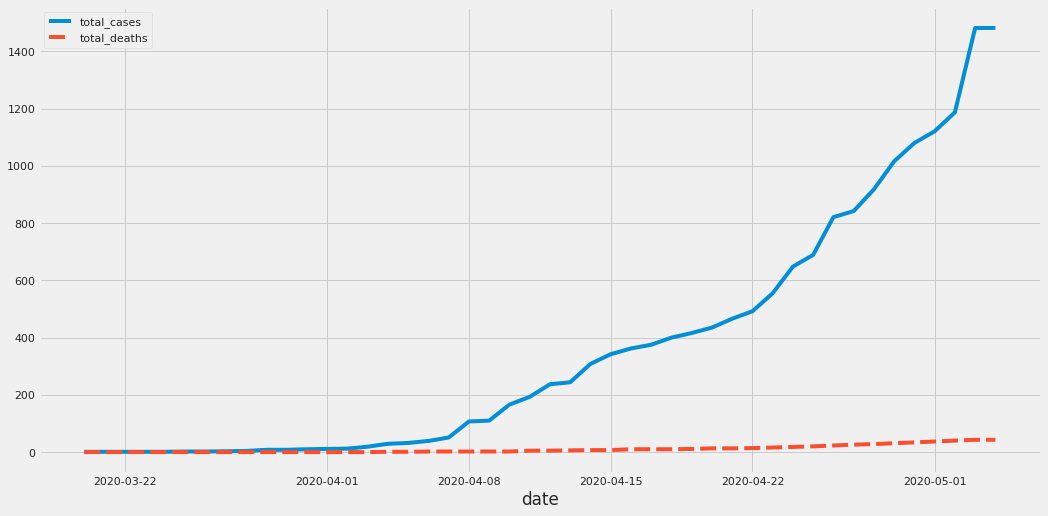

In [24]:
df_data_target['total_cases_ESTIMATED'] = (df_data_target['total_deaths'] / 0.05).shift(-7)
df_data_target['total_cases_ESTIMATED_2'] = 15 * df_data_target['total_cases']

# we have data for SRAG in Brazil only 
if target_location == 'Brazil':
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = \
        (df_data_target['new_cases'] * df_srag_adjustment_multipliers['SRAG_adjustment_multiplier'].reindex_like(df_data_target, method='ffill'))\
            .cumsum()
else:
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = df_data_target['new_cases'] * np.nan

sns.lineplot(data=df_data_target[['total_cases', 'total_deaths']])
df_data_target.tail()

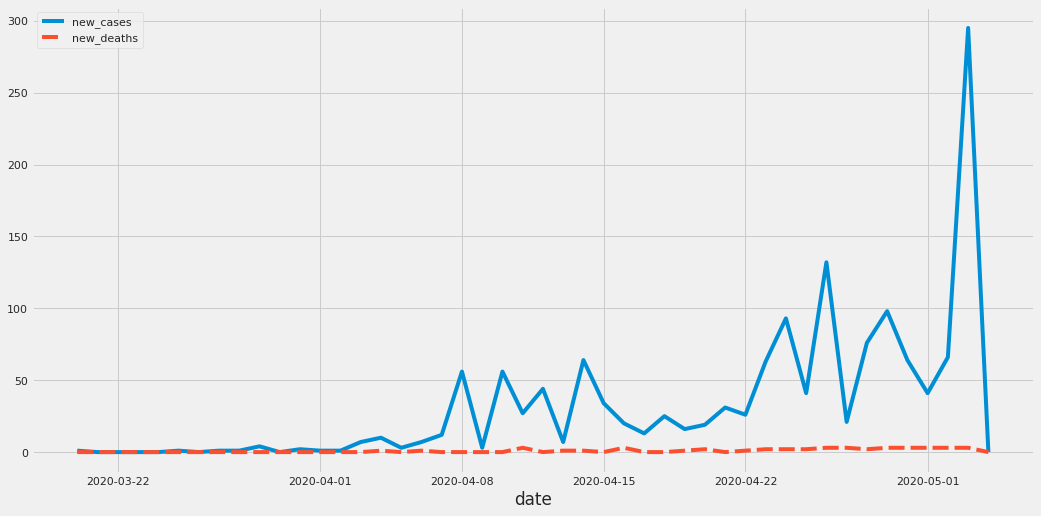

In [25]:
sns.lineplot(data=df_data_target[['new_cases', 'new_deaths']])

### Substituição de Parâmetros

Se requisitado, vamos substituir alguns dos parâmetros por valores presentes nos dados.

In [26]:
df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]

Timestamp('2020-04-07 00:00:00')

In [27]:
if infer_parameters_from_data:
    epidemic_start_date = df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]
    
    first_date_row = df_data_target.loc[epidemic_start_date]
    population_size = first_date_row['population']
    initially_infected = first_date_row[data_column_to_fit] #['total_cases']
    
    print(f'NEW VALUES: epidemic_start_date={epidemic_start_date}, population_size={population_size}, initially_infected={initially_infected}')
    

NEW VALUES: epidemic_start_date=2020-04-07 00:00:00, population_size=845731.0, initially_infected=765.0


Filtremos os dados a partir da data de interesse.

In [28]:
df_data_target = df_data_target[epidemic_start_date:]

## Modelo SEIR

O [modelo SEIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) é um dos modos clássicos de se representar a dinâmica de epidemias. Trata-se de um chamado "modelo de compartimento", no qual temos alguns compartimentos principais:

  - S(t): número de indivíduos suscetíveis em função do tempo.
  - E(t): número de expostos, mas ainda não transmissores, em função do tempo.
  - I(t): número de indivíduos infecciosos em função do tempo.
  - R(t): número de indivíduos que se recuperam em função do tempo.
  
São também necessários dois outros parâmetros, que definem taxas de transição entre compartimentos:
  
  - beta: valor entre 0.0 e 1.0 que define a taxa de S para E (i.e., taxa de exposição)
  - alpha: valor entre 0.0 e 1.0 que define a taxa de E para I (i.e., taxa de contaminação)
  - gamma: valor entre 0.0 e 1.0 que define a taxa de I para R (i.e., taxa de recuperação)

Tradicionalmente, esse modelo é tratado via equações diferenciais. Aqui, adotaremos uma implementação via simulações estocásticas, o que nos permitirá posteriormente realizar modificações variadas que talvez não sejam tratáveis analiticamente.

### Funções Auxiliares

Antes de prosseguir, vamos definir algumas funções auxliares que garantirão que os valores acrescidos ou subtraídos nos diversos compartimentos não ultrapassem valores limites.

In [29]:
def aux_enforce_max_addition(Q, delta):
    if Q - delta <= 0:
        return Q
    
    else:
        return delta
    
def aux_enforce_max_removal(Q, delta):
    if Q + delta <= 0:
        return -Q
    else:
        return delta

Ao longo de uma epidemia, é razoável supor que autoridades sanitárias e, de fato, a polulação como um todo, adotarão medidas que possam reduzir o contágio e melhorar as chances de recuperação. Isso pode ser modelado com parâmetros dinâmicos, supondo-se intervenções em momentos precisos do tempo. Assim, os parâmetros do modelo aqui proposto podem ser tanto escalares quanto dicionários que mapeiam instantes a valores naqueles instantes. Para que a simulação possa usar transparentemente qualquer caso, definimos a seguir uma função que extrai o valor do parâmetro conforme o caso.

In [30]:
def param_at(param_var, t):
    if isinstance(param_var, dict):
        return param_var[t]
    
    else:
        return param_var

Convém também ter uma função para montar as sequências de parâmetros (veremos um exemplo mais adiante para entender seu uso).

In [31]:
def dynamic_parameter(regimens, min_length):
    i = 0
    params = {}
    last_value = None
    min_length = int(min_length)
    for value, length in regimens:
        length = int(length)
        param = {t: value for t in range(i, i + length)}
        params.update(param)
        i += length
        last_value = value
    
    # if we do not have enough data, fill in the remaining entries with the last specified value
    if i < min_length:
        param = {t: last_value for t in range(i, i + min_length)}
        params.update(param)

    return params

### Funções dos Compartimentos

Podemos agora definir a dinâmica dos diversos compartimentos contemplados no modelo.

In [32]:
def s(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_removal(S, 
                                    -((param_at(beta, t) * I * S) / population_size))
    
    return delta

In [33]:
def e(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    delta = aux_enforce_max_removal(E,  
                                    param_at(delta_s, t) - param_at(alpha, t)*E)    
    
        
    return delta

In [34]:
def i(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
        
    delta = aux_enforce_max_removal(I, 
                                    param_at(delta_e, t) - param_at(gamma, t)*I)
        
    return delta

In [35]:
def r(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta

Também convém poder calcular a variação dos compartimentos E e I para posterior análise.

In [36]:
# how many new patients will be added to E
def e_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    return delta_s

In [37]:
# how many new patients will be added to I
def i_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
    
    return delta_e

In [38]:
# how many new patients will be added to R
def r_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_r = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta_r

### Simulação

A simulação então pode ser definida do seguinte modo.

In [39]:
def simulate(S, E, I, R, alpha, beta, gamma, epidemic_start_date, epidemic_duration_in_days, 
             s_func, e_func, i_func, r_func, e_delta_func, i_delta_func, r_delta_func):
    
    generated_data = [] # initial data
    
    # changes start at 0
    E_delta = 0
    I_delta = 0 
    R_delta = 0
    
    for t in range(0, epidemic_duration_in_days):
        generated_data.append((S, E, E_delta, I, I_delta, R, R_delta))
        
        # main model components
        S_next = S + s_func(t, S, E, I, R, alpha, beta, gamma)
        E_next = E + e_func(t, S, E, I, R, alpha, beta, gamma)
        I_next = I + i_func(t, S, E, I, R, alpha, beta, gamma)
        R_next = R + r_func(t, S, E, I, R, alpha, beta, gamma)
        
        # added information for later analyses
        I_delta = i_delta_func(t, S, E, I, R, alpha, beta, gamma)
        E_delta = e_delta_func(t, S, E, I, R, alpha, beta, gamma)
        R_delta = r_delta_func(t, S, E, I, R, alpha, beta, gamma)

        # lockstep updates
        S = S_next
        E = E_next
        I = I_next
        R = R_next

        assert math.isclose(S + E + I + R, population_size, rel_tol=1e-9, abs_tol=0.0), "Population size must not change."
    
    df = pd.DataFrame(generated_data,
                      columns=['S', 'E', 'E_delta', 'I', 'I_delta', 'R', 'R_delta'],
                      index=pd.date_range(start=epidemic_start_date, periods=epidemic_duration_in_days, freq='D'))
    
    df['E+I'] = df['E'] + df['I']
    df['E+I+R'] = df['E'] + df['I'] + df['R']
    
    return df

Podemos agora simular situações de interesse definindo os parâmetros do modelo.

In [40]:
alpha = 0.9   # E to I rate
beta = 0.8   # S to E rate
gamma = 0.3  # I to R rate

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-04-07,844966.000000,765.000000,0.000000,0.000000,0.000000,0.00000,0.00000,765.000000,765.000000
2020-04-08,844966.000000,76.500000,0.000000,688.500000,688.500000,0.00000,0.00000,765.000000,765.000000
2020-04-09,844415.698222,557.951778,550.301778,550.800000,68.850000,206.55000,206.55000,1108.751778,1315.301778
2020-04-10,843975.743516,495.749884,439.954706,887.716600,502.156600,371.79000,165.24000,1383.466484,1755.256484
2020-04-11,843267.044152,758.274353,708.699364,1067.576515,446.174895,638.10498,266.31498,1825.850868,2463.955848


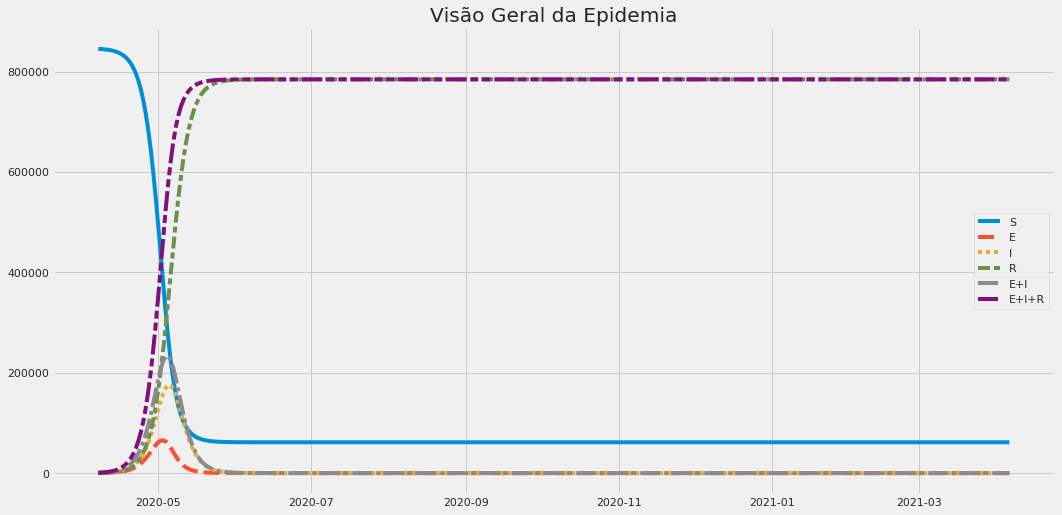

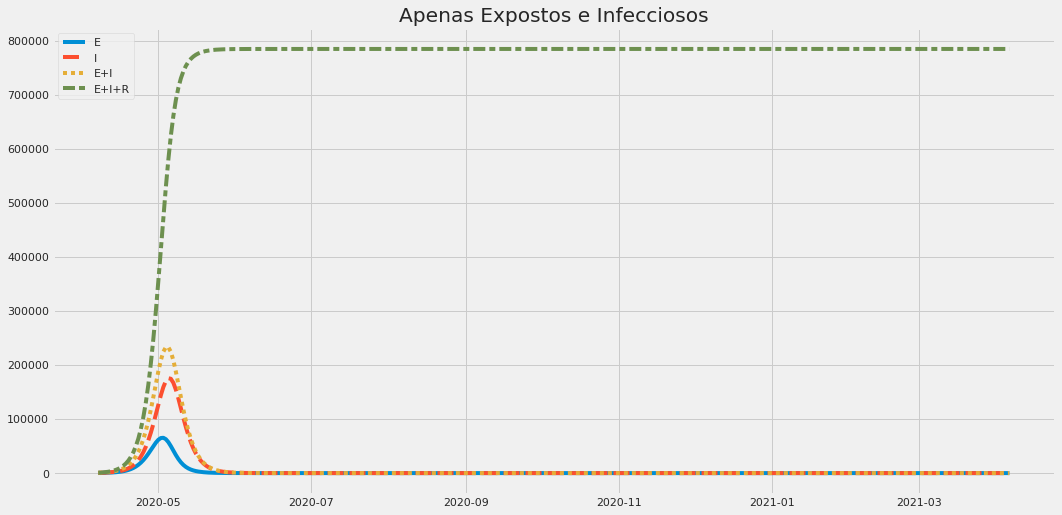

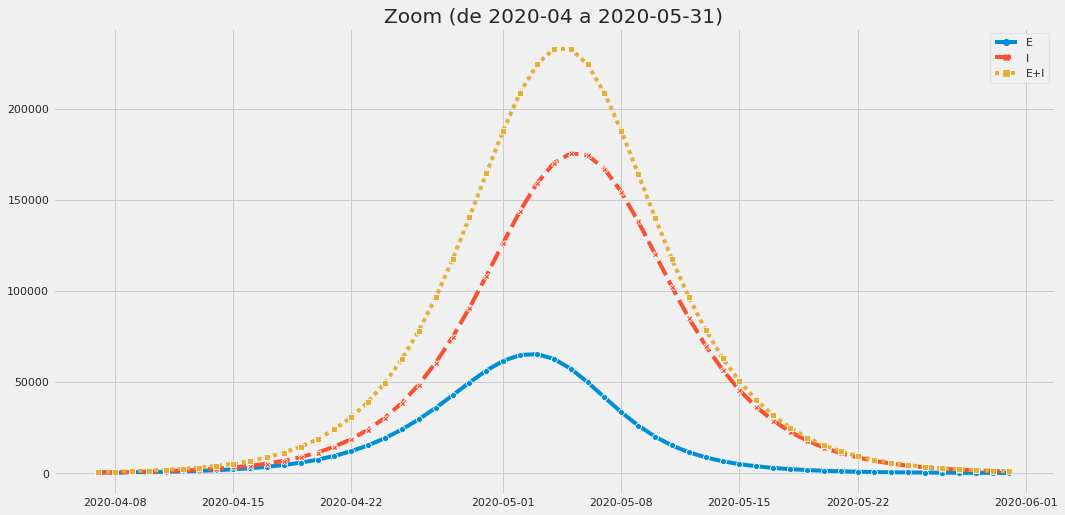

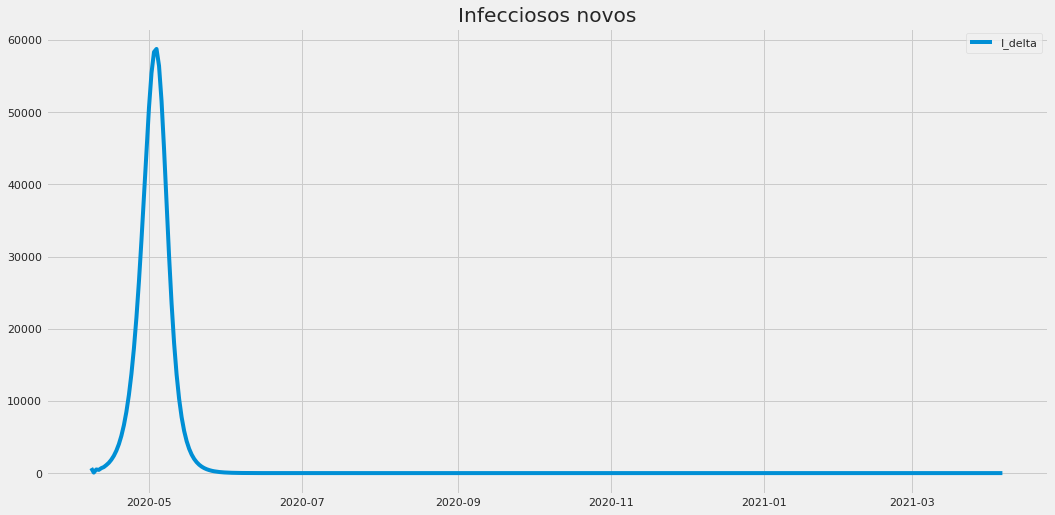

<Figure size 1152x576 with 0 Axes>

In [41]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data, zoom_on='2020-04')
df_simulation_data.head()

Como isso se compara visualmente com os dados reais observados?

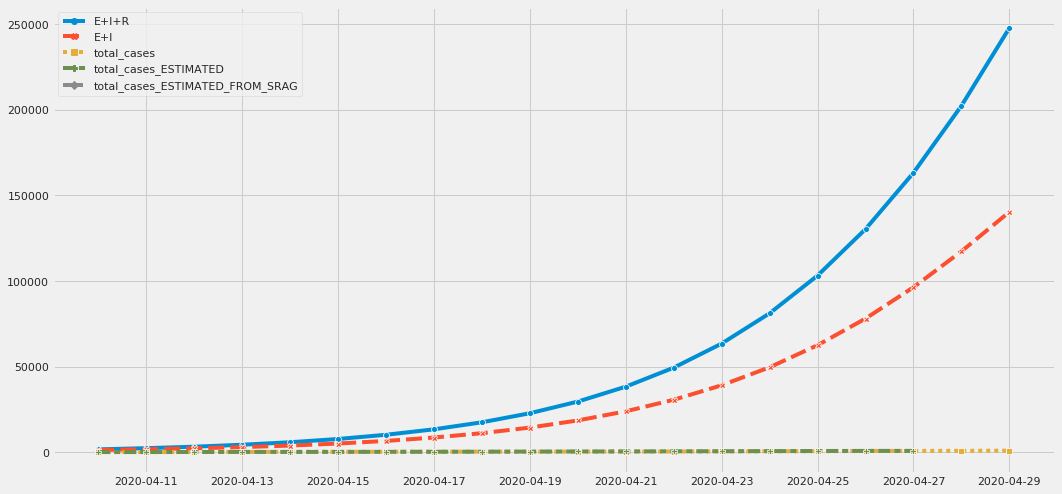

In [42]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=7)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_FROM_SRAG']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

Vejamos um exemplo agora de parâmetro dinâmico. Vamos definir o parâmetro *beta* como 0.3 nos primeiros 30 dias, 0.25 nos 60 dias seguintes e 0.2 daí em diante.

In [43]:
alpha = 1.0

beta = dynamic_parameter([(0.9, 10), 
                          (0.8, epidemic_duration_in_days)], min_length=epidemic_duration_in_days)

gamma = 0.4

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-04-07,844966.000000,765.000000,0.000000,0.000000,0.000000,0.000000,0.000000,765.000000,765.000000
2020-04-08,844966.000000,0.000000,0.000000,765.000000,765.000000,0.000000,0.000000,765.000000,765.000000
2020-04-09,844278.122778,687.877222,687.877222,459.000000,0.000000,306.000000,306.000000,1146.877222,1452.877222
2020-04-10,843865.732440,412.390337,412.390337,963.277222,687.877222,489.600000,183.600000,1375.667560,1865.267560
2020-04-11,843000.695006,865.037435,865.037435,990.356671,412.390337,874.910889,385.310889,1855.394106,2730.304994


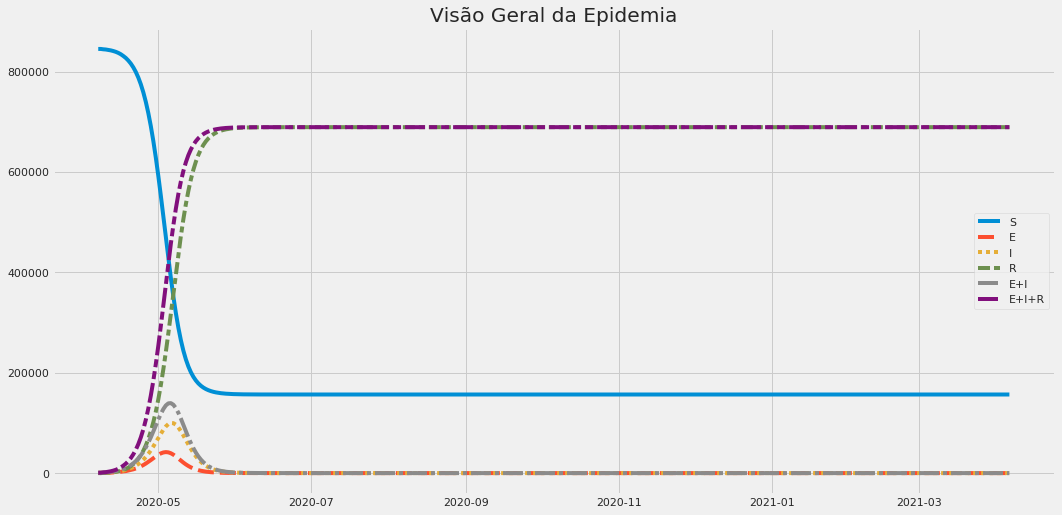

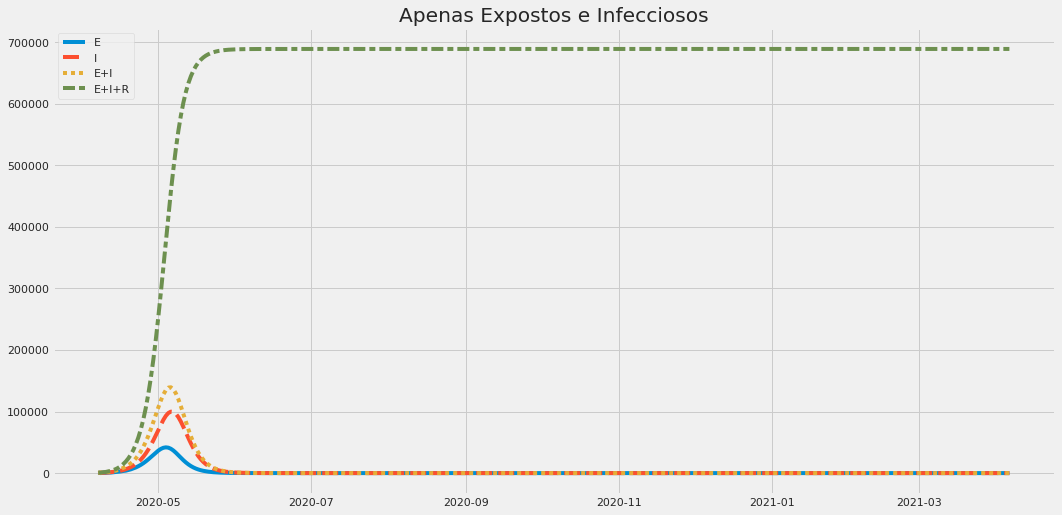

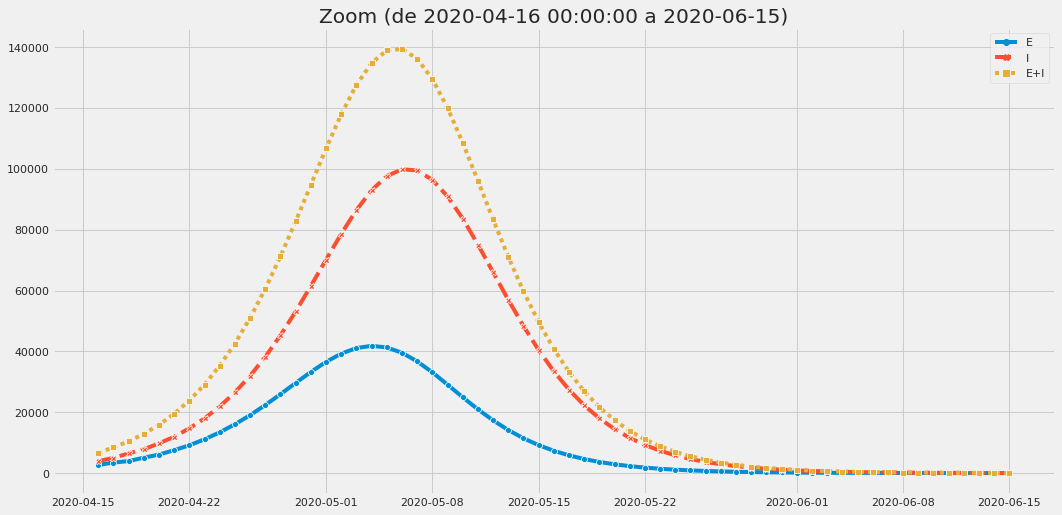

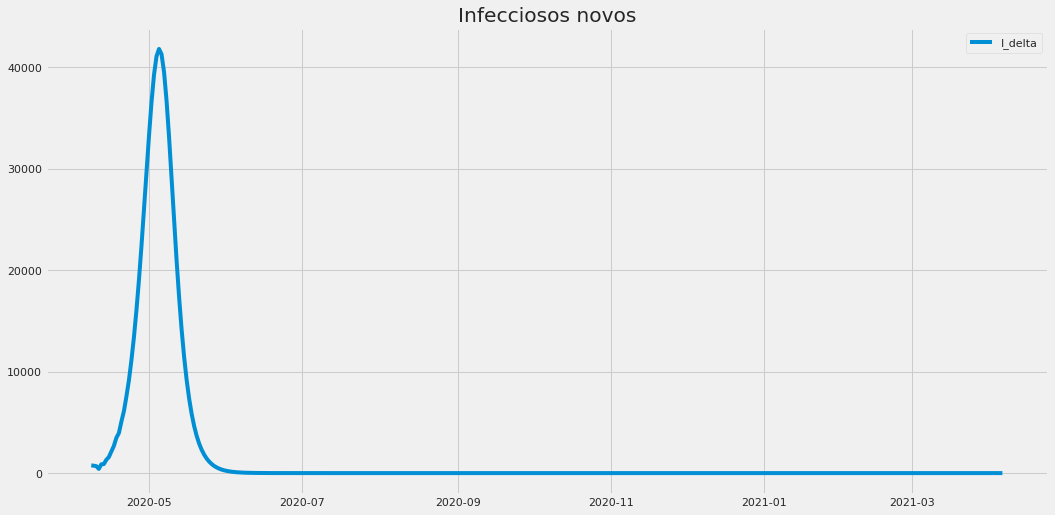

<Figure size 1152x576 with 0 Axes>

In [44]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data.head()

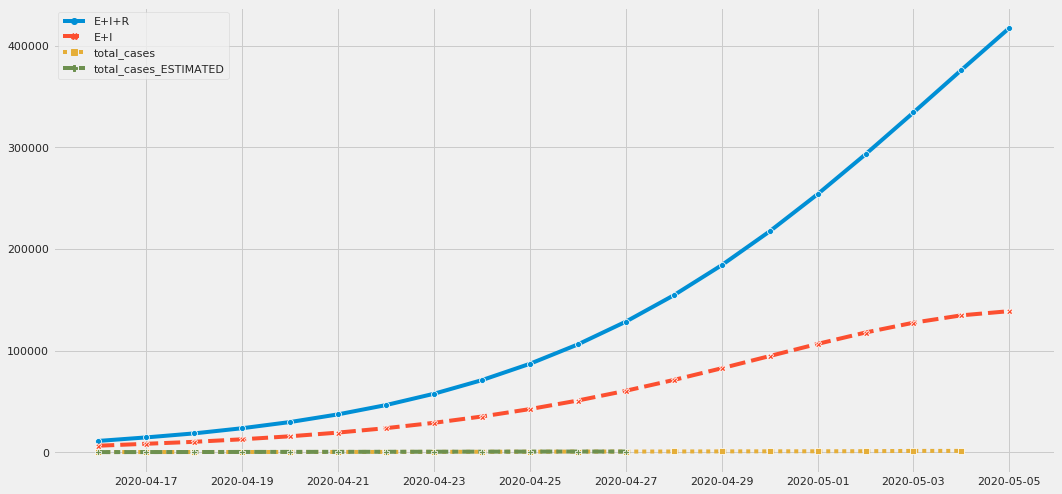

In [45]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=1)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

## Calibragem de Parâmetros

Podemos agora confrontar os modelos acima com dados reais observados e, assim, encontrar os parâmetros que melhor aproximam a realidade.

Faremos a busca de parâmetros empregando a biblioteca [hyperopt](https://github.com/hyperopt/hyperopt). Para tanto, precisamos definir uma função objetivo a ser otimizada. Aqui, essa função executa uma simulação com os parâmetros (*alpha*, *beta* e *gamma*) sugeridos, obtém a curva de infecções resultante e calcula o erro absoluto médio com relação às datas para as quais temos as observações reais.

In [46]:
def objective_for_simulation(args):
    ##################################################################
    # What kind of parameters we are optimizing? Constant or dynamic?
    ##################################################################
    if 'constant' in args:
        alpha, beta, gamma, t_min, t_max = args['constant']
    elif 'dynamic' in args:
        params_sets, t_min, t_max = args['dynamic'] # TODO
        alpha = []
        beta = []
        gamma = []
        prev_alpha = None
        prev_beta = None
        prev_gamma = None
        prev_duration = None
        for params in params_sets:
            cur_alpha = params.get('alpha', prev_alpha)
            cur_beta = params.get('beta', prev_beta)
            cur_gamma = params.get('gamma', prev_gamma)
            cur_duration = int(params.get('duration', prev_duration))
            
            alpha.append((cur_alpha, cur_duration))
            beta.append((cur_beta, cur_duration))
            gamma.append((cur_gamma, cur_duration))
            
            prev_alpha = cur_alpha
            prev_beta = cur_beta
            prev_gamma = cur_gamma
            prev_duration = cur_duration
        
        alpha = dynamic_parameter(alpha, min_length=epidemic_duration_in_days)
        beta = dynamic_parameter(beta, min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter(gamma, min_length=epidemic_duration_in_days)
        
    ###########
    # Simulate
    ###########
    df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha,beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,  
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)
    
    # run simulation
    df_simulation_data_filtered = df_simulation_data[df_simulation_data.index.isin(df_data_target.index.values)]
    
    ###################
    # Calculate error
    ###################
    df_diff_cases = df_data_target[data_column_to_fit] - \
                               (df_simulation_data_filtered['I'] + df_simulation_data_filtered['E'] + df_simulation_data_filtered['R'])
    
    # we can limit the temporal reach of the estimation if desired
    if t_min is not None and t_max is not None:
        df_diff_cases = df_diff_cases.iloc[t_min:t_max] 
    
    values = df_diff_cases.dropna().values

    mae = np.mean(abs(values)) #mean absolute error

    return mae

### Com Parâmetros Constantes

Suponhamos que os parâmetros do modelo sejam constantes, ou seja, que não haja mudanças de comportamento ou políticas ao longo da epidemia.

Definimos então o espaço de busca dos parâmetros e efetivamente executamos a busca.

In [47]:
#space = {'constant': (hyperopt.hp.uniform('alpha', 0.0, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, None)}
space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, 15)}

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=1000, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

  1%|          | 11/1000 [00:00<00:09, 108.70trial/s, best loss: 1137.7057934999145]

  2%|▏         | 22/1000 [00:00<00:09, 105.83trial/s, best loss: 1015.7506304732942]

  3%|▎         | 31/1000 [00:00<00:09, 99.02trial/s, best loss: 1015.7506304732942] 

  4%|▍         | 41/1000 [00:00<00:09, 96.94trial/s, best loss: 1015.7506304732942]

  5%|▌         | 51/1000 [00:00<00:09, 95.36trial/s, best loss: 1015.7506304732942]

  6%|▌         | 60/1000 [00:00<00:10, 92.69trial/s, best loss: 898.1120996180318] 

  7%|▋         | 69/1000 [00:00<00:11, 82.94trial/s, best loss: 715.0654876325597]

  8%|▊         | 78/1000 [00:00<00:10, 84.15trial/s, best loss: 655.8452307256949]

  9%|▊         | 87/1000 [00:00<00:10, 85.36trial/s, best loss: 580.5288444143138]

 10%|▉         | 96/1000 [00:01<00:10, 85.18trial/s, best loss: 580.5288444143138]

 10%|█         | 105/1000 [00:01<00:10, 85.35trial/s, best loss: 580.5288444143138]

 11%|█▏        | 114/1000 [00:01<00:10, 80.84trial/s, best loss: 580.5288444143138]

 12%|█▏        | 123/1000 [00:01<00:10, 81.83trial/s, best loss: 580.5288444143138]

 13%|█▎        | 132/1000 [00:01<00:10, 83.05trial/s, best loss: 580.5288444143138]

 14%|█▍        | 141/1000 [00:01<00:10, 83.31trial/s, best loss: 580.5288444143138]

 15%|█▌        | 150/1000 [00:01<00:10, 83.55trial/s, best loss: 580.5288444143138]

 16%|█▌        | 159/1000 [00:01<00:10, 80.86trial/s, best loss: 580.5288444143138]

 17%|█▋        | 168/1000 [00:01<00:10, 78.90trial/s, best loss: 580.5288444143138]

 18%|█▊        | 176/1000 [00:02<00:11, 72.69trial/s, best loss: 580.5288444143138]

 18%|█▊        | 184/1000 [00:02<00:12, 67.76trial/s, best loss: 580.5288444143138]

 19%|█▉        | 192/1000 [00:02<00:11, 68.87trial/s, best loss: 580.5288444143138]

 20%|██        | 200/1000 [00:02<00:11, 69.85trial/s, best loss: 580.5288444143138]

 21%|██        | 208/1000 [00:02<00:11, 70.84trial/s, best loss: 579.1378841337663]

 22%|██▏       | 216/1000 [00:02<00:11, 71.14trial/s, best loss: 579.1378841337663]

 22%|██▏       | 224/1000 [00:02<00:10, 72.09trial/s, best loss: 579.1378841337663]

 23%|██▎       | 232/1000 [00:02<00:10, 73.79trial/s, best loss: 579.1378841337663]

 24%|██▍       | 240/1000 [00:03<00:11, 67.97trial/s, best loss: 579.1378841337663]

 25%|██▍       | 247/1000 [00:03<00:11, 67.09trial/s, best loss: 579.1378841337663]

 25%|██▌       | 254/1000 [00:03<00:11, 65.47trial/s, best loss: 579.1378841337663]

 26%|██▌       | 262/1000 [00:03<00:10, 68.42trial/s, best loss: 579.1378841337663]

 27%|██▋       | 270/1000 [00:03<00:10, 70.53trial/s, best loss: 579.1378841337663]

 28%|██▊       | 278/1000 [00:03<00:09, 72.65trial/s, best loss: 579.1378841337663]

 29%|██▊       | 286/1000 [00:03<00:10, 70.04trial/s, best loss: 579.1378841337663]

 29%|██▉       | 294/1000 [00:03<00:11, 63.88trial/s, best loss: 579.1378841337663]

 30%|███       | 302/1000 [00:03<00:10, 66.54trial/s, best loss: 579.1378841337663]

 31%|███       | 309/1000 [00:04<00:10, 67.49trial/s, best loss: 579.1378841337663]

 32%|███▏      | 316/1000 [00:04<00:10, 68.20trial/s, best loss: 579.1378841337663]

 32%|███▏      | 323/1000 [00:04<00:10, 64.51trial/s, best loss: 579.1378841337663]

 33%|███▎      | 331/1000 [00:04<00:09, 66.99trial/s, best loss: 579.1378841337663]

 34%|███▍      | 339/1000 [00:04<00:09, 69.25trial/s, best loss: 579.1378841337663]

 35%|███▍      | 347/1000 [00:04<00:09, 69.99trial/s, best loss: 579.1378841337663]

 36%|███▌      | 355/1000 [00:04<00:09, 69.36trial/s, best loss: 579.1378841337663]

 36%|███▌      | 362/1000 [00:04<00:09, 68.78trial/s, best loss: 579.1378841337663]

 37%|███▋      | 369/1000 [00:04<00:09, 65.04trial/s, best loss: 579.1378841337663]

 38%|███▊      | 376/1000 [00:05<00:09, 63.84trial/s, best loss: 579.1378841337663]

 38%|███▊      | 383/1000 [00:05<00:11, 54.69trial/s, best loss: 579.1378841337663]

 39%|███▉      | 390/1000 [00:05<00:10, 57.50trial/s, best loss: 579.1378841337663]

 40%|███▉      | 397/1000 [00:05<00:10, 59.29trial/s, best loss: 579.1378841337663]

 40%|████      | 404/1000 [00:05<00:09, 61.05trial/s, best loss: 579.1378841337663]

 41%|████      | 411/1000 [00:05<00:09, 62.05trial/s, best loss: 579.1378841337663]

 42%|████▏     | 418/1000 [00:05<00:09, 63.05trial/s, best loss: 579.1378841337663]

 42%|████▎     | 425/1000 [00:05<00:09, 63.71trial/s, best loss: 579.1378841337663]

 43%|████▎     | 432/1000 [00:05<00:08, 63.94trial/s, best loss: 579.1378841337663]

 44%|████▍     | 439/1000 [00:06<00:08, 62.74trial/s, best loss: 579.1378841337663]

 45%|████▍     | 446/1000 [00:06<00:09, 61.42trial/s, best loss: 579.1378841337663]

 45%|████▌     | 453/1000 [00:06<00:09, 58.76trial/s, best loss: 579.1378841337663]

 46%|████▌     | 460/1000 [00:06<00:09, 59.91trial/s, best loss: 579.1378841337663]

 47%|████▋     | 467/1000 [00:06<00:09, 55.00trial/s, best loss: 579.1378841337663]

 47%|████▋     | 474/1000 [00:06<00:09, 56.61trial/s, best loss: 579.1378841337663]

 48%|████▊     | 481/1000 [00:06<00:08, 58.12trial/s, best loss: 579.1378841337663]

 49%|████▉     | 488/1000 [00:06<00:08, 59.44trial/s, best loss: 579.1378841337663]

 49%|████▉     | 494/1000 [00:07<00:08, 59.55trial/s, best loss: 579.1378841337663]

 50%|█████     | 501/1000 [00:07<00:08, 59.84trial/s, best loss: 579.1378841337663]

 51%|█████     | 508/1000 [00:07<00:08, 56.79trial/s, best loss: 579.1378841337663]

 51%|█████▏    | 514/1000 [00:07<00:08, 56.90trial/s, best loss: 579.1378841337663]

 52%|█████▏    | 520/1000 [00:07<00:08, 54.43trial/s, best loss: 579.1378841337663]

 53%|█████▎    | 526/1000 [00:07<00:08, 55.66trial/s, best loss: 579.1378841337663]

 53%|█████▎    | 532/1000 [00:07<00:08, 56.06trial/s, best loss: 579.1378841337663]

 54%|█████▍    | 538/1000 [00:07<00:08, 56.45trial/s, best loss: 579.1378841337663]

 54%|█████▍    | 544/1000 [00:07<00:08, 56.26trial/s, best loss: 579.1378841337663]

 55%|█████▌    | 550/1000 [00:08<00:08, 55.45trial/s, best loss: 579.1378841337663]

 56%|█████▌    | 556/1000 [00:08<00:08, 55.14trial/s, best loss: 579.1378841337663]

 56%|█████▌    | 562/1000 [00:08<00:08, 49.72trial/s, best loss: 579.1378841337663]

 57%|█████▋    | 568/1000 [00:08<00:09, 47.44trial/s, best loss: 579.1378841337663]

 57%|█████▋    | 574/1000 [00:08<00:08, 49.19trial/s, best loss: 579.1378841337663]

 58%|█████▊    | 580/1000 [00:08<00:08, 49.99trial/s, best loss: 579.1378841337663]

 59%|█████▊    | 586/1000 [00:08<00:08, 50.69trial/s, best loss: 579.1378841337663]

 59%|█████▉    | 592/1000 [00:08<00:08, 50.15trial/s, best loss: 579.1378841337663]

 60%|█████▉    | 598/1000 [00:09<00:08, 49.33trial/s, best loss: 579.1378841337663]

 60%|██████    | 603/1000 [00:09<00:08, 48.30trial/s, best loss: 579.1378841337663]

 61%|██████    | 608/1000 [00:09<00:08, 44.43trial/s, best loss: 579.1378841337663]

 61%|██████▏   | 613/1000 [00:09<00:08, 44.51trial/s, best loss: 579.1378841337663]

 62%|██████▏   | 618/1000 [00:09<00:08, 43.90trial/s, best loss: 579.1378841337663]

 62%|██████▏   | 623/1000 [00:09<00:08, 44.73trial/s, best loss: 579.1378841337663]

 63%|██████▎   | 628/1000 [00:09<00:08, 45.63trial/s, best loss: 579.1378841337663]

 63%|██████▎   | 633/1000 [00:09<00:07, 46.15trial/s, best loss: 579.1378841337663]

 64%|██████▍   | 638/1000 [00:09<00:07, 46.44trial/s, best loss: 579.1378841337663]

 64%|██████▍   | 643/1000 [00:10<00:07, 46.00trial/s, best loss: 579.1378841337663]

 65%|██████▍   | 648/1000 [00:10<00:07, 46.30trial/s, best loss: 579.1378841337663]

 65%|██████▌   | 653/1000 [00:10<00:07, 44.07trial/s, best loss: 579.1378841337663]

 66%|██████▌   | 658/1000 [00:10<00:07, 44.93trial/s, best loss: 579.1378841337663]

 66%|██████▋   | 663/1000 [00:10<00:07, 45.35trial/s, best loss: 579.1378841337663]

 67%|██████▋   | 668/1000 [00:10<00:07, 45.88trial/s, best loss: 579.1378841337663]

 67%|██████▋   | 673/1000 [00:10<00:07, 46.45trial/s, best loss: 579.1378841337663]

 68%|██████▊   | 678/1000 [00:10<00:06, 46.32trial/s, best loss: 579.1378841337663]

 68%|██████▊   | 683/1000 [00:10<00:06, 46.15trial/s, best loss: 579.1378841337663]

 69%|██████▉   | 688/1000 [00:11<00:06, 45.06trial/s, best loss: 579.1378841337663]

 69%|██████▉   | 693/1000 [00:11<00:06, 45.61trial/s, best loss: 579.1378841337663]

 70%|██████▉   | 698/1000 [00:11<00:06, 43.47trial/s, best loss: 579.1378841337663]

 70%|███████   | 703/1000 [00:11<00:06, 43.12trial/s, best loss: 579.1378841337663]

 71%|███████   | 708/1000 [00:11<00:06, 43.68trial/s, best loss: 579.1378841337663]

 71%|███████▏  | 713/1000 [00:11<00:06, 44.80trial/s, best loss: 579.1378841337663]

 72%|███████▏  | 718/1000 [00:11<00:06, 45.22trial/s, best loss: 579.1378841337663]

 72%|███████▏  | 723/1000 [00:11<00:06, 40.51trial/s, best loss: 579.1378841337663]

 73%|███████▎  | 728/1000 [00:11<00:06, 42.49trial/s, best loss: 579.1378841337663]

 73%|███████▎  | 733/1000 [00:12<00:06, 42.29trial/s, best loss: 579.1378841337663]

 74%|███████▍  | 738/1000 [00:12<00:06, 41.79trial/s, best loss: 579.1378841337663]

 74%|███████▍  | 743/1000 [00:12<00:06, 42.44trial/s, best loss: 579.1378841337663]

 75%|███████▍  | 748/1000 [00:12<00:05, 42.37trial/s, best loss: 579.1378841337663]

 75%|███████▌  | 753/1000 [00:12<00:05, 41.64trial/s, best loss: 579.1378841337663]

 76%|███████▌  | 758/1000 [00:12<00:05, 42.37trial/s, best loss: 579.1378841337663]

 76%|███████▋  | 763/1000 [00:12<00:05, 43.08trial/s, best loss: 579.1378841337663]

 77%|███████▋  | 768/1000 [00:12<00:05, 43.63trial/s, best loss: 579.1378841337663]

 77%|███████▋  | 773/1000 [00:13<00:05, 42.28trial/s, best loss: 579.1378841337663]

 78%|███████▊  | 778/1000 [00:13<00:05, 42.95trial/s, best loss: 579.1378841337663]

 78%|███████▊  | 783/1000 [00:13<00:05, 41.55trial/s, best loss: 579.1378841337663]

 79%|███████▉  | 788/1000 [00:13<00:05, 42.39trial/s, best loss: 579.1378841337663]

 79%|███████▉  | 793/1000 [00:13<00:04, 42.17trial/s, best loss: 579.1378841337663]

 80%|███████▉  | 798/1000 [00:13<00:04, 41.21trial/s, best loss: 579.1378841337663]

 80%|████████  | 803/1000 [00:13<00:04, 43.01trial/s, best loss: 579.1378841337663]

 81%|████████  | 808/1000 [00:13<00:04, 44.34trial/s, best loss: 579.1378841337663]

 81%|████████▏ | 813/1000 [00:13<00:04, 44.52trial/s, best loss: 579.1378841337663]

 82%|████████▏ | 818/1000 [00:14<00:04, 44.93trial/s, best loss: 579.1378841337663]

 82%|████████▏ | 823/1000 [00:14<00:03, 45.80trial/s, best loss: 579.1378841337663]

 83%|████████▎ | 828/1000 [00:14<00:04, 41.99trial/s, best loss: 579.1378841337663]

 83%|████████▎ | 833/1000 [00:14<00:03, 43.11trial/s, best loss: 579.1378841337663]

 84%|████████▍ | 838/1000 [00:14<00:03, 44.40trial/s, best loss: 579.1378841337663]

 84%|████████▍ | 843/1000 [00:14<00:03, 44.25trial/s, best loss: 579.1378841337663]

 85%|████████▍ | 848/1000 [00:14<00:03, 41.91trial/s, best loss: 579.1378841337663]

 85%|████████▌ | 853/1000 [00:14<00:03, 43.38trial/s, best loss: 579.1378841337663]

 86%|████████▌ | 858/1000 [00:15<00:03, 44.29trial/s, best loss: 579.1378841337663]

 86%|████████▋ | 863/1000 [00:15<00:03, 40.31trial/s, best loss: 579.1378841337663]

 87%|████████▋ | 868/1000 [00:15<00:03, 40.80trial/s, best loss: 579.1378841337663]

 87%|████████▋ | 873/1000 [00:15<00:03, 37.93trial/s, best loss: 579.1378841337663]

 88%|████████▊ | 877/1000 [00:15<00:03, 37.41trial/s, best loss: 579.1378841337663]

 88%|████████▊ | 882/1000 [00:15<00:02, 39.79trial/s, best loss: 579.1378841337663]

 89%|████████▊ | 887/1000 [00:15<00:02, 41.35trial/s, best loss: 579.1378841337663]

 89%|████████▉ | 892/1000 [00:15<00:02, 42.97trial/s, best loss: 579.1378841337663]

 90%|████████▉ | 897/1000 [00:15<00:02, 43.63trial/s, best loss: 579.1378841337663]

 90%|█████████ | 902/1000 [00:16<00:02, 43.91trial/s, best loss: 579.1378841337663]

 91%|█████████ | 907/1000 [00:16<00:02, 40.38trial/s, best loss: 579.1378841337663]

 91%|█████████ | 912/1000 [00:16<00:02, 37.67trial/s, best loss: 579.1378841337663]

 92%|█████████▏| 916/1000 [00:16<00:02, 33.71trial/s, best loss: 579.1378841337663]

 92%|█████████▏| 920/1000 [00:16<00:02, 33.56trial/s, best loss: 579.1378841337663]

 92%|█████████▏| 924/1000 [00:16<00:02, 29.84trial/s, best loss: 579.1378841337663]

 93%|█████████▎| 928/1000 [00:16<00:02, 31.91trial/s, best loss: 579.1378841337663]

 93%|█████████▎| 933/1000 [00:17<00:01, 34.02trial/s, best loss: 579.1378841337663]

 94%|█████████▎| 937/1000 [00:17<00:01, 35.07trial/s, best loss: 579.1378841337663]

 94%|█████████▍| 941/1000 [00:17<00:01, 33.75trial/s, best loss: 579.1378841337663]

 95%|█████████▍| 946/1000 [00:17<00:01, 35.83trial/s, best loss: 579.1378841337663]

 95%|█████████▌| 951/1000 [00:17<00:01, 38.52trial/s, best loss: 579.1378841337663]

 96%|█████████▌| 955/1000 [00:17<00:01, 38.59trial/s, best loss: 579.1378841337663]

 96%|█████████▌| 959/1000 [00:17<00:01, 36.06trial/s, best loss: 579.1378841337663]

 96%|█████████▋| 963/1000 [00:17<00:01, 36.35trial/s, best loss: 579.1378841337663]

 97%|█████████▋| 968/1000 [00:17<00:00, 39.04trial/s, best loss: 579.1378841337663]

 97%|█████████▋| 973/1000 [00:18<00:00, 40.47trial/s, best loss: 579.1378841337663]

 98%|█████████▊| 978/1000 [00:18<00:00, 42.05trial/s, best loss: 579.1378841337663]

 98%|█████████▊| 983/1000 [00:18<00:00, 35.57trial/s, best loss: 579.1378841337663]

 99%|█████████▊| 987/1000 [00:18<00:00, 33.74trial/s, best loss: 579.1378841337663]

 99%|█████████▉| 991/1000 [00:18<00:00, 34.54trial/s, best loss: 579.1378841337663]

100%|█████████▉| 996/1000 [00:18<00:00, 37.25trial/s, best loss: 579.1378841337663]

100%|██████████| 1000/1000 [00:18<00:00, 53.16trial/s, best loss: 579.1378841337663]


Best parameters found: {'alpha': 0.997654712474119, 'beta': 0.9983726384084346, 'gamma': 0.9245356631995252}


In [48]:
#trials.losses()
#pd.Series(trials.losses()).plot(title='Loss during optimiztion')

Podemos então executar o modelo com os parâmetros encontrados e examinar as curvas de progressão da epidemia.

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-04-07,844966.000000,765.000000,0.000000,0.000000,0.000000,0.000000,0.000000,765.000000,765.000000
2020-04-08,844966.000000,1.794145,0.000000,763.205855,763.205855,0.000000,0.000000,765.000000,765.000000
2020-04-09,844204.725386,761.278822,761.274614,59.384761,1.789937,705.611031,705.611031,820.663583,1526.274614
2020-04-10,844145.544262,60.966542,59.181124,763.974836,759.493404,760.514361,54.903329,824.941378,1585.455738
2020-04-11,843384.242549,761.444696,761.301712,118.476412,60.823558,1466.836342,706.321981,879.921109,2346.757451


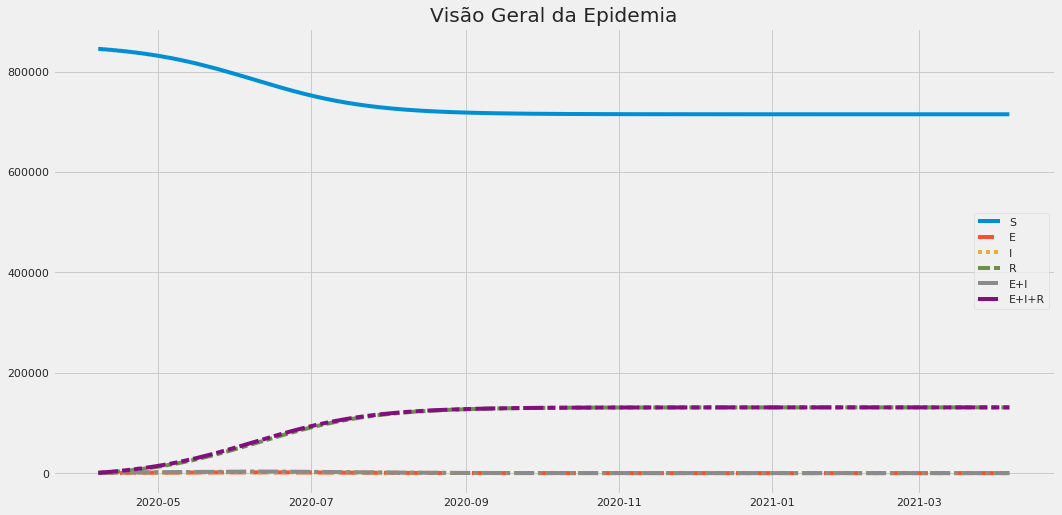

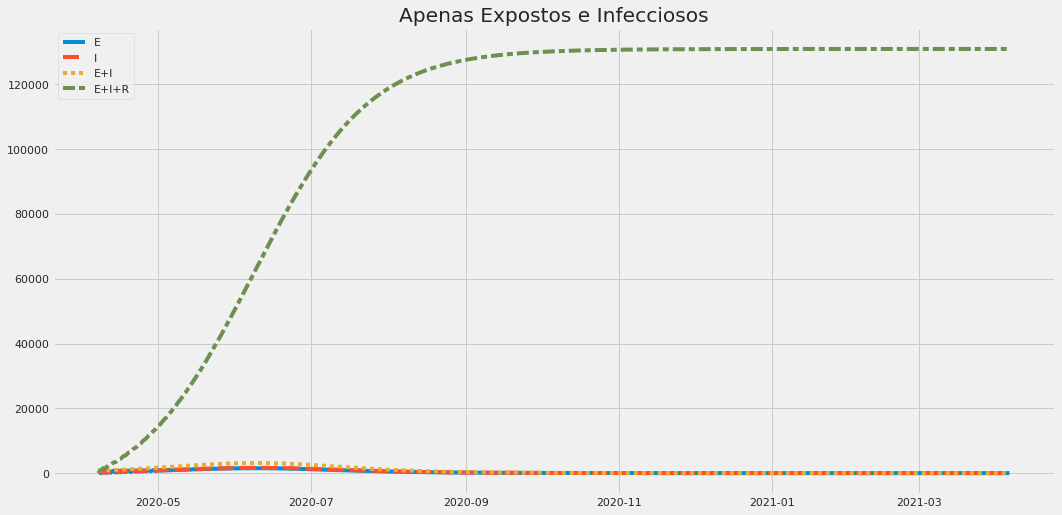

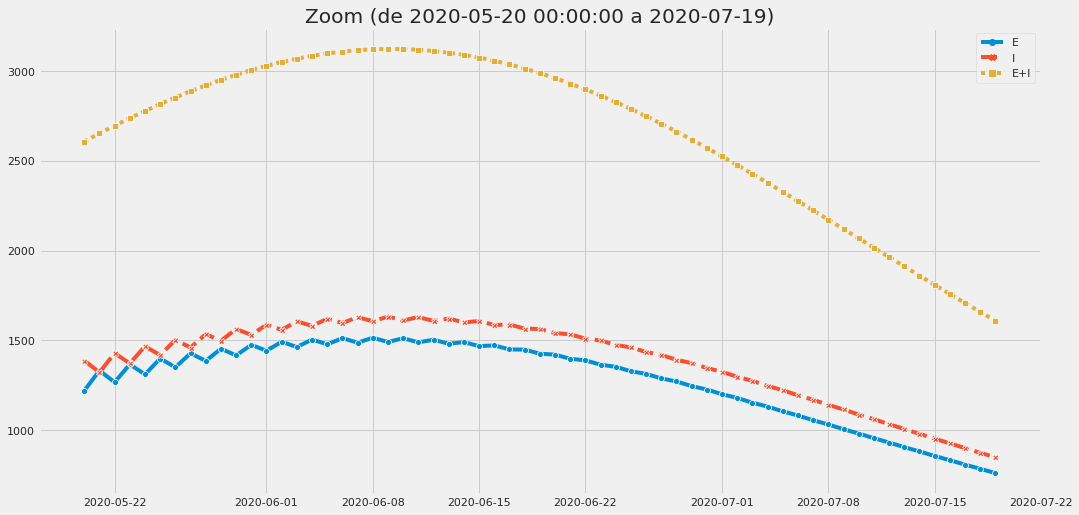

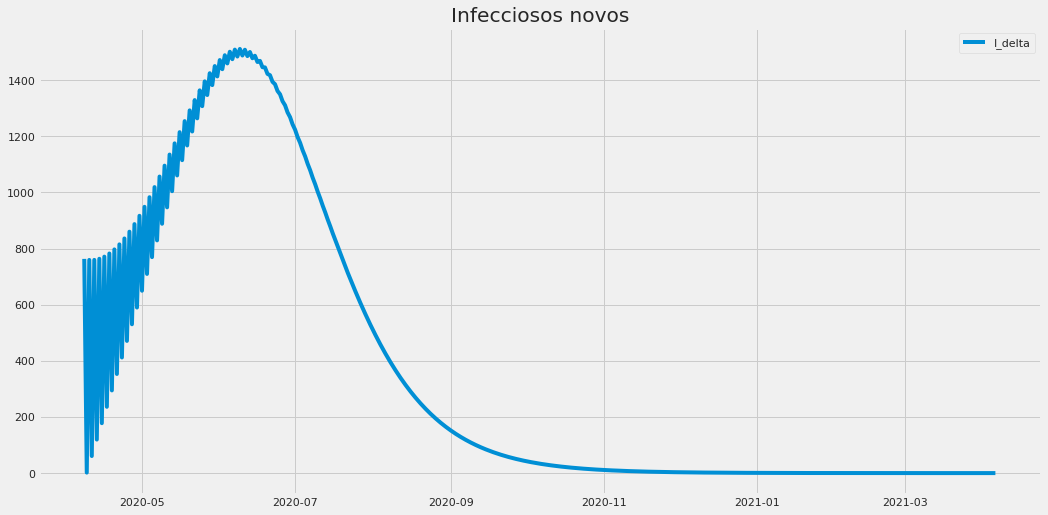

<Figure size 1152x576 with 0 Axes>

In [49]:
alpha = best['alpha']
beta  = best['beta']
gamma = best['gamma']

df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data['2020-03-16':'2020-05-01'].head()

Como isso se compara visualmente com os dados reais observados?

In [50]:
df_data_target.tail()

,new_cases,new_deaths,total_cases,total_deaths,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,
2020-04-30,64,3,1080,34,845731.0,NaN,16200,NaN
2020-05-01,41,3,1121,37,845731.0,NaN,16815,NaN
2020-05-02,66,3,1187,40,845731.0,NaN,17805,NaN
2020-05-03,295,3,1482,43,845731.0,NaN,22230,NaN
2020-05-04,0,0,1482,43,845731.0,NaN,22230,NaN


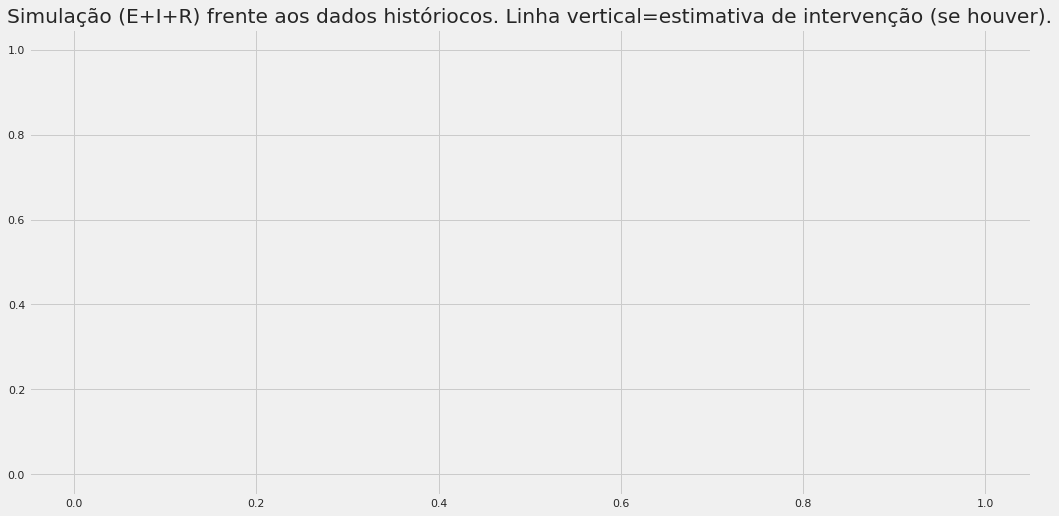

In [51]:
plot_curve_fitting(df_simulation_data=df_simulation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   comparison_date=pd.Timestamp('2020-04-01'),
                   best=best)

Salvemos os resultados.

In [52]:
df_simulation_data.to_csv(results_folder + f'seir_model_output.{target_location.lower()}.csv')

### Com Parâmetros Dinâmicos

Vamos experimentar agora introduzindo a possibilidade de aprender medidas de mitigação após o início do surto. Ou seja, experimentaremos com dois grupos de parâmetros: aqueles *antes* das medidas, e aqueles *depois* das medidas. Esses dois conjuntos de parâmetros serão estimados a partir dos dados fornecidos.

In [53]:
## assuming different gammas
#
#space = \
#    {'dynamic':\
#        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_1', 1.0, 10.0)}, 
#           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_2', 1.0, 10.0)},
#         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_3', 1.0, 10.0)}], 
#        0, 60)
#    }

# assuming gamma_1 == gamma_2 == gamma_3
space = \
    {'dynamic':\
        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
           'duration': hyperopt.hp.uniform('duration_1', 1.0, 20.0)}, 
           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_2', 1.0, 20.0)},
         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_3', 1.0, 20.0)}], 
        0, 60)
    }

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 10/3000 [00:00<00:31, 95.54trial/s, best loss: 1388.4634748623628]

  1%|          | 20/3000 [00:00<00:31, 95.96trial/s, best loss: 1388.4634748623628]

  1%|          | 26/3000 [00:00<00:38, 76.92trial/s, best loss: 1313.6227406372757]

  1%|          | 32/3000 [00:00<00:45, 65.33trial/s, best loss: 1313.6227406372757]

  1%|▏         | 38/3000 [00:00<00:49, 60.11trial/s, best loss: 1313.6227406372757]

  1%|▏         | 43/3000 [00:00<00:52, 56.18trial/s, best loss: 1313.6227406372757]

  2%|▏         | 49/3000 [00:00<00:54, 53.72trial/s, best loss: 1313.6227406372757]

  2%|▏         | 54/3000 [00:00<00:56, 52.34trial/s, best loss: 1313.6227406372757]

  2%|▏         | 59/3000 [00:01<01:00, 48.43trial/s, best loss: 1313.6227406372757]

  2%|▏         | 64/3000 [00:01<01:00, 48.57trial/s, best loss: 1313.6227406372757]

  2%|▏         | 69/3000 [00:01<01:00, 48.82trial/s, best loss: 953.7729790244202] 

  2%|▏         | 74/3000 [00:01<01:00, 48.60trial/s, best loss: 953.7729790244202]

  3%|▎         | 79/3000 [00:01<01:01, 47.77trial/s, best loss: 953.7729790244202]

  3%|▎         | 84/3000 [00:01<01:17, 37.48trial/s, best loss: 953.7729790244202]

  3%|▎         | 89/3000 [00:01<01:12, 40.09trial/s, best loss: 953.7729790244202]

  3%|▎         | 94/3000 [00:01<01:09, 41.77trial/s, best loss: 953.7729790244202]

  3%|▎         | 99/3000 [00:01<01:10, 41.31trial/s, best loss: 953.7729790244202]

  3%|▎         | 104/3000 [00:02<01:07, 42.65trial/s, best loss: 953.7729790244202]

  4%|▎         | 109/3000 [00:02<01:06, 43.71trial/s, best loss: 953.7729790244202]

  4%|▍         | 114/3000 [00:02<01:04, 44.56trial/s, best loss: 953.7729790244202]

  4%|▍         | 119/3000 [00:02<01:09, 41.48trial/s, best loss: 953.7729790244202]

  4%|▍         | 124/3000 [00:02<01:08, 41.88trial/s, best loss: 953.7729790244202]

  4%|▍         | 129/3000 [00:02<01:06, 43.04trial/s, best loss: 953.7729790244202]

  4%|▍         | 134/3000 [00:02<01:05, 43.81trial/s, best loss: 953.7729790244202]

  5%|▍         | 139/3000 [00:02<01:06, 43.10trial/s, best loss: 953.7729790244202]

  5%|▍         | 144/3000 [00:03<01:07, 42.04trial/s, best loss: 953.7729790244202]

  5%|▍         | 149/3000 [00:03<01:07, 42.35trial/s, best loss: 953.7729790244202]

  5%|▌         | 154/3000 [00:03<01:05, 43.16trial/s, best loss: 953.7729790244202]

  5%|▌         | 159/3000 [00:03<01:05, 43.62trial/s, best loss: 953.7729790244202]

  5%|▌         | 164/3000 [00:03<01:05, 43.62trial/s, best loss: 953.7729790244202]

  6%|▌         | 169/3000 [00:03<01:04, 43.77trial/s, best loss: 953.7729790244202]

  6%|▌         | 174/3000 [00:03<01:06, 42.45trial/s, best loss: 953.7729790244202]

  6%|▌         | 179/3000 [00:03<01:06, 42.38trial/s, best loss: 953.7729790244202]

  6%|▌         | 184/3000 [00:03<01:09, 40.73trial/s, best loss: 953.7729790244202]

  6%|▋         | 189/3000 [00:04<01:13, 38.23trial/s, best loss: 953.7729790244202]

  6%|▋         | 194/3000 [00:04<01:10, 39.58trial/s, best loss: 953.7729790244202]

  7%|▋         | 199/3000 [00:04<01:09, 40.55trial/s, best loss: 953.7729790244202]

  7%|▋         | 204/3000 [00:04<01:08, 40.80trial/s, best loss: 953.7729790244202]

  7%|▋         | 209/3000 [00:04<01:08, 40.64trial/s, best loss: 953.7729790244202]

  7%|▋         | 214/3000 [00:04<01:08, 40.50trial/s, best loss: 953.7729790244202]

  7%|▋         | 219/3000 [00:04<01:09, 40.28trial/s, best loss: 953.7729790244202]

  7%|▋         | 224/3000 [00:04<01:11, 38.99trial/s, best loss: 905.6093006478584]

  8%|▊         | 228/3000 [00:05<01:10, 39.21trial/s, best loss: 905.6093006478584]

  8%|▊         | 233/3000 [00:05<01:09, 39.80trial/s, best loss: 905.6093006478584]

  8%|▊         | 238/3000 [00:05<01:08, 40.25trial/s, best loss: 905.6093006478584]

  8%|▊         | 243/3000 [00:05<01:08, 40.19trial/s, best loss: 905.6093006478584]

  8%|▊         | 248/3000 [00:05<01:08, 40.41trial/s, best loss: 905.6093006478584]

  8%|▊         | 253/3000 [00:05<01:15, 36.49trial/s, best loss: 905.6093006478584]

  9%|▊         | 257/3000 [00:05<01:14, 37.05trial/s, best loss: 905.6093006478584]

  9%|▊         | 261/3000 [00:05<01:12, 37.88trial/s, best loss: 905.6093006478584]

  9%|▉         | 265/3000 [00:06<01:12, 37.50trial/s, best loss: 905.6093006478584]

  9%|▉         | 269/3000 [00:06<01:11, 38.06trial/s, best loss: 905.6093006478584]

  9%|▉         | 273/3000 [00:06<01:12, 37.87trial/s, best loss: 905.6093006478584]

  9%|▉         | 277/3000 [00:06<01:13, 37.22trial/s, best loss: 905.6093006478584]

  9%|▉         | 281/3000 [00:06<01:19, 34.14trial/s, best loss: 829.5275537675981]

 10%|▉         | 285/3000 [00:06<01:25, 31.74trial/s, best loss: 829.5275537675981]

 10%|▉         | 289/3000 [00:06<01:20, 33.62trial/s, best loss: 829.5275537675981]

 10%|▉         | 293/3000 [00:06<01:18, 34.62trial/s, best loss: 829.5275537675981]

 10%|▉         | 297/3000 [00:06<01:18, 34.40trial/s, best loss: 829.5275537675981]

 10%|█         | 301/3000 [00:07<01:16, 35.30trial/s, best loss: 829.5275537675981]

 10%|█         | 305/3000 [00:07<01:14, 36.25trial/s, best loss: 829.5275537675981]

 10%|█         | 309/3000 [00:07<01:13, 36.72trial/s, best loss: 829.5275537675981]

 10%|█         | 313/3000 [00:07<01:13, 36.81trial/s, best loss: 829.5275537675981]

 11%|█         | 317/3000 [00:07<01:12, 37.07trial/s, best loss: 829.5275537675981]

 11%|█         | 321/3000 [00:07<01:21, 32.93trial/s, best loss: 829.5275537675981]

 11%|█         | 325/3000 [00:07<01:18, 34.21trial/s, best loss: 829.5275537675981]

 11%|█         | 329/3000 [00:07<01:18, 33.89trial/s, best loss: 829.5275537675981]

 11%|█         | 333/3000 [00:08<01:29, 29.95trial/s, best loss: 829.5275537675981]

 11%|█         | 337/3000 [00:08<01:23, 31.82trial/s, best loss: 829.5275537675981]

 11%|█▏        | 341/3000 [00:08<01:20, 33.04trial/s, best loss: 829.5275537675981]

 12%|█▏        | 345/3000 [00:08<01:18, 33.88trial/s, best loss: 829.5275537675981]

 12%|█▏        | 349/3000 [00:08<01:18, 33.92trial/s, best loss: 829.5275537675981]

 12%|█▏        | 353/3000 [00:08<01:18, 33.76trial/s, best loss: 829.5275537675981]

 12%|█▏        | 357/3000 [00:08<01:18, 33.60trial/s, best loss: 829.5275537675981]

 12%|█▏        | 361/3000 [00:08<01:19, 33.25trial/s, best loss: 829.5275537675981]

 12%|█▏        | 365/3000 [00:09<01:23, 31.52trial/s, best loss: 829.5275537675981]

 12%|█▏        | 369/3000 [00:09<01:23, 31.69trial/s, best loss: 829.5275537675981]

 12%|█▏        | 373/3000 [00:09<01:22, 31.78trial/s, best loss: 829.5275537675981]

 13%|█▎        | 377/3000 [00:09<01:22, 31.96trial/s, best loss: 829.5275537675981]

 13%|█▎        | 381/3000 [00:09<01:21, 32.03trial/s, best loss: 829.5275537675981]

 13%|█▎        | 385/3000 [00:09<01:21, 32.05trial/s, best loss: 829.5275537675981]

 13%|█▎        | 389/3000 [00:09<01:21, 32.01trial/s, best loss: 829.5275537675981]

 13%|█▎        | 393/3000 [00:09<01:22, 31.67trial/s, best loss: 805.1324943190068]

 13%|█▎        | 397/3000 [00:10<01:32, 28.04trial/s, best loss: 805.1324943190068]

 13%|█▎        | 400/3000 [00:10<01:35, 27.13trial/s, best loss: 805.1324943190068]

 13%|█▎        | 403/3000 [00:10<01:40, 25.72trial/s, best loss: 680.0382993101792]

 14%|█▎        | 406/3000 [00:10<01:44, 24.80trial/s, best loss: 680.0382993101792]

 14%|█▎        | 409/3000 [00:10<01:41, 25.54trial/s, best loss: 680.0382993101792]

 14%|█▎        | 412/3000 [00:10<01:40, 25.75trial/s, best loss: 680.0382993101792]

 14%|█▍        | 415/3000 [00:10<01:55, 22.39trial/s, best loss: 680.0382993101792]

 14%|█▍        | 418/3000 [00:10<01:59, 21.62trial/s, best loss: 680.0382993101792]

 14%|█▍        | 421/3000 [00:11<01:55, 22.30trial/s, best loss: 680.0382993101792]

 14%|█▍        | 424/3000 [00:11<01:54, 22.57trial/s, best loss: 680.0382993101792]

 14%|█▍        | 427/3000 [00:11<01:51, 23.13trial/s, best loss: 680.0382993101792]

 14%|█▍        | 430/3000 [00:11<01:47, 23.98trial/s, best loss: 663.8031098692336]

 14%|█▍        | 433/3000 [00:11<01:44, 24.47trial/s, best loss: 663.8031098692336]

 15%|█▍        | 436/3000 [00:11<01:41, 25.14trial/s, best loss: 663.8031098692336]

 15%|█▍        | 439/3000 [00:11<01:43, 24.63trial/s, best loss: 663.8031098692336]

 15%|█▍        | 442/3000 [00:11<01:51, 22.87trial/s, best loss: 663.8031098692336]

 15%|█▍        | 445/3000 [00:12<01:46, 23.95trial/s, best loss: 663.8031098692336]

 15%|█▍        | 448/3000 [00:12<01:48, 23.60trial/s, best loss: 663.8031098692336]

 15%|█▌        | 451/3000 [00:12<01:45, 24.15trial/s, best loss: 606.4217401386512]

 15%|█▌        | 454/3000 [00:12<01:44, 24.41trial/s, best loss: 606.4217401386512]

 15%|█▌        | 457/3000 [00:12<01:43, 24.67trial/s, best loss: 606.4217401386512]

 15%|█▌        | 460/3000 [00:12<01:40, 25.20trial/s, best loss: 606.4217401386512]

 15%|█▌        | 463/3000 [00:12<01:42, 24.69trial/s, best loss: 606.4217401386512]

 16%|█▌        | 466/3000 [00:12<01:39, 25.44trial/s, best loss: 606.4217401386512]

 16%|█▌        | 469/3000 [00:13<01:48, 23.34trial/s, best loss: 601.2351592957751]

 16%|█▌        | 472/3000 [00:13<01:47, 23.53trial/s, best loss: 601.2351592957751]

 16%|█▌        | 475/3000 [00:13<01:45, 24.00trial/s, best loss: 601.2351592957751]

 16%|█▌        | 478/3000 [00:13<01:41, 24.73trial/s, best loss: 601.2351592957751]

 16%|█▌        | 481/3000 [00:13<01:38, 25.67trial/s, best loss: 601.2351592957751]

 16%|█▌        | 484/3000 [00:13<01:35, 26.32trial/s, best loss: 601.2351592957751]

 16%|█▌        | 487/3000 [00:13<01:33, 26.77trial/s, best loss: 601.2351592957751]

 16%|█▋        | 490/3000 [00:13<01:33, 26.91trial/s, best loss: 601.2351592957751]

 16%|█▋        | 493/3000 [00:14<01:37, 25.77trial/s, best loss: 601.2351592957751]

 17%|█▋        | 496/3000 [00:14<01:35, 26.30trial/s, best loss: 601.2351592957751]

 17%|█▋        | 499/3000 [00:14<01:33, 26.70trial/s, best loss: 601.2351592957751]

 17%|█▋        | 502/3000 [00:14<01:32, 27.03trial/s, best loss: 601.2351592957751]

 17%|█▋        | 505/3000 [00:14<01:32, 26.99trial/s, best loss: 601.2351592957751]

 17%|█▋        | 508/3000 [00:14<01:31, 27.17trial/s, best loss: 601.2351592957751]

 17%|█▋        | 511/3000 [00:14<01:31, 27.10trial/s, best loss: 601.2351592957751]

 17%|█▋        | 514/3000 [00:14<01:31, 27.07trial/s, best loss: 601.2351592957751]

 17%|█▋        | 517/3000 [00:14<01:32, 26.83trial/s, best loss: 601.2351592957751]

 17%|█▋        | 520/3000 [00:15<01:45, 23.47trial/s, best loss: 601.2351592957751]

 17%|█▋        | 523/3000 [00:15<01:42, 24.05trial/s, best loss: 601.2351592957751]

 18%|█▊        | 526/3000 [00:15<01:40, 24.72trial/s, best loss: 601.2351592957751]

 18%|█▊        | 529/3000 [00:15<01:38, 25.16trial/s, best loss: 601.2351592957751]

 18%|█▊        | 532/3000 [00:15<01:36, 25.47trial/s, best loss: 601.2351592957751]

 18%|█▊        | 535/3000 [00:15<01:36, 25.46trial/s, best loss: 601.2351592957751]

 18%|█▊        | 538/3000 [00:15<01:35, 25.83trial/s, best loss: 601.2351592957751]

 18%|█▊        | 541/3000 [00:15<01:35, 25.79trial/s, best loss: 601.2351592957751]

 18%|█▊        | 544/3000 [00:16<01:47, 22.93trial/s, best loss: 601.2351592957751]

 18%|█▊        | 547/3000 [00:16<01:48, 22.69trial/s, best loss: 601.2351592957751]

 18%|█▊        | 550/3000 [00:16<01:45, 23.20trial/s, best loss: 601.2351592957751]

 18%|█▊        | 553/3000 [00:16<01:41, 24.04trial/s, best loss: 601.2351592957751]

 19%|█▊        | 556/3000 [00:16<01:38, 24.82trial/s, best loss: 601.2351592957751]

 19%|█▊        | 559/3000 [00:16<01:36, 25.21trial/s, best loss: 601.2351592957751]

 19%|█▊        | 562/3000 [00:16<01:40, 24.14trial/s, best loss: 601.2351592957751]

 19%|█▉        | 565/3000 [00:16<01:42, 23.82trial/s, best loss: 601.2351592957751]

 19%|█▉        | 568/3000 [00:17<01:42, 23.81trial/s, best loss: 601.2351592957751]

 19%|█▉        | 571/3000 [00:17<01:39, 24.41trial/s, best loss: 601.2351592957751]

 19%|█▉        | 574/3000 [00:17<01:37, 24.82trial/s, best loss: 601.2351592957751]

 19%|█▉        | 577/3000 [00:17<01:36, 25.07trial/s, best loss: 601.2351592957751]

 19%|█▉        | 580/3000 [00:17<01:36, 24.95trial/s, best loss: 601.2351592957751]

 19%|█▉        | 583/3000 [00:17<01:35, 25.30trial/s, best loss: 601.2351592957751]

 20%|█▉        | 586/3000 [00:17<01:45, 22.82trial/s, best loss: 601.2351592957751]

 20%|█▉        | 589/3000 [00:17<01:42, 23.41trial/s, best loss: 601.2351592957751]

 20%|█▉        | 592/3000 [00:18<01:47, 22.47trial/s, best loss: 601.2351592957751]

 20%|█▉        | 595/3000 [00:18<01:43, 23.28trial/s, best loss: 601.2351592957751]

 20%|█▉        | 598/3000 [00:18<01:40, 23.96trial/s, best loss: 601.2351592957751]

 20%|██        | 601/3000 [00:18<01:38, 24.47trial/s, best loss: 601.2351592957751]

 20%|██        | 604/3000 [00:18<01:38, 24.30trial/s, best loss: 601.2351592957751]

 20%|██        | 607/3000 [00:18<01:48, 22.13trial/s, best loss: 601.2351592957751]

 20%|██        | 610/3000 [00:18<01:44, 22.92trial/s, best loss: 601.2351592957751]

 20%|██        | 613/3000 [00:18<01:41, 23.61trial/s, best loss: 601.2351592957751]

 21%|██        | 616/3000 [00:19<01:40, 23.64trial/s, best loss: 601.2351592957751]

 21%|██        | 619/3000 [00:19<01:38, 24.24trial/s, best loss: 601.2351592957751]

 21%|██        | 622/3000 [00:19<01:37, 24.39trial/s, best loss: 601.2351592957751]

 21%|██        | 625/3000 [00:19<01:36, 24.60trial/s, best loss: 601.2351592957751]

 21%|██        | 628/3000 [00:19<01:37, 24.32trial/s, best loss: 601.2351592957751]

 21%|██        | 631/3000 [00:19<01:36, 24.63trial/s, best loss: 601.2351592957751]

 21%|██        | 634/3000 [00:19<01:36, 24.61trial/s, best loss: 601.2351592957751]

 21%|██        | 637/3000 [00:19<01:37, 24.33trial/s, best loss: 601.2351592957751]

 21%|██▏       | 640/3000 [00:20<01:40, 23.54trial/s, best loss: 601.2351592957751]

 21%|██▏       | 643/3000 [00:20<01:40, 23.53trial/s, best loss: 601.2351592957751]

 22%|██▏       | 646/3000 [00:20<01:38, 23.78trial/s, best loss: 601.2351592957751]

 22%|██▏       | 649/3000 [00:20<01:47, 21.94trial/s, best loss: 601.2351592957751]

 22%|██▏       | 652/3000 [00:20<01:50, 21.31trial/s, best loss: 601.2351592957751]

 22%|██▏       | 655/3000 [00:20<02:02, 19.20trial/s, best loss: 601.2351592957751]

 22%|██▏       | 657/3000 [00:20<02:21, 16.54trial/s, best loss: 601.2351592957751]

 22%|██▏       | 660/3000 [00:21<02:09, 18.04trial/s, best loss: 601.2351592957751]

 22%|██▏       | 663/3000 [00:21<01:58, 19.66trial/s, best loss: 601.2351592957751]

 22%|██▏       | 666/3000 [00:21<01:57, 19.92trial/s, best loss: 601.2351592957751]

 22%|██▏       | 669/3000 [00:21<01:51, 20.83trial/s, best loss: 601.2351592957751]

 22%|██▏       | 672/3000 [00:21<02:00, 19.37trial/s, best loss: 601.2351592957751]

 22%|██▎       | 675/3000 [00:21<01:56, 19.96trial/s, best loss: 601.2351592957751]

 23%|██▎       | 678/3000 [00:21<01:54, 20.29trial/s, best loss: 601.2351592957751]

 23%|██▎       | 681/3000 [00:22<01:53, 20.49trial/s, best loss: 601.2351592957751]

 23%|██▎       | 684/3000 [00:22<01:47, 21.54trial/s, best loss: 601.2351592957751]

 23%|██▎       | 687/3000 [00:22<01:43, 22.32trial/s, best loss: 601.2351592957751]

 23%|██▎       | 690/3000 [00:22<01:41, 22.72trial/s, best loss: 601.2351592957751]

 23%|██▎       | 693/3000 [00:22<01:39, 23.27trial/s, best loss: 601.2351592957751]

 23%|██▎       | 696/3000 [00:22<01:39, 23.24trial/s, best loss: 601.2351592957751]

 23%|██▎       | 699/3000 [00:22<01:38, 23.33trial/s, best loss: 601.2351592957751]

 23%|██▎       | 702/3000 [00:22<01:39, 23.02trial/s, best loss: 601.2351592957751]

 24%|██▎       | 705/3000 [00:23<01:40, 22.93trial/s, best loss: 601.2351592957751]

 24%|██▎       | 708/3000 [00:23<01:44, 22.02trial/s, best loss: 601.2351592957751]

 24%|██▎       | 711/3000 [00:23<01:41, 22.55trial/s, best loss: 601.2351592957751]

 24%|██▍       | 714/3000 [00:23<01:40, 22.85trial/s, best loss: 601.2351592957751]

 24%|██▍       | 717/3000 [00:23<01:48, 21.07trial/s, best loss: 601.2351592957751]

 24%|██▍       | 720/3000 [00:23<01:44, 21.76trial/s, best loss: 601.2351592957751]

 24%|██▍       | 723/3000 [00:23<01:48, 20.96trial/s, best loss: 601.2351592957751]

 24%|██▍       | 726/3000 [00:24<01:47, 21.13trial/s, best loss: 601.2351592957751]

 24%|██▍       | 729/3000 [00:24<01:44, 21.79trial/s, best loss: 601.2351592957751]

 24%|██▍       | 732/3000 [00:24<01:41, 22.33trial/s, best loss: 601.2351592957751]

 24%|██▍       | 735/3000 [00:24<01:44, 21.75trial/s, best loss: 601.2351592957751]

 25%|██▍       | 738/3000 [00:24<01:49, 20.65trial/s, best loss: 601.2351592957751]

 25%|██▍       | 741/3000 [00:24<01:48, 20.82trial/s, best loss: 601.2351592957751]

 25%|██▍       | 744/3000 [00:24<01:44, 21.58trial/s, best loss: 601.2351592957751]

 25%|██▍       | 747/3000 [00:25<01:44, 21.47trial/s, best loss: 601.2351592957751]

 25%|██▌       | 750/3000 [00:25<01:43, 21.80trial/s, best loss: 601.2351592957751]

 25%|██▌       | 753/3000 [00:25<01:40, 22.32trial/s, best loss: 601.2351592957751]

 25%|██▌       | 756/3000 [00:25<01:49, 20.53trial/s, best loss: 601.2351592957751]

 25%|██▌       | 759/3000 [00:25<01:45, 21.32trial/s, best loss: 601.2351592957751]

 25%|██▌       | 762/3000 [00:25<01:42, 21.92trial/s, best loss: 601.2351592957751]

 26%|██▌       | 765/3000 [00:25<01:40, 22.22trial/s, best loss: 601.2351592957751]

 26%|██▌       | 768/3000 [00:26<01:42, 21.86trial/s, best loss: 601.2351592957751]

 26%|██▌       | 771/3000 [00:26<01:40, 22.22trial/s, best loss: 601.2351592957751]

 26%|██▌       | 774/3000 [00:26<01:38, 22.63trial/s, best loss: 601.2351592957751]

 26%|██▌       | 777/3000 [00:26<01:38, 22.68trial/s, best loss: 601.2351592957751]

 26%|██▌       | 780/3000 [00:26<01:36, 22.90trial/s, best loss: 601.2351592957751]

 26%|██▌       | 783/3000 [00:26<01:36, 22.94trial/s, best loss: 601.2351592957751]

 26%|██▌       | 786/3000 [00:26<01:36, 22.90trial/s, best loss: 601.2351592957751]

 26%|██▋       | 789/3000 [00:26<01:36, 22.88trial/s, best loss: 601.2351592957751]

 26%|██▋       | 792/3000 [00:27<01:49, 20.08trial/s, best loss: 601.2351592957751]

 26%|██▋       | 795/3000 [00:27<01:45, 20.90trial/s, best loss: 601.2351592957751]

 27%|██▋       | 798/3000 [00:27<01:43, 21.34trial/s, best loss: 601.2351592957751]

 27%|██▋       | 801/3000 [00:27<01:43, 21.21trial/s, best loss: 601.2351592957751]

 27%|██▋       | 804/3000 [00:27<01:42, 21.52trial/s, best loss: 601.2351592957751]

 27%|██▋       | 807/3000 [00:27<01:40, 21.77trial/s, best loss: 601.2351592957751]

 27%|██▋       | 810/3000 [00:27<01:39, 21.98trial/s, best loss: 601.2351592957751]

 27%|██▋       | 813/3000 [00:28<01:42, 21.31trial/s, best loss: 601.2351592957751]

 27%|██▋       | 816/3000 [00:28<01:39, 21.85trial/s, best loss: 601.2351592957751]

 27%|██▋       | 819/3000 [00:28<01:38, 22.14trial/s, best loss: 601.2351592957751]

 27%|██▋       | 822/3000 [00:28<01:37, 22.41trial/s, best loss: 601.2351592957751]

 28%|██▊       | 825/3000 [00:28<01:36, 22.51trial/s, best loss: 601.2351592957751]

 28%|██▊       | 828/3000 [00:28<01:46, 20.31trial/s, best loss: 601.2351592957751]

 28%|██▊       | 831/3000 [00:28<01:44, 20.77trial/s, best loss: 601.2351592957751]

 28%|██▊       | 834/3000 [00:29<01:44, 20.70trial/s, best loss: 601.2351592957751]

 28%|██▊       | 837/3000 [00:29<01:41, 21.25trial/s, best loss: 601.2351592957751]

 28%|██▊       | 840/3000 [00:29<01:39, 21.61trial/s, best loss: 601.2351592957751]

 28%|██▊       | 843/3000 [00:29<01:39, 21.78trial/s, best loss: 601.2351592957751]

 28%|██▊       | 846/3000 [00:29<01:38, 21.98trial/s, best loss: 601.2351592957751]

 28%|██▊       | 849/3000 [00:29<01:37, 22.10trial/s, best loss: 601.2351592957751]

 28%|██▊       | 852/3000 [00:29<01:37, 21.93trial/s, best loss: 601.2351592957751]

 28%|██▊       | 855/3000 [00:30<01:40, 21.38trial/s, best loss: 601.2351592957751]

 29%|██▊       | 858/3000 [00:30<01:39, 21.42trial/s, best loss: 601.2351592957751]

 29%|██▊       | 861/3000 [00:30<01:39, 21.52trial/s, best loss: 601.2351592957751]

 29%|██▉       | 864/3000 [00:30<01:48, 19.64trial/s, best loss: 594.9394078256173]

 29%|██▉       | 867/3000 [00:30<01:45, 20.23trial/s, best loss: 594.9394078256173]

 29%|██▉       | 870/3000 [00:30<01:44, 20.30trial/s, best loss: 594.9394078256173]

 29%|██▉       | 873/3000 [00:30<01:44, 20.39trial/s, best loss: 594.9394078256173]

 29%|██▉       | 876/3000 [00:31<01:46, 19.88trial/s, best loss: 594.9394078256173]

 29%|██▉       | 879/3000 [00:31<01:44, 20.29trial/s, best loss: 594.9394078256173]

 29%|██▉       | 882/3000 [00:31<01:52, 18.84trial/s, best loss: 594.9394078256173]

 30%|██▉       | 885/3000 [00:31<01:48, 19.48trial/s, best loss: 594.9394078256173]

 30%|██▉       | 888/3000 [00:31<01:44, 20.13trial/s, best loss: 594.9394078256173]

 30%|██▉       | 891/3000 [00:31<01:42, 20.50trial/s, best loss: 594.9394078256173]

 30%|██▉       | 894/3000 [00:31<01:44, 20.22trial/s, best loss: 594.9394078256173]

 30%|██▉       | 897/3000 [00:32<01:42, 20.55trial/s, best loss: 594.9394078256173]

 30%|███       | 900/3000 [00:32<01:50, 18.99trial/s, best loss: 594.9394078256173]

 30%|███       | 903/3000 [00:32<01:46, 19.74trial/s, best loss: 594.9394078256173]

 30%|███       | 906/3000 [00:32<01:44, 19.96trial/s, best loss: 594.9394078256173]

 30%|███       | 909/3000 [00:32<01:41, 20.52trial/s, best loss: 594.9394078256173]

 30%|███       | 912/3000 [00:32<01:45, 19.79trial/s, best loss: 594.9394078256173]

 30%|███       | 914/3000 [00:32<01:46, 19.60trial/s, best loss: 594.9394078256173]

 31%|███       | 917/3000 [00:33<01:43, 20.04trial/s, best loss: 594.9394078256173]

 31%|███       | 920/3000 [00:33<01:41, 20.43trial/s, best loss: 594.9394078256173]

 31%|███       | 923/3000 [00:33<01:41, 20.43trial/s, best loss: 594.9394078256173]

 31%|███       | 926/3000 [00:33<01:43, 20.00trial/s, best loss: 594.9394078256173]

 31%|███       | 929/3000 [00:33<01:49, 18.95trial/s, best loss: 594.9394078256173]

 31%|███       | 932/3000 [00:33<01:46, 19.44trial/s, best loss: 594.9394078256173]

 31%|███       | 934/3000 [00:34<01:47, 19.25trial/s, best loss: 594.9394078256173]

 31%|███       | 936/3000 [00:34<01:59, 17.34trial/s, best loss: 594.9394078256173]

 31%|███▏      | 939/3000 [00:34<01:51, 18.44trial/s, best loss: 594.9394078256173]

 31%|███▏      | 942/3000 [00:34<01:46, 19.24trial/s, best loss: 594.9394078256173]

 32%|███▏      | 945/3000 [00:34<01:44, 19.76trial/s, best loss: 594.9394078256173]

 32%|███▏      | 948/3000 [00:34<01:41, 20.18trial/s, best loss: 594.9394078256173]

 32%|███▏      | 951/3000 [00:34<01:44, 19.63trial/s, best loss: 594.9394078256173]

 32%|███▏      | 953/3000 [00:34<01:47, 19.02trial/s, best loss: 594.9394078256173]

 32%|███▏      | 955/3000 [00:35<01:47, 19.02trial/s, best loss: 594.9394078256173]

 32%|███▏      | 958/3000 [00:35<01:46, 19.21trial/s, best loss: 594.9394078256173]

 32%|███▏      | 960/3000 [00:35<01:48, 18.86trial/s, best loss: 594.9394078256173]

 32%|███▏      | 962/3000 [00:35<01:48, 18.80trial/s, best loss: 594.9394078256173]

 32%|███▏      | 964/3000 [00:35<01:46, 19.05trial/s, best loss: 594.9394078256173]

 32%|███▏      | 966/3000 [00:35<01:45, 19.24trial/s, best loss: 594.9394078256173]

 32%|███▏      | 968/3000 [00:35<01:44, 19.40trial/s, best loss: 594.9394078256173]

 32%|███▏      | 970/3000 [00:35<01:44, 19.46trial/s, best loss: 594.9394078256173]

 32%|███▏      | 972/3000 [00:36<02:00, 16.89trial/s, best loss: 594.9394078256173]

 32%|███▏      | 974/3000 [00:36<01:56, 17.32trial/s, best loss: 594.9394078256173]

 33%|███▎      | 977/3000 [00:36<01:51, 18.18trial/s, best loss: 594.9394078256173]

 33%|███▎      | 980/3000 [00:36<01:47, 18.86trial/s, best loss: 594.9394078256173]

 33%|███▎      | 982/3000 [00:36<01:45, 19.11trial/s, best loss: 594.9394078256173]

 33%|███▎      | 984/3000 [00:36<01:48, 18.56trial/s, best loss: 594.9394078256173]

 33%|███▎      | 987/3000 [00:36<01:45, 19.05trial/s, best loss: 594.9394078256173]

 33%|███▎      | 989/3000 [00:36<01:46, 18.89trial/s, best loss: 594.9394078256173]

 33%|███▎      | 991/3000 [00:37<01:56, 17.25trial/s, best loss: 594.9394078256173]

 33%|███▎      | 993/3000 [00:37<01:51, 17.96trial/s, best loss: 594.9394078256173]

 33%|███▎      | 995/3000 [00:37<01:50, 18.18trial/s, best loss: 594.9394078256173]

 33%|███▎      | 997/3000 [00:37<01:47, 18.63trial/s, best loss: 594.9394078256173]

 33%|███▎      | 999/3000 [00:37<01:45, 18.95trial/s, best loss: 594.9394078256173]

 33%|███▎      | 1001/3000 [00:37<01:44, 19.13trial/s, best loss: 594.9394078256173]

 33%|███▎      | 1004/3000 [00:37<01:42, 19.50trial/s, best loss: 594.9394078256173]

 34%|███▎      | 1006/3000 [00:37<01:41, 19.62trial/s, best loss: 594.9394078256173]

 34%|███▎      | 1008/3000 [00:37<01:59, 16.61trial/s, best loss: 594.9394078256173]

 34%|███▎      | 1010/3000 [00:38<01:54, 17.41trial/s, best loss: 594.9394078256173]

 34%|███▍      | 1013/3000 [00:38<01:49, 18.23trial/s, best loss: 594.9394078256173]

 34%|███▍      | 1016/3000 [00:38<01:44, 18.96trial/s, best loss: 586.1151695818629]

 34%|███▍      | 1019/3000 [00:38<01:41, 19.47trial/s, best loss: 586.1151695818629]

 34%|███▍      | 1022/3000 [00:38<01:39, 19.81trial/s, best loss: 586.1151695818629]

 34%|███▍      | 1025/3000 [00:38<01:41, 19.37trial/s, best loss: 586.1151695818629]

 34%|███▍      | 1027/3000 [00:38<01:41, 19.43trial/s, best loss: 586.1151695818629]

 34%|███▍      | 1029/3000 [00:39<01:44, 18.78trial/s, best loss: 586.1151695818629]

 34%|███▍      | 1032/3000 [00:39<01:42, 19.22trial/s, best loss: 586.1151695818629]

 34%|███▍      | 1035/3000 [00:39<01:40, 19.64trial/s, best loss: 586.1151695818629]

 35%|███▍      | 1038/3000 [00:39<01:38, 19.83trial/s, best loss: 586.1151695818629]

 35%|███▍      | 1041/3000 [00:39<01:38, 19.97trial/s, best loss: 586.1151695818629]

 35%|███▍      | 1044/3000 [00:39<01:51, 17.56trial/s, best loss: 585.9396636644959]

 35%|███▍      | 1046/3000 [00:39<01:47, 18.21trial/s, best loss: 585.9396636644959]

 35%|███▍      | 1048/3000 [00:40<01:47, 18.19trial/s, best loss: 585.9396636644959]

 35%|███▌      | 1050/3000 [00:40<01:44, 18.69trial/s, best loss: 585.9396636644959]

 35%|███▌      | 1053/3000 [00:40<01:41, 19.16trial/s, best loss: 585.9396636644959]

 35%|███▌      | 1056/3000 [00:40<01:39, 19.47trial/s, best loss: 585.9396636644959]

 35%|███▌      | 1059/3000 [00:40<01:38, 19.74trial/s, best loss: 540.3982352590352]

 35%|███▌      | 1061/3000 [00:40<01:38, 19.72trial/s, best loss: 527.9412163513153]

 35%|███▌      | 1063/3000 [00:40<01:40, 19.37trial/s, best loss: 527.9412163513153]

 36%|███▌      | 1065/3000 [00:40<01:40, 19.26trial/s, best loss: 527.9412163513153]

 36%|███▌      | 1067/3000 [00:41<01:42, 18.77trial/s, best loss: 527.9412163513153]

 36%|███▌      | 1069/3000 [00:41<01:42, 18.88trial/s, best loss: 527.9412163513153]

 36%|███▌      | 1071/3000 [00:41<01:41, 19.05trial/s, best loss: 527.9412163513153]

 36%|███▌      | 1073/3000 [00:41<01:40, 19.18trial/s, best loss: 527.9412163513153]

 36%|███▌      | 1075/3000 [00:41<01:39, 19.29trial/s, best loss: 527.9412163513153]

 36%|███▌      | 1078/3000 [00:41<01:40, 19.17trial/s, best loss: 527.9412163513153]

 36%|███▌      | 1080/3000 [00:41<01:54, 16.79trial/s, best loss: 527.9412163513153]

 36%|███▌      | 1082/3000 [00:41<01:58, 16.14trial/s, best loss: 527.9412163513153]

 36%|███▌      | 1084/3000 [00:41<01:54, 16.73trial/s, best loss: 527.9412163513153]

 36%|███▌      | 1086/3000 [00:42<01:49, 17.50trial/s, best loss: 527.9412163513153]

 36%|███▋      | 1088/3000 [00:42<01:46, 17.95trial/s, best loss: 527.9412163513153]

 36%|███▋      | 1090/3000 [00:42<01:43, 18.49trial/s, best loss: 527.9412163513153]

 36%|███▋      | 1093/3000 [00:42<01:40, 18.90trial/s, best loss: 527.9412163513153]

 36%|███▋      | 1095/3000 [00:42<01:39, 19.16trial/s, best loss: 527.9412163513153]

 37%|███▋      | 1097/3000 [00:42<01:38, 19.23trial/s, best loss: 527.9412163513153]

 37%|███▋      | 1099/3000 [00:42<01:38, 19.37trial/s, best loss: 527.9412163513153]

 37%|███▋      | 1101/3000 [00:42<01:38, 19.30trial/s, best loss: 527.9412163513153]

 37%|███▋      | 1103/3000 [00:42<01:39, 19.10trial/s, best loss: 527.9412163513153]

 37%|███▋      | 1105/3000 [00:43<01:45, 17.95trial/s, best loss: 527.9412163513153]

 37%|███▋      | 1107/3000 [00:43<01:42, 18.41trial/s, best loss: 527.9412163513153]

 37%|███▋      | 1109/3000 [00:43<01:41, 18.72trial/s, best loss: 527.9412163513153]

 37%|███▋      | 1111/3000 [00:43<01:39, 18.99trial/s, best loss: 527.9412163513153]

 37%|███▋      | 1113/3000 [00:43<01:39, 19.05trial/s, best loss: 527.9412163513153]

 37%|███▋      | 1115/3000 [00:43<01:42, 18.39trial/s, best loss: 527.9412163513153]

 37%|███▋      | 1117/3000 [00:43<01:40, 18.71trial/s, best loss: 527.9412163513153]

 37%|███▋      | 1119/3000 [00:43<01:40, 18.75trial/s, best loss: 527.9412163513153]

 37%|███▋      | 1121/3000 [00:43<01:39, 18.89trial/s, best loss: 527.9412163513153]

 37%|███▋      | 1123/3000 [00:44<01:41, 18.45trial/s, best loss: 527.9412163513153]

 38%|███▊      | 1125/3000 [00:44<01:41, 18.48trial/s, best loss: 527.9412163513153]

 38%|███▊      | 1127/3000 [00:44<01:49, 17.08trial/s, best loss: 527.9412163513153]

 38%|███▊      | 1129/3000 [00:44<01:51, 16.85trial/s, best loss: 527.9412163513153]

 38%|███▊      | 1131/3000 [00:44<01:46, 17.53trial/s, best loss: 527.9412163513153]

 38%|███▊      | 1133/3000 [00:44<01:43, 18.04trial/s, best loss: 527.9412163513153]

 38%|███▊      | 1135/3000 [00:44<01:41, 18.33trial/s, best loss: 527.9412163513153]

 38%|███▊      | 1137/3000 [00:44<01:54, 16.27trial/s, best loss: 527.9412163513153]

 38%|███▊      | 1139/3000 [00:45<02:02, 15.25trial/s, best loss: 527.9412163513153]

 38%|███▊      | 1141/3000 [00:45<02:03, 15.01trial/s, best loss: 527.9412163513153]

 38%|███▊      | 1143/3000 [00:45<01:55, 16.06trial/s, best loss: 527.9412163513153]

 38%|███▊      | 1145/3000 [00:45<01:49, 16.90trial/s, best loss: 527.9412163513153]

 38%|███▊      | 1147/3000 [00:45<01:47, 17.29trial/s, best loss: 527.9412163513153]

 38%|███▊      | 1149/3000 [00:45<01:44, 17.80trial/s, best loss: 527.9412163513153]

 38%|███▊      | 1151/3000 [00:45<01:42, 18.12trial/s, best loss: 527.9412163513153]

 38%|███▊      | 1153/3000 [00:45<01:40, 18.41trial/s, best loss: 527.9412163513153]

 38%|███▊      | 1155/3000 [00:45<01:41, 18.26trial/s, best loss: 527.9412163513153]

 39%|███▊      | 1157/3000 [00:46<01:42, 17.96trial/s, best loss: 527.9412163513153]

 39%|███▊      | 1159/3000 [00:46<01:44, 17.69trial/s, best loss: 527.9412163513153]

 39%|███▊      | 1161/3000 [00:46<01:41, 18.12trial/s, best loss: 527.9412163513153]

 39%|███▉      | 1163/3000 [00:46<01:39, 18.38trial/s, best loss: 527.9412163513153]

 39%|███▉      | 1165/3000 [00:46<01:38, 18.59trial/s, best loss: 527.9412163513153]

 39%|███▉      | 1167/3000 [00:46<01:38, 18.57trial/s, best loss: 527.9412163513153]

 39%|███▉      | 1169/3000 [00:46<01:38, 18.59trial/s, best loss: 527.9412163513153]

 39%|███▉      | 1171/3000 [00:46<01:37, 18.72trial/s, best loss: 527.9412163513153]

 39%|███▉      | 1173/3000 [00:46<01:39, 18.43trial/s, best loss: 527.9412163513153]

 39%|███▉      | 1175/3000 [00:47<01:44, 17.40trial/s, best loss: 527.9412163513153]

 39%|███▉      | 1177/3000 [00:47<01:42, 17.78trial/s, best loss: 527.9412163513153]

 39%|███▉      | 1179/3000 [00:47<01:40, 18.09trial/s, best loss: 527.9412163513153]

 39%|███▉      | 1181/3000 [00:47<01:39, 18.36trial/s, best loss: 527.9412163513153]

 39%|███▉      | 1183/3000 [00:47<01:38, 18.36trial/s, best loss: 527.9412163513153]

 40%|███▉      | 1185/3000 [00:47<01:38, 18.49trial/s, best loss: 527.9412163513153]

 40%|███▉      | 1187/3000 [00:47<01:37, 18.62trial/s, best loss: 527.9412163513153]

 40%|███▉      | 1189/3000 [00:47<01:36, 18.70trial/s, best loss: 527.9412163513153]

 40%|███▉      | 1191/3000 [00:47<01:37, 18.62trial/s, best loss: 527.9412163513153]

 40%|███▉      | 1193/3000 [00:47<01:41, 17.80trial/s, best loss: 527.9412163513153]

 40%|███▉      | 1195/3000 [00:48<01:45, 17.11trial/s, best loss: 527.9412163513153]

 40%|███▉      | 1197/3000 [00:48<01:54, 15.69trial/s, best loss: 527.9412163513153]

 40%|███▉      | 1199/3000 [00:48<01:49, 16.49trial/s, best loss: 527.9412163513153]

 40%|████      | 1201/3000 [00:48<01:45, 16.98trial/s, best loss: 527.9412163513153]

 40%|████      | 1203/3000 [00:48<01:42, 17.54trial/s, best loss: 527.9412163513153]

 40%|████      | 1205/3000 [00:48<01:40, 17.89trial/s, best loss: 527.9412163513153]

 40%|████      | 1207/3000 [00:48<01:39, 18.10trial/s, best loss: 527.9412163513153]

 40%|████      | 1209/3000 [00:48<01:40, 17.89trial/s, best loss: 527.9412163513153]

 40%|████      | 1211/3000 [00:49<01:44, 17.04trial/s, best loss: 527.9412163513153]

 40%|████      | 1213/3000 [00:49<01:46, 16.78trial/s, best loss: 527.9412163513153]

 40%|████      | 1215/3000 [00:49<01:43, 17.25trial/s, best loss: 527.9412163513153]

 41%|████      | 1217/3000 [00:49<01:40, 17.72trial/s, best loss: 527.9412163513153]

 41%|████      | 1219/3000 [00:49<01:41, 17.59trial/s, best loss: 527.9412163513153]

 41%|████      | 1221/3000 [00:49<01:39, 17.86trial/s, best loss: 527.9412163513153]

 41%|████      | 1223/3000 [00:49<01:37, 18.14trial/s, best loss: 527.9412163513153]

 41%|████      | 1225/3000 [00:49<01:37, 18.14trial/s, best loss: 527.9412163513153]

 41%|████      | 1227/3000 [00:49<01:37, 18.10trial/s, best loss: 527.9412163513153]

 41%|████      | 1229/3000 [00:50<01:40, 17.62trial/s, best loss: 527.9412163513153]

 41%|████      | 1231/3000 [00:50<01:39, 17.77trial/s, best loss: 527.9412163513153]

 41%|████      | 1233/3000 [00:50<01:38, 17.93trial/s, best loss: 527.9412163513153]

 41%|████      | 1235/3000 [00:50<01:37, 18.02trial/s, best loss: 527.9412163513153]

 41%|████      | 1237/3000 [00:50<01:37, 18.06trial/s, best loss: 527.9412163513153]

 41%|████▏     | 1239/3000 [00:50<01:36, 18.32trial/s, best loss: 527.9412163513153]

 41%|████▏     | 1241/3000 [00:50<01:36, 18.25trial/s, best loss: 527.9412163513153]

 41%|████▏     | 1243/3000 [00:50<01:38, 17.89trial/s, best loss: 527.9412163513153]

 42%|████▏     | 1245/3000 [00:50<01:39, 17.71trial/s, best loss: 527.9412163513153]

 42%|████▏     | 1247/3000 [00:51<01:39, 17.59trial/s, best loss: 527.9412163513153]

 42%|████▏     | 1249/3000 [00:51<01:41, 17.32trial/s, best loss: 527.9412163513153]

 42%|████▏     | 1251/3000 [00:51<01:39, 17.66trial/s, best loss: 527.9412163513153]

 42%|████▏     | 1253/3000 [00:51<01:37, 17.85trial/s, best loss: 527.9412163513153]

 42%|████▏     | 1255/3000 [00:51<01:37, 17.94trial/s, best loss: 527.9412163513153]

 42%|████▏     | 1257/3000 [00:51<01:36, 18.03trial/s, best loss: 527.9412163513153]

 42%|████▏     | 1259/3000 [00:51<01:36, 18.03trial/s, best loss: 527.9412163513153]

 42%|████▏     | 1261/3000 [00:51<01:36, 17.96trial/s, best loss: 527.9412163513153]

 42%|████▏     | 1263/3000 [00:51<01:40, 17.26trial/s, best loss: 527.9412163513153]

 42%|████▏     | 1265/3000 [00:52<01:40, 17.24trial/s, best loss: 527.9412163513153]

 42%|████▏     | 1267/3000 [00:52<01:38, 17.53trial/s, best loss: 527.9412163513153]

 42%|████▏     | 1269/3000 [00:52<01:37, 17.75trial/s, best loss: 527.9412163513153]

 42%|████▏     | 1271/3000 [00:52<01:36, 17.91trial/s, best loss: 527.9412163513153]

 42%|████▏     | 1273/3000 [00:52<01:43, 16.67trial/s, best loss: 527.9412163513153]

 42%|████▎     | 1275/3000 [00:52<01:41, 17.06trial/s, best loss: 527.9412163513153]

 43%|████▎     | 1277/3000 [00:52<01:39, 17.38trial/s, best loss: 527.9412163513153]

 43%|████▎     | 1279/3000 [00:52<01:39, 17.23trial/s, best loss: 527.9412163513153]

 43%|████▎     | 1281/3000 [00:53<01:55, 14.88trial/s, best loss: 527.9412163513153]

 43%|████▎     | 1283/3000 [00:53<02:00, 14.23trial/s, best loss: 527.9412163513153]

 43%|████▎     | 1285/3000 [00:53<01:53, 15.11trial/s, best loss: 527.9412163513153]

 43%|████▎     | 1287/3000 [00:53<01:48, 15.74trial/s, best loss: 527.9412163513153]

 43%|████▎     | 1289/3000 [00:53<01:45, 16.29trial/s, best loss: 527.9412163513153]

 43%|████▎     | 1291/3000 [00:53<01:42, 16.68trial/s, best loss: 527.9412163513153]

 43%|████▎     | 1293/3000 [00:53<01:48, 15.79trial/s, best loss: 527.9412163513153]

 43%|████▎     | 1295/3000 [00:53<01:45, 16.14trial/s, best loss: 527.9412163513153]

 43%|████▎     | 1297/3000 [00:54<01:45, 16.17trial/s, best loss: 527.9412163513153]

 43%|████▎     | 1299/3000 [00:54<01:42, 16.59trial/s, best loss: 527.9412163513153]

 43%|████▎     | 1301/3000 [00:54<01:40, 16.95trial/s, best loss: 527.9412163513153]

 43%|████▎     | 1303/3000 [00:54<01:38, 17.24trial/s, best loss: 527.9412163513153]

 44%|████▎     | 1305/3000 [00:54<01:39, 16.98trial/s, best loss: 527.9412163513153]

 44%|████▎     | 1307/3000 [00:54<01:38, 17.13trial/s, best loss: 527.9412163513153]

 44%|████▎     | 1309/3000 [00:54<01:37, 17.29trial/s, best loss: 527.9412163513153]

 44%|████▎     | 1311/3000 [00:54<01:39, 16.91trial/s, best loss: 527.9412163513153]

 44%|████▍     | 1313/3000 [00:54<01:41, 16.56trial/s, best loss: 527.9412163513153]

 44%|████▍     | 1315/3000 [00:55<01:39, 16.85trial/s, best loss: 527.9412163513153]

 44%|████▍     | 1317/3000 [00:55<01:51, 15.07trial/s, best loss: 527.9412163513153]

 44%|████▍     | 1319/3000 [00:55<01:46, 15.74trial/s, best loss: 527.9412163513153]

 44%|████▍     | 1321/3000 [00:55<01:44, 16.14trial/s, best loss: 527.9412163513153]

 44%|████▍     | 1323/3000 [00:55<01:41, 16.49trial/s, best loss: 527.9412163513153]

 44%|████▍     | 1325/3000 [00:55<01:42, 16.40trial/s, best loss: 527.9412163513153]

 44%|████▍     | 1327/3000 [00:55<01:42, 16.34trial/s, best loss: 527.9412163513153]

 44%|████▍     | 1329/3000 [00:56<01:46, 15.73trial/s, best loss: 527.9412163513153]

 44%|████▍     | 1331/3000 [00:56<01:49, 15.29trial/s, best loss: 527.9412163513153]

 44%|████▍     | 1333/3000 [00:56<01:47, 15.50trial/s, best loss: 527.9412163513153]

 44%|████▍     | 1335/3000 [00:56<01:43, 16.02trial/s, best loss: 527.9412163513153]

 45%|████▍     | 1337/3000 [00:56<01:42, 16.22trial/s, best loss: 527.9412163513153]

 45%|████▍     | 1339/3000 [00:56<01:42, 16.20trial/s, best loss: 527.9412163513153]

 45%|████▍     | 1341/3000 [00:56<01:43, 16.00trial/s, best loss: 527.9412163513153]

 45%|████▍     | 1343/3000 [00:56<01:42, 16.20trial/s, best loss: 527.9412163513153]

 45%|████▍     | 1345/3000 [00:56<01:42, 16.18trial/s, best loss: 527.9412163513153]

 45%|████▍     | 1347/3000 [00:57<01:41, 16.33trial/s, best loss: 527.9412163513153]

 45%|████▍     | 1349/3000 [00:57<01:40, 16.50trial/s, best loss: 527.9412163513153]

 45%|████▌     | 1351/3000 [00:57<01:39, 16.64trial/s, best loss: 527.9412163513153]

 45%|████▌     | 1353/3000 [00:57<01:45, 15.64trial/s, best loss: 527.9412163513153]

 45%|████▌     | 1355/3000 [00:57<01:45, 15.60trial/s, best loss: 527.9412163513153]

 45%|████▌     | 1357/3000 [00:57<01:42, 15.97trial/s, best loss: 527.9412163513153]

 45%|████▌     | 1359/3000 [00:57<01:40, 16.33trial/s, best loss: 527.9412163513153]

 45%|████▌     | 1361/3000 [00:57<01:41, 16.18trial/s, best loss: 527.9412163513153]

 45%|████▌     | 1363/3000 [00:58<01:39, 16.54trial/s, best loss: 527.9412163513153]

 46%|████▌     | 1365/3000 [00:58<01:36, 16.87trial/s, best loss: 527.9412163513153]

 46%|████▌     | 1367/3000 [00:58<01:36, 16.93trial/s, best loss: 527.9412163513153]

 46%|████▌     | 1369/3000 [00:58<01:37, 16.67trial/s, best loss: 527.9412163513153]

 46%|████▌     | 1371/3000 [00:58<01:39, 16.37trial/s, best loss: 527.9412163513153]

 46%|████▌     | 1373/3000 [00:58<01:38, 16.51trial/s, best loss: 527.9412163513153]

 46%|████▌     | 1375/3000 [00:58<01:37, 16.58trial/s, best loss: 527.9412163513153]

 46%|████▌     | 1377/3000 [00:58<01:36, 16.74trial/s, best loss: 527.9412163513153]

 46%|████▌     | 1379/3000 [00:59<01:38, 16.46trial/s, best loss: 527.9412163513153]

 46%|████▌     | 1381/3000 [00:59<01:37, 16.65trial/s, best loss: 527.9412163513153]

 46%|████▌     | 1383/3000 [00:59<01:35, 16.93trial/s, best loss: 527.9412163513153]

 46%|████▌     | 1385/3000 [00:59<01:35, 16.98trial/s, best loss: 527.9412163513153]

 46%|████▌     | 1387/3000 [00:59<01:34, 17.03trial/s, best loss: 527.9412163513153]

 46%|████▋     | 1389/3000 [00:59<01:34, 17.13trial/s, best loss: 527.9412163513153]

 46%|████▋     | 1391/3000 [00:59<01:33, 17.18trial/s, best loss: 527.9412163513153]

 46%|████▋     | 1393/3000 [00:59<01:34, 17.05trial/s, best loss: 527.9412163513153]

 46%|████▋     | 1395/3000 [01:00<01:36, 16.62trial/s, best loss: 527.9412163513153]

 47%|████▋     | 1397/3000 [01:00<01:37, 16.43trial/s, best loss: 527.9412163513153]

 47%|████▋     | 1399/3000 [01:00<01:48, 14.75trial/s, best loss: 527.9412163513153]

 47%|████▋     | 1401/3000 [01:00<01:46, 15.03trial/s, best loss: 527.9412163513153]

 47%|████▋     | 1403/3000 [01:00<01:42, 15.61trial/s, best loss: 527.9412163513153]

 47%|████▋     | 1405/3000 [01:00<01:39, 15.97trial/s, best loss: 527.9412163513153]

 47%|████▋     | 1407/3000 [01:00<01:38, 16.18trial/s, best loss: 527.9412163513153]

 47%|████▋     | 1409/3000 [01:00<01:38, 16.11trial/s, best loss: 527.9412163513153]

 47%|████▋     | 1411/3000 [01:01<01:43, 15.40trial/s, best loss: 527.9412163513153]

 47%|████▋     | 1413/3000 [01:01<01:40, 15.82trial/s, best loss: 527.9412163513153]

 47%|████▋     | 1415/3000 [01:01<01:38, 16.08trial/s, best loss: 527.9412163513153]

 47%|████▋     | 1417/3000 [01:01<01:39, 15.94trial/s, best loss: 527.9412163513153]

 47%|████▋     | 1419/3000 [01:01<01:48, 14.61trial/s, best loss: 527.9412163513153]

 47%|████▋     | 1421/3000 [01:01<01:46, 14.87trial/s, best loss: 527.9412163513153]

 47%|████▋     | 1423/3000 [01:01<01:45, 14.95trial/s, best loss: 527.9412163513153]

 48%|████▊     | 1425/3000 [01:01<01:48, 14.54trial/s, best loss: 527.9412163513153]

 48%|████▊     | 1427/3000 [01:02<01:48, 14.49trial/s, best loss: 527.9412163513153]

 48%|████▊     | 1429/3000 [01:02<01:46, 14.75trial/s, best loss: 527.9412163513153]

 48%|████▊     | 1431/3000 [01:02<01:45, 14.87trial/s, best loss: 527.9412163513153]

 48%|████▊     | 1433/3000 [01:02<01:44, 15.00trial/s, best loss: 527.9412163513153]

 48%|████▊     | 1435/3000 [01:02<01:44, 14.91trial/s, best loss: 527.9412163513153]

 48%|████▊     | 1437/3000 [01:02<01:43, 15.14trial/s, best loss: 527.9412163513153]

 48%|████▊     | 1439/3000 [01:02<01:41, 15.32trial/s, best loss: 527.9412163513153]

 48%|████▊     | 1441/3000 [01:03<01:46, 14.69trial/s, best loss: 527.9412163513153]

 48%|████▊     | 1443/3000 [01:03<01:54, 13.62trial/s, best loss: 527.9412163513153]

 48%|████▊     | 1445/3000 [01:03<01:47, 14.45trial/s, best loss: 527.9412163513153]

 48%|████▊     | 1447/3000 [01:03<01:44, 14.89trial/s, best loss: 527.9412163513153]

 48%|████▊     | 1449/3000 [01:03<01:41, 15.21trial/s, best loss: 527.9412163513153]

 48%|████▊     | 1451/3000 [01:03<01:55, 13.39trial/s, best loss: 527.9412163513153]

 48%|████▊     | 1453/3000 [01:03<02:08, 12.03trial/s, best loss: 527.9412163513153]

 48%|████▊     | 1455/3000 [01:04<02:01, 12.72trial/s, best loss: 527.9412163513153]

 49%|████▊     | 1457/3000 [01:04<01:57, 13.15trial/s, best loss: 527.9412163513153]

 49%|████▊     | 1459/3000 [01:04<01:53, 13.54trial/s, best loss: 527.9412163513153]

 49%|████▊     | 1461/3000 [01:04<01:48, 14.14trial/s, best loss: 527.9412163513153]

 49%|████▉     | 1463/3000 [01:04<01:44, 14.72trial/s, best loss: 527.9412163513153]

 49%|████▉     | 1465/3000 [01:04<01:41, 15.10trial/s, best loss: 527.9412163513153]

 49%|████▉     | 1467/3000 [01:04<01:40, 15.33trial/s, best loss: 527.9412163513153]

 49%|████▉     | 1469/3000 [01:05<01:41, 15.02trial/s, best loss: 527.9412163513153]

 49%|████▉     | 1471/3000 [01:05<01:40, 15.15trial/s, best loss: 527.9412163513153]

 49%|████▉     | 1473/3000 [01:05<01:38, 15.45trial/s, best loss: 527.9412163513153]

 49%|████▉     | 1475/3000 [01:05<01:36, 15.81trial/s, best loss: 527.9412163513153]

 49%|████▉     | 1477/3000 [01:05<01:34, 16.07trial/s, best loss: 527.9412163513153]

 49%|████▉     | 1479/3000 [01:05<01:33, 16.27trial/s, best loss: 527.9412163513153]

 49%|████▉     | 1481/3000 [01:05<01:32, 16.42trial/s, best loss: 527.9412163513153]

 49%|████▉     | 1483/3000 [01:05<01:32, 16.42trial/s, best loss: 527.9412163513153]

 50%|████▉     | 1485/3000 [01:06<01:45, 14.40trial/s, best loss: 527.9412163513153]

 50%|████▉     | 1487/3000 [01:06<01:41, 14.90trial/s, best loss: 527.9412163513153]

 50%|████▉     | 1489/3000 [01:06<01:38, 15.36trial/s, best loss: 527.9412163513153]

 50%|████▉     | 1491/3000 [01:06<01:36, 15.68trial/s, best loss: 527.9412163513153]

 50%|████▉     | 1493/3000 [01:06<01:35, 15.85trial/s, best loss: 527.9412163513153]

 50%|████▉     | 1495/3000 [01:06<01:36, 15.56trial/s, best loss: 527.9412163513153]

 50%|████▉     | 1497/3000 [01:06<01:38, 15.27trial/s, best loss: 527.9412163513153]

 50%|████▉     | 1499/3000 [01:06<01:41, 14.81trial/s, best loss: 527.9412163513153]

 50%|█████     | 1501/3000 [01:07<01:39, 15.11trial/s, best loss: 527.9412163513153]

 50%|█████     | 1503/3000 [01:07<01:36, 15.58trial/s, best loss: 527.9412163513153]

 50%|█████     | 1505/3000 [01:07<01:34, 15.89trial/s, best loss: 527.9412163513153]

 50%|█████     | 1507/3000 [01:07<01:33, 16.00trial/s, best loss: 527.9412163513153]

 50%|█████     | 1509/3000 [01:07<01:32, 16.18trial/s, best loss: 527.9412163513153]

 50%|█████     | 1511/3000 [01:07<01:32, 16.17trial/s, best loss: 527.9412163513153]

 50%|█████     | 1513/3000 [01:07<01:36, 15.45trial/s, best loss: 527.9412163513153]

 50%|█████     | 1515/3000 [01:08<01:40, 14.74trial/s, best loss: 527.9412163513153]

 51%|█████     | 1517/3000 [01:08<01:39, 14.87trial/s, best loss: 527.9412163513153]

 51%|█████     | 1519/3000 [01:08<01:39, 14.84trial/s, best loss: 527.9412163513153]

 51%|█████     | 1521/3000 [01:08<01:39, 14.91trial/s, best loss: 527.9412163513153]

 51%|█████     | 1523/3000 [01:08<01:37, 15.12trial/s, best loss: 527.9412163513153]

 51%|█████     | 1525/3000 [01:08<01:35, 15.48trial/s, best loss: 527.9412163513153]

 51%|█████     | 1527/3000 [01:08<01:33, 15.79trial/s, best loss: 527.9412163513153]

 51%|█████     | 1529/3000 [01:08<01:45, 13.99trial/s, best loss: 527.9412163513153]

 51%|█████     | 1531/3000 [01:09<01:41, 14.50trial/s, best loss: 527.9412163513153]

 51%|█████     | 1533/3000 [01:09<01:38, 14.96trial/s, best loss: 527.9412163513153]

 51%|█████     | 1535/3000 [01:09<01:35, 15.30trial/s, best loss: 527.9412163513153]

 51%|█████     | 1537/3000 [01:09<01:34, 15.47trial/s, best loss: 527.9412163513153]

 51%|█████▏    | 1539/3000 [01:09<01:33, 15.69trial/s, best loss: 527.9412163513153]

 51%|█████▏    | 1541/3000 [01:09<01:31, 15.86trial/s, best loss: 527.9412163513153]

 51%|█████▏    | 1543/3000 [01:09<01:31, 15.87trial/s, best loss: 527.9412163513153]

 52%|█████▏    | 1545/3000 [01:09<01:33, 15.61trial/s, best loss: 527.9412163513153]

 52%|█████▏    | 1547/3000 [01:10<01:33, 15.57trial/s, best loss: 527.9412163513153]

 52%|█████▏    | 1549/3000 [01:10<01:32, 15.67trial/s, best loss: 527.9412163513153]

 52%|█████▏    | 1551/3000 [01:10<01:31, 15.85trial/s, best loss: 527.9412163513153]

 52%|█████▏    | 1553/3000 [01:10<01:30, 15.91trial/s, best loss: 527.9412163513153]

 52%|█████▏    | 1555/3000 [01:10<01:30, 16.05trial/s, best loss: 527.9412163513153]

 52%|█████▏    | 1557/3000 [01:10<01:30, 16.02trial/s, best loss: 527.9412163513153]

 52%|█████▏    | 1559/3000 [01:10<01:30, 15.99trial/s, best loss: 527.9412163513153]

 52%|█████▏    | 1561/3000 [01:10<01:32, 15.49trial/s, best loss: 527.9412163513153]

 52%|█████▏    | 1563/3000 [01:11<01:38, 14.59trial/s, best loss: 527.9412163513153]

 52%|█████▏    | 1565/3000 [01:11<01:35, 15.08trial/s, best loss: 527.9412163513153]

 52%|█████▏    | 1567/3000 [01:11<01:33, 15.29trial/s, best loss: 527.9412163513153]

 52%|█████▏    | 1569/3000 [01:11<01:38, 14.54trial/s, best loss: 527.9412163513153]

 52%|█████▏    | 1571/3000 [01:11<01:46, 13.44trial/s, best loss: 527.9412163513153]

 52%|█████▏    | 1573/3000 [01:11<01:41, 14.09trial/s, best loss: 527.9412163513153]

 52%|█████▎    | 1575/3000 [01:11<01:41, 14.06trial/s, best loss: 527.9412163513153]

 53%|█████▎    | 1577/3000 [01:12<01:38, 14.43trial/s, best loss: 527.9412163513153]

 53%|█████▎    | 1579/3000 [01:12<01:40, 14.16trial/s, best loss: 527.9412163513153]

 53%|█████▎    | 1581/3000 [01:12<01:36, 14.69trial/s, best loss: 527.9412163513153]

 53%|█████▎    | 1583/3000 [01:12<01:34, 15.04trial/s, best loss: 527.9412163513153]

 53%|█████▎    | 1585/3000 [01:12<01:32, 15.34trial/s, best loss: 527.9412163513153]

 53%|█████▎    | 1587/3000 [01:12<01:30, 15.57trial/s, best loss: 527.9412163513153]

 53%|█████▎    | 1589/3000 [01:12<01:31, 15.43trial/s, best loss: 527.9412163513153]

 53%|█████▎    | 1591/3000 [01:13<01:32, 15.26trial/s, best loss: 527.9412163513153]

 53%|█████▎    | 1593/3000 [01:13<01:31, 15.35trial/s, best loss: 527.9412163513153]

 53%|█████▎    | 1595/3000 [01:13<01:30, 15.50trial/s, best loss: 527.9412163513153]

 53%|█████▎    | 1597/3000 [01:13<01:29, 15.64trial/s, best loss: 527.9412163513153]

 53%|█████▎    | 1599/3000 [01:13<01:28, 15.76trial/s, best loss: 527.9412163513153]

 53%|█████▎    | 1601/3000 [01:13<01:29, 15.69trial/s, best loss: 527.9412163513153]

 53%|█████▎    | 1603/3000 [01:13<01:27, 15.89trial/s, best loss: 527.9412163513153]

 54%|█████▎    | 1605/3000 [01:13<01:28, 15.77trial/s, best loss: 527.9412163513153]

 54%|█████▎    | 1607/3000 [01:14<01:29, 15.54trial/s, best loss: 527.9412163513153]

 54%|█████▎    | 1609/3000 [01:14<01:29, 15.57trial/s, best loss: 527.9412163513153]

 54%|█████▎    | 1611/3000 [01:14<01:28, 15.78trial/s, best loss: 527.9412163513153]

 54%|█████▍    | 1613/3000 [01:14<01:28, 15.73trial/s, best loss: 527.9412163513153]

 54%|█████▍    | 1615/3000 [01:14<01:37, 14.15trial/s, best loss: 527.9412163513153]

 54%|█████▍    | 1617/3000 [01:14<01:34, 14.63trial/s, best loss: 527.9412163513153]

 54%|█████▍    | 1619/3000 [01:14<01:35, 14.44trial/s, best loss: 527.9412163513153]

 54%|█████▍    | 1621/3000 [01:15<01:39, 13.90trial/s, best loss: 527.9412163513153]

 54%|█████▍    | 1623/3000 [01:15<01:36, 14.25trial/s, best loss: 527.9412163513153]

 54%|█████▍    | 1625/3000 [01:15<01:35, 14.34trial/s, best loss: 527.9412163513153]

 54%|█████▍    | 1627/3000 [01:15<01:37, 14.15trial/s, best loss: 527.9412163513153]

 54%|█████▍    | 1629/3000 [01:15<01:34, 14.55trial/s, best loss: 527.9412163513153]

 54%|█████▍    | 1631/3000 [01:15<01:32, 14.85trial/s, best loss: 527.9412163513153]

 54%|█████▍    | 1633/3000 [01:15<01:30, 15.18trial/s, best loss: 527.9412163513153]

 55%|█████▍    | 1635/3000 [01:15<01:30, 15.13trial/s, best loss: 527.9412163513153]

 55%|█████▍    | 1637/3000 [01:16<01:30, 15.08trial/s, best loss: 527.9412163513153]

 55%|█████▍    | 1639/3000 [01:16<01:29, 15.27trial/s, best loss: 527.9412163513153]

 55%|█████▍    | 1641/3000 [01:16<01:28, 15.31trial/s, best loss: 527.9412163513153]

 55%|█████▍    | 1643/3000 [01:16<01:28, 15.42trial/s, best loss: 527.9412163513153]

 55%|█████▍    | 1645/3000 [01:16<01:26, 15.59trial/s, best loss: 527.9412163513153]

 55%|█████▍    | 1647/3000 [01:16<01:26, 15.67trial/s, best loss: 527.9412163513153]

 55%|█████▍    | 1649/3000 [01:16<01:26, 15.65trial/s, best loss: 527.9412163513153]

 55%|█████▌    | 1651/3000 [01:17<01:31, 14.72trial/s, best loss: 527.9412163513153]

 55%|█████▌    | 1653/3000 [01:17<01:30, 14.92trial/s, best loss: 527.9412163513153]

 55%|█████▌    | 1655/3000 [01:17<01:28, 15.13trial/s, best loss: 527.9412163513153]

 55%|█████▌    | 1657/3000 [01:17<01:39, 13.47trial/s, best loss: 527.9412163513153]

 55%|█████▌    | 1659/3000 [01:17<01:35, 14.09trial/s, best loss: 527.9412163513153]

 55%|█████▌    | 1661/3000 [01:17<01:32, 14.51trial/s, best loss: 527.9412163513153]

 55%|█████▌    | 1663/3000 [01:17<01:30, 14.78trial/s, best loss: 527.9412163513153]

 56%|█████▌    | 1665/3000 [01:17<01:33, 14.31trial/s, best loss: 527.9412163513153]

 56%|█████▌    | 1667/3000 [01:18<01:33, 14.24trial/s, best loss: 527.9412163513153]

 56%|█████▌    | 1669/3000 [01:18<01:30, 14.66trial/s, best loss: 527.9412163513153]

 56%|█████▌    | 1671/3000 [01:18<01:28, 14.97trial/s, best loss: 527.9412163513153]

 56%|█████▌    | 1673/3000 [01:18<01:28, 15.01trial/s, best loss: 527.9412163513153]

 56%|█████▌    | 1675/3000 [01:18<01:26, 15.28trial/s, best loss: 527.9412163513153]

 56%|█████▌    | 1677/3000 [01:18<01:25, 15.44trial/s, best loss: 527.9412163513153]

 56%|█████▌    | 1679/3000 [01:18<01:25, 15.42trial/s, best loss: 527.9412163513153]

 56%|█████▌    | 1681/3000 [01:19<01:27, 15.07trial/s, best loss: 527.9412163513153]

 56%|█████▌    | 1683/3000 [01:19<01:26, 15.18trial/s, best loss: 527.9412163513153]

 56%|█████▌    | 1685/3000 [01:19<01:25, 15.34trial/s, best loss: 527.9412163513153]

 56%|█████▌    | 1687/3000 [01:19<01:25, 15.40trial/s, best loss: 527.9412163513153]

 56%|█████▋    | 1689/3000 [01:19<01:24, 15.49trial/s, best loss: 527.9412163513153]

 56%|█████▋    | 1691/3000 [01:19<01:24, 15.52trial/s, best loss: 527.9412163513153]

 56%|█████▋    | 1693/3000 [01:19<01:35, 13.73trial/s, best loss: 527.9412163513153]

 56%|█████▋    | 1695/3000 [01:19<01:33, 13.92trial/s, best loss: 527.9412163513153]

 57%|█████▋    | 1697/3000 [01:20<01:33, 13.96trial/s, best loss: 527.9412163513153]

 57%|█████▋    | 1699/3000 [01:20<01:33, 13.91trial/s, best loss: 527.9412163513153]

 57%|█████▋    | 1701/3000 [01:20<01:40, 12.89trial/s, best loss: 527.9412163513153]

 57%|█████▋    | 1703/3000 [01:20<01:42, 12.61trial/s, best loss: 527.9412163513153]

 57%|█████▋    | 1705/3000 [01:20<01:38, 13.10trial/s, best loss: 527.9412163513153]

 57%|█████▋    | 1707/3000 [01:20<01:36, 13.46trial/s, best loss: 527.9412163513153]

 57%|█████▋    | 1709/3000 [01:21<01:37, 13.24trial/s, best loss: 527.9412163513153]

 57%|█████▋    | 1711/3000 [01:21<01:36, 13.39trial/s, best loss: 527.9412163513153]

 57%|█████▋    | 1713/3000 [01:21<01:35, 13.49trial/s, best loss: 527.9412163513153]

 57%|█████▋    | 1715/3000 [01:21<01:35, 13.53trial/s, best loss: 527.9412163513153]

 57%|█████▋    | 1717/3000 [01:21<01:35, 13.45trial/s, best loss: 527.9412163513153]

 57%|█████▋    | 1719/3000 [01:21<01:36, 13.22trial/s, best loss: 527.9412163513153]

 57%|█████▋    | 1721/3000 [01:21<01:40, 12.74trial/s, best loss: 527.9412163513153]

 57%|█████▋    | 1723/3000 [01:22<01:35, 13.30trial/s, best loss: 527.9412163513153]

 57%|█████▊    | 1725/3000 [01:22<01:39, 12.87trial/s, best loss: 527.9412163513153]

 58%|█████▊    | 1727/3000 [01:22<01:37, 13.07trial/s, best loss: 527.9412163513153]

 58%|█████▊    | 1729/3000 [01:22<01:38, 12.94trial/s, best loss: 527.9412163513153]

 58%|█████▊    | 1731/3000 [01:22<01:37, 13.07trial/s, best loss: 527.9412163513153]

 58%|█████▊    | 1733/3000 [01:22<01:37, 13.00trial/s, best loss: 527.9412163513153]

 58%|█████▊    | 1735/3000 [01:23<01:35, 13.21trial/s, best loss: 527.9412163513153]

 58%|█████▊    | 1737/3000 [01:23<01:32, 13.63trial/s, best loss: 527.9412163513153]

 58%|█████▊    | 1739/3000 [01:23<01:31, 13.80trial/s, best loss: 527.9412163513153]

 58%|█████▊    | 1741/3000 [01:23<01:33, 13.46trial/s, best loss: 527.9412163513153]

 58%|█████▊    | 1743/3000 [01:23<01:39, 12.59trial/s, best loss: 527.9412163513153]

 58%|█████▊    | 1745/3000 [01:23<01:34, 13.33trial/s, best loss: 527.9412163513153]

 58%|█████▊    | 1747/3000 [01:23<01:31, 13.76trial/s, best loss: 527.9412163513153]

 58%|█████▊    | 1749/3000 [01:24<01:29, 13.91trial/s, best loss: 527.9412163513153]

 58%|█████▊    | 1751/3000 [01:24<01:27, 14.30trial/s, best loss: 527.9412163513153]

 58%|█████▊    | 1753/3000 [01:24<01:25, 14.67trial/s, best loss: 527.9412163513153]

 58%|█████▊    | 1755/3000 [01:24<01:23, 14.95trial/s, best loss: 527.9412163513153]

 59%|█████▊    | 1757/3000 [01:24<01:22, 15.03trial/s, best loss: 527.9412163513153]

 59%|█████▊    | 1759/3000 [01:24<01:22, 15.09trial/s, best loss: 527.9412163513153]

 59%|█████▊    | 1761/3000 [01:24<01:22, 15.01trial/s, best loss: 527.9412163513153]

 59%|█████▉    | 1763/3000 [01:24<01:24, 14.61trial/s, best loss: 527.9412163513153]

 59%|█████▉    | 1765/3000 [01:25<01:24, 14.69trial/s, best loss: 527.9412163513153]

 59%|█████▉    | 1767/3000 [01:25<01:23, 14.80trial/s, best loss: 527.9412163513153]

 59%|█████▉    | 1769/3000 [01:25<01:22, 14.95trial/s, best loss: 527.9412163513153]

 59%|█████▉    | 1771/3000 [01:25<01:23, 14.78trial/s, best loss: 527.9412163513153]

 59%|█████▉    | 1773/3000 [01:25<01:22, 14.84trial/s, best loss: 527.9412163513153]

 59%|█████▉    | 1775/3000 [01:25<01:22, 14.85trial/s, best loss: 527.9412163513153]

 59%|█████▉    | 1777/3000 [01:25<01:23, 14.71trial/s, best loss: 527.9412163513153]

 59%|█████▉    | 1779/3000 [01:26<01:25, 14.34trial/s, best loss: 527.9412163513153]

 59%|█████▉    | 1781/3000 [01:26<01:24, 14.37trial/s, best loss: 527.9412163513153]

 59%|█████▉    | 1783/3000 [01:26<01:23, 14.62trial/s, best loss: 527.9412163513153]

 60%|█████▉    | 1785/3000 [01:26<01:22, 14.68trial/s, best loss: 527.9412163513153]

 60%|█████▉    | 1787/3000 [01:26<01:31, 13.32trial/s, best loss: 527.9412163513153]

 60%|█████▉    | 1789/3000 [01:26<01:27, 13.81trial/s, best loss: 527.9412163513153]

 60%|█████▉    | 1791/3000 [01:26<01:27, 13.89trial/s, best loss: 527.9412163513153]

 60%|█████▉    | 1793/3000 [01:27<01:28, 13.60trial/s, best loss: 527.9412163513153]

 60%|█████▉    | 1795/3000 [01:27<01:27, 13.80trial/s, best loss: 527.9412163513153]

 60%|█████▉    | 1797/3000 [01:27<01:24, 14.20trial/s, best loss: 527.9412163513153]

 60%|█████▉    | 1799/3000 [01:27<01:26, 13.91trial/s, best loss: 527.9412163513153]

 60%|██████    | 1801/3000 [01:27<01:24, 14.11trial/s, best loss: 527.9412163513153]

 60%|██████    | 1803/3000 [01:27<01:23, 14.33trial/s, best loss: 527.9412163513153]

 60%|██████    | 1805/3000 [01:27<01:31, 13.07trial/s, best loss: 527.9412163513153]

 60%|██████    | 1807/3000 [01:28<01:28, 13.50trial/s, best loss: 527.9412163513153]

 60%|██████    | 1809/3000 [01:28<01:25, 13.88trial/s, best loss: 527.9412163513153]

 60%|██████    | 1811/3000 [01:28<01:24, 14.15trial/s, best loss: 527.9412163513153]

 60%|██████    | 1813/3000 [01:28<01:22, 14.39trial/s, best loss: 527.9412163513153]

 60%|██████    | 1815/3000 [01:28<01:26, 13.73trial/s, best loss: 527.9412163513153]

 61%|██████    | 1817/3000 [01:28<01:25, 13.80trial/s, best loss: 527.9412163513153]

 61%|██████    | 1819/3000 [01:28<01:25, 13.75trial/s, best loss: 527.9412163513153]

 61%|██████    | 1821/3000 [01:29<01:25, 13.85trial/s, best loss: 527.9412163513153]

 61%|██████    | 1823/3000 [01:29<01:24, 13.97trial/s, best loss: 527.9412163513153]

 61%|██████    | 1825/3000 [01:29<01:32, 12.66trial/s, best loss: 527.9412163513153]

 61%|██████    | 1827/3000 [01:29<01:28, 13.26trial/s, best loss: 527.9412163513153]

 61%|██████    | 1829/3000 [01:29<01:24, 13.81trial/s, best loss: 527.9412163513153]

 61%|██████    | 1831/3000 [01:29<01:23, 13.95trial/s, best loss: 527.9412163513153]

 61%|██████    | 1833/3000 [01:29<01:23, 13.91trial/s, best loss: 527.9412163513153]

 61%|██████    | 1835/3000 [01:30<01:23, 13.94trial/s, best loss: 527.9412163513153]

 61%|██████    | 1837/3000 [01:30<01:21, 14.23trial/s, best loss: 527.9412163513153]

 61%|██████▏   | 1839/3000 [01:30<01:20, 14.42trial/s, best loss: 527.9412163513153]

 61%|██████▏   | 1841/3000 [01:30<01:21, 14.21trial/s, best loss: 527.9412163513153]

 61%|██████▏   | 1843/3000 [01:30<01:22, 13.99trial/s, best loss: 527.9412163513153]

 62%|██████▏   | 1845/3000 [01:30<01:22, 14.07trial/s, best loss: 527.9412163513153]

 62%|██████▏   | 1847/3000 [01:30<01:23, 13.83trial/s, best loss: 527.9412163513153]

 62%|██████▏   | 1849/3000 [01:31<01:22, 13.90trial/s, best loss: 527.9412163513153]

 62%|██████▏   | 1851/3000 [01:31<01:21, 14.03trial/s, best loss: 527.9412163513153]

 62%|██████▏   | 1853/3000 [01:31<01:20, 14.20trial/s, best loss: 527.9412163513153]

 62%|██████▏   | 1855/3000 [01:31<01:21, 14.10trial/s, best loss: 527.9412163513153]

 62%|██████▏   | 1857/3000 [01:31<01:20, 14.22trial/s, best loss: 527.9412163513153]

 62%|██████▏   | 1859/3000 [01:31<01:29, 12.81trial/s, best loss: 527.9412163513153]

 62%|██████▏   | 1861/3000 [01:32<01:29, 12.76trial/s, best loss: 527.9412163513153]

 62%|██████▏   | 1863/3000 [01:32<01:34, 11.99trial/s, best loss: 527.9412163513153]

 62%|██████▏   | 1865/3000 [01:32<01:29, 12.66trial/s, best loss: 527.9412163513153]

 62%|██████▏   | 1867/3000 [01:32<01:26, 13.11trial/s, best loss: 527.9412163513153]

 62%|██████▏   | 1869/3000 [01:32<01:24, 13.43trial/s, best loss: 527.9412163513153]

 62%|██████▏   | 1871/3000 [01:32<01:21, 13.79trial/s, best loss: 527.9412163513153]

 62%|██████▏   | 1873/3000 [01:32<01:21, 13.89trial/s, best loss: 527.9412163513153]

 62%|██████▎   | 1875/3000 [01:33<01:24, 13.32trial/s, best loss: 527.9412163513153]

 63%|██████▎   | 1877/3000 [01:33<01:22, 13.57trial/s, best loss: 527.9412163513153]

 63%|██████▎   | 1879/3000 [01:33<01:20, 13.97trial/s, best loss: 527.9412163513153]

 63%|██████▎   | 1881/3000 [01:33<01:19, 14.12trial/s, best loss: 527.9412163513153]

 63%|██████▎   | 1883/3000 [01:33<01:18, 14.16trial/s, best loss: 527.9412163513153]

 63%|██████▎   | 1885/3000 [01:33<01:17, 14.33trial/s, best loss: 527.9412163513153]

 63%|██████▎   | 1887/3000 [01:33<01:18, 14.18trial/s, best loss: 527.9412163513153]

 63%|██████▎   | 1889/3000 [01:34<01:20, 13.83trial/s, best loss: 527.9412163513153]

 63%|██████▎   | 1891/3000 [01:34<01:25, 12.95trial/s, best loss: 527.9412163513153]

 63%|██████▎   | 1893/3000 [01:34<01:22, 13.50trial/s, best loss: 527.9412163513153]

 63%|██████▎   | 1895/3000 [01:34<01:19, 13.82trial/s, best loss: 527.9412163513153]

 63%|██████▎   | 1897/3000 [01:34<01:18, 14.02trial/s, best loss: 527.9412163513153]

 63%|██████▎   | 1899/3000 [01:34<01:26, 12.68trial/s, best loss: 527.9412163513153]

 63%|██████▎   | 1901/3000 [01:35<01:25, 12.87trial/s, best loss: 527.9412163513153]

 63%|██████▎   | 1903/3000 [01:35<01:22, 13.25trial/s, best loss: 527.9412163513153]

 64%|██████▎   | 1905/3000 [01:35<01:20, 13.63trial/s, best loss: 527.9412163513153]

 64%|██████▎   | 1907/3000 [01:35<01:19, 13.81trial/s, best loss: 527.9412163513153]

 64%|██████▎   | 1909/3000 [01:35<01:18, 13.96trial/s, best loss: 527.9412163513153]

 64%|██████▎   | 1911/3000 [01:35<01:17, 14.12trial/s, best loss: 527.9412163513153]

 64%|██████▍   | 1913/3000 [01:35<01:16, 14.25trial/s, best loss: 527.9412163513153]

 64%|██████▍   | 1915/3000 [01:35<01:17, 13.94trial/s, best loss: 527.9412163513153]

 64%|██████▍   | 1917/3000 [01:36<01:21, 13.36trial/s, best loss: 527.9412163513153]

 64%|██████▍   | 1919/3000 [01:36<01:18, 13.73trial/s, best loss: 527.9412163513153]

 64%|██████▍   | 1921/3000 [01:36<01:17, 13.88trial/s, best loss: 527.9412163513153]

 64%|██████▍   | 1923/3000 [01:36<01:16, 14.02trial/s, best loss: 527.9412163513153]

 64%|██████▍   | 1925/3000 [01:36<01:15, 14.16trial/s, best loss: 527.9412163513153]

 64%|██████▍   | 1927/3000 [01:36<01:15, 14.14trial/s, best loss: 527.9412163513153]

 64%|██████▍   | 1929/3000 [01:36<01:17, 13.76trial/s, best loss: 527.9412163513153]

 64%|██████▍   | 1931/3000 [01:37<01:17, 13.77trial/s, best loss: 527.9412163513153]

 64%|██████▍   | 1933/3000 [01:37<01:16, 13.94trial/s, best loss: 527.9412163513153]

 64%|██████▍   | 1935/3000 [01:37<01:16, 13.97trial/s, best loss: 527.9412163513153]

 65%|██████▍   | 1937/3000 [01:37<01:15, 14.09trial/s, best loss: 527.9412163513153]

 65%|██████▍   | 1939/3000 [01:37<01:14, 14.16trial/s, best loss: 527.9412163513153]

 65%|██████▍   | 1941/3000 [01:37<01:23, 12.66trial/s, best loss: 527.9412163513153]

 65%|██████▍   | 1943/3000 [01:38<01:23, 12.71trial/s, best loss: 527.9412163513153]

 65%|██████▍   | 1945/3000 [01:38<01:20, 13.15trial/s, best loss: 527.9412163513153]

 65%|██████▍   | 1947/3000 [01:38<01:18, 13.34trial/s, best loss: 527.9412163513153]

 65%|██████▍   | 1949/3000 [01:38<01:24, 12.49trial/s, best loss: 527.9412163513153]

 65%|██████▌   | 1951/3000 [01:38<01:20, 12.98trial/s, best loss: 527.9412163513153]

 65%|██████▌   | 1953/3000 [01:38<01:18, 13.35trial/s, best loss: 527.9412163513153]

 65%|██████▌   | 1955/3000 [01:38<01:19, 13.16trial/s, best loss: 527.9412163513153]

 65%|██████▌   | 1957/3000 [01:39<01:19, 13.17trial/s, best loss: 527.9412163513153]

 65%|██████▌   | 1959/3000 [01:39<01:17, 13.51trial/s, best loss: 527.9412163513153]

 65%|██████▌   | 1961/3000 [01:39<01:15, 13.77trial/s, best loss: 527.9412163513153]

 65%|██████▌   | 1963/3000 [01:39<01:14, 13.89trial/s, best loss: 527.9412163513153]

 66%|██████▌   | 1965/3000 [01:39<01:14, 13.98trial/s, best loss: 527.9412163513153]

 66%|██████▌   | 1967/3000 [01:39<01:13, 13.97trial/s, best loss: 527.9412163513153]

 66%|██████▌   | 1969/3000 [01:39<01:15, 13.69trial/s, best loss: 527.9412163513153]

 66%|██████▌   | 1971/3000 [01:40<01:15, 13.56trial/s, best loss: 527.9412163513153]

 66%|██████▌   | 1973/3000 [01:40<01:15, 13.64trial/s, best loss: 527.9412163513153]

 66%|██████▌   | 1975/3000 [01:40<01:14, 13.81trial/s, best loss: 525.9528594542732]

 66%|██████▌   | 1977/3000 [01:40<01:13, 13.93trial/s, best loss: 525.9528594542732]

 66%|██████▌   | 1979/3000 [01:40<01:12, 14.04trial/s, best loss: 525.9528594542732]

 66%|██████▌   | 1981/3000 [01:40<01:12, 14.05trial/s, best loss: 525.9528594542732]

 66%|██████▌   | 1983/3000 [01:41<01:23, 12.21trial/s, best loss: 525.9528594542732]

 66%|██████▌   | 1985/3000 [01:41<01:20, 12.68trial/s, best loss: 525.9528594542732]

 66%|██████▌   | 1987/3000 [01:41<01:19, 12.70trial/s, best loss: 525.9528594542732]

 66%|██████▋   | 1989/3000 [01:41<01:17, 13.04trial/s, best loss: 525.9528594542732]

 66%|██████▋   | 1991/3000 [01:41<01:15, 13.32trial/s, best loss: 525.9528594542732]

 66%|██████▋   | 1993/3000 [01:41<01:14, 13.57trial/s, best loss: 525.9528594542732]

 66%|██████▋   | 1995/3000 [01:41<01:14, 13.58trial/s, best loss: 525.9528594542732]

 67%|██████▋   | 1997/3000 [01:42<01:18, 12.84trial/s, best loss: 525.9528594542732]

 67%|██████▋   | 1999/3000 [01:42<01:16, 13.05trial/s, best loss: 525.9528594542732]

 67%|██████▋   | 2001/3000 [01:42<01:14, 13.34trial/s, best loss: 525.9528594542732]

 67%|██████▋   | 2003/3000 [01:42<01:13, 13.49trial/s, best loss: 525.9528594542732]

 67%|██████▋   | 2005/3000 [01:42<01:13, 13.62trial/s, best loss: 525.9528594542732]

 67%|██████▋   | 2007/3000 [01:42<01:11, 13.82trial/s, best loss: 525.9528594542732]

 67%|██████▋   | 2009/3000 [01:42<01:13, 13.57trial/s, best loss: 525.9528594542732]

 67%|██████▋   | 2011/3000 [01:43<01:13, 13.53trial/s, best loss: 525.9528594542732]

 67%|██████▋   | 2013/3000 [01:43<01:12, 13.62trial/s, best loss: 525.9528594542732]

 67%|██████▋   | 2015/3000 [01:43<01:11, 13.69trial/s, best loss: 525.9528594542732]

 67%|██████▋   | 2017/3000 [01:43<01:11, 13.79trial/s, best loss: 525.9528594542732]

 67%|██████▋   | 2019/3000 [01:43<01:10, 13.83trial/s, best loss: 525.9528594542732]

 67%|██████▋   | 2021/3000 [01:43<01:18, 12.41trial/s, best loss: 525.9528594542732]

 67%|██████▋   | 2023/3000 [01:44<01:17, 12.63trial/s, best loss: 525.9528594542732]

 68%|██████▊   | 2025/3000 [01:44<01:15, 12.94trial/s, best loss: 525.9528594542732]

 68%|██████▊   | 2027/3000 [01:44<01:14, 13.10trial/s, best loss: 525.9528594542732]

 68%|██████▊   | 2029/3000 [01:44<01:12, 13.37trial/s, best loss: 525.9528594542732]

 68%|██████▊   | 2031/3000 [01:44<01:12, 13.44trial/s, best loss: 525.9528594542732]

 68%|██████▊   | 2033/3000 [01:44<01:11, 13.57trial/s, best loss: 525.9528594542732]

 68%|██████▊   | 2035/3000 [01:44<01:12, 13.37trial/s, best loss: 525.9528594542732]

 68%|██████▊   | 2037/3000 [01:45<01:12, 13.26trial/s, best loss: 525.9528594542732]

 68%|██████▊   | 2039/3000 [01:45<01:11, 13.46trial/s, best loss: 525.9528594542732]

 68%|██████▊   | 2041/3000 [01:45<01:10, 13.63trial/s, best loss: 525.9528594542732]

 68%|██████▊   | 2043/3000 [01:45<01:09, 13.70trial/s, best loss: 525.9528594542732]

 68%|██████▊   | 2045/3000 [01:45<01:09, 13.83trial/s, best loss: 525.9528594542732]

 68%|██████▊   | 2047/3000 [01:45<01:08, 13.83trial/s, best loss: 525.9528594542732]

 68%|██████▊   | 2049/3000 [01:45<01:09, 13.77trial/s, best loss: 525.9528594542732]

 68%|██████▊   | 2051/3000 [01:46<01:10, 13.40trial/s, best loss: 525.9528594542732]

 68%|██████▊   | 2053/3000 [01:46<01:17, 12.16trial/s, best loss: 525.9528594542732]

 68%|██████▊   | 2055/3000 [01:46<01:15, 12.57trial/s, best loss: 525.9528594542732]

 69%|██████▊   | 2057/3000 [01:46<01:13, 12.82trial/s, best loss: 525.9528594542732]

 69%|██████▊   | 2059/3000 [01:46<01:15, 12.55trial/s, best loss: 525.9528594542732]

 69%|██████▊   | 2061/3000 [01:46<01:13, 12.71trial/s, best loss: 525.9528594542732]

 69%|██████▉   | 2063/3000 [01:47<01:14, 12.56trial/s, best loss: 525.9528594542732]

 69%|██████▉   | 2065/3000 [01:47<01:12, 12.86trial/s, best loss: 525.9528594542732]

 69%|██████▉   | 2067/3000 [01:47<01:15, 12.39trial/s, best loss: 525.9528594542732]

 69%|██████▉   | 2069/3000 [01:47<01:13, 12.71trial/s, best loss: 525.9528594542732]

 69%|██████▉   | 2071/3000 [01:47<01:11, 13.00trial/s, best loss: 525.9528594542732]

 69%|██████▉   | 2073/3000 [01:47<01:10, 13.18trial/s, best loss: 525.9528594542732]

 69%|██████▉   | 2075/3000 [01:48<01:19, 11.65trial/s, best loss: 525.9528594542732]

 69%|██████▉   | 2077/3000 [01:48<01:16, 12.10trial/s, best loss: 525.9528594542732]

 69%|██████▉   | 2079/3000 [01:48<01:13, 12.45trial/s, best loss: 525.9528594542732]

 69%|██████▉   | 2081/3000 [01:48<01:12, 12.76trial/s, best loss: 525.9528594542732]

 69%|██████▉   | 2083/3000 [01:48<01:10, 13.09trial/s, best loss: 525.9528594542732]

 70%|██████▉   | 2085/3000 [01:48<01:08, 13.31trial/s, best loss: 525.9528594542732]

 70%|██████▉   | 2087/3000 [01:48<01:10, 12.96trial/s, best loss: 525.9528594542732]

 70%|██████▉   | 2089/3000 [01:49<01:10, 12.99trial/s, best loss: 525.9528594542732]

 70%|██████▉   | 2091/3000 [01:49<01:09, 13.16trial/s, best loss: 525.9528594542732]

 70%|██████▉   | 2093/3000 [01:49<01:07, 13.35trial/s, best loss: 525.9528594542732]

 70%|██████▉   | 2095/3000 [01:49<01:07, 13.44trial/s, best loss: 525.9528594542732]

 70%|██████▉   | 2097/3000 [01:49<01:14, 12.17trial/s, best loss: 525.9528594542732]

 70%|██████▉   | 2099/3000 [01:49<01:12, 12.45trial/s, best loss: 525.9528594542732]

 70%|███████   | 2101/3000 [01:50<01:12, 12.46trial/s, best loss: 525.9528594542732]

 70%|███████   | 2103/3000 [01:50<01:10, 12.75trial/s, best loss: 525.9528594542732]

 70%|███████   | 2105/3000 [01:50<01:08, 13.01trial/s, best loss: 525.9528594542732]

 70%|███████   | 2107/3000 [01:50<01:07, 13.17trial/s, best loss: 525.9528594542732]

 70%|███████   | 2109/3000 [01:50<01:07, 13.26trial/s, best loss: 525.9528594542732]

 70%|███████   | 2111/3000 [01:50<01:06, 13.40trial/s, best loss: 525.9528594542732]

 70%|███████   | 2113/3000 [01:50<01:08, 12.93trial/s, best loss: 525.9528594542732]

 70%|███████   | 2115/3000 [01:51<01:11, 12.44trial/s, best loss: 525.9528594542732]

 71%|███████   | 2117/3000 [01:51<01:09, 12.76trial/s, best loss: 525.9528594542732]

 71%|███████   | 2119/3000 [01:51<01:17, 11.44trial/s, best loss: 525.9528594542732]

 71%|███████   | 2121/3000 [01:51<01:13, 11.99trial/s, best loss: 525.9528594542732]

 71%|███████   | 2123/3000 [01:51<01:10, 12.41trial/s, best loss: 525.9528594542732]

 71%|███████   | 2125/3000 [01:51<01:10, 12.44trial/s, best loss: 525.9528594542732]

 71%|███████   | 2127/3000 [01:52<01:08, 12.67trial/s, best loss: 525.9528594542732]

 71%|███████   | 2129/3000 [01:52<01:08, 12.76trial/s, best loss: 525.9528594542732]

 71%|███████   | 2131/3000 [01:52<01:07, 12.95trial/s, best loss: 525.9528594542732]

 71%|███████   | 2133/3000 [01:52<01:06, 12.96trial/s, best loss: 525.9528594542732]

 71%|███████   | 2135/3000 [01:52<01:06, 12.96trial/s, best loss: 525.9528594542732]

 71%|███████   | 2137/3000 [01:52<01:06, 12.95trial/s, best loss: 525.9528594542732]

 71%|███████▏  | 2139/3000 [01:53<01:09, 12.35trial/s, best loss: 525.9528594542732]

 71%|███████▏  | 2141/3000 [01:53<01:15, 11.40trial/s, best loss: 525.9528594542732]

 71%|███████▏  | 2143/3000 [01:53<01:12, 11.86trial/s, best loss: 525.9528594542732]

 72%|███████▏  | 2145/3000 [01:53<01:09, 12.25trial/s, best loss: 525.9528594542732]

 72%|███████▏  | 2147/3000 [01:53<01:08, 12.53trial/s, best loss: 525.9528594542732]

 72%|███████▏  | 2149/3000 [01:53<01:07, 12.69trial/s, best loss: 525.9528594542732]

 72%|███████▏  | 2151/3000 [01:54<01:07, 12.58trial/s, best loss: 525.9528594542732]

 72%|███████▏  | 2153/3000 [01:54<01:06, 12.68trial/s, best loss: 525.9528594542732]

 72%|███████▏  | 2155/3000 [01:54<01:05, 12.84trial/s, best loss: 525.9528594542732]

 72%|███████▏  | 2157/3000 [01:54<01:04, 13.04trial/s, best loss: 525.9528594542732]

 72%|███████▏  | 2159/3000 [01:54<01:03, 13.15trial/s, best loss: 525.9528594542732]

 72%|███████▏  | 2161/3000 [01:54<01:03, 13.23trial/s, best loss: 525.9528594542732]

 72%|███████▏  | 2163/3000 [01:55<01:13, 11.44trial/s, best loss: 525.9528594542732]

 72%|███████▏  | 2165/3000 [01:55<01:09, 11.95trial/s, best loss: 525.9528594542732]

 72%|███████▏  | 2167/3000 [01:55<01:07, 12.34trial/s, best loss: 525.9528594542732]

 72%|███████▏  | 2169/3000 [01:55<01:05, 12.65trial/s, best loss: 525.9528594542732]

 72%|███████▏  | 2171/3000 [01:55<01:04, 12.85trial/s, best loss: 525.9528594542732]

 72%|███████▏  | 2173/3000 [01:55<01:03, 13.01trial/s, best loss: 525.9528594542732]

 72%|███████▎  | 2175/3000 [01:55<01:03, 12.98trial/s, best loss: 525.9528594542732]

 73%|███████▎  | 2177/3000 [01:56<01:04, 12.73trial/s, best loss: 525.9528594542732]

 73%|███████▎  | 2179/3000 [01:56<01:04, 12.77trial/s, best loss: 525.9528594542732]

 73%|███████▎  | 2181/3000 [01:56<01:03, 12.96trial/s, best loss: 523.7948908667883]

 73%|███████▎  | 2183/3000 [01:56<01:02, 13.00trial/s, best loss: 523.7948908667883]

 73%|███████▎  | 2185/3000 [01:56<01:08, 11.82trial/s, best loss: 523.7948908667883]

 73%|███████▎  | 2187/3000 [01:56<01:07, 12.07trial/s, best loss: 523.7948908667883]

 73%|███████▎  | 2189/3000 [01:57<01:07, 11.95trial/s, best loss: 523.7948908667883]

 73%|███████▎  | 2191/3000 [01:57<01:06, 12.11trial/s, best loss: 523.7948908667883]

 73%|███████▎  | 2193/3000 [01:57<01:08, 11.73trial/s, best loss: 523.7948908667883]

 73%|███████▎  | 2195/3000 [01:57<01:13, 10.88trial/s, best loss: 523.7948908667883]

 73%|███████▎  | 2197/3000 [01:57<01:13, 10.86trial/s, best loss: 523.7948908667883]

 73%|███████▎  | 2199/3000 [01:58<01:16, 10.54trial/s, best loss: 523.7948908667883]

 73%|███████▎  | 2201/3000 [01:58<01:13, 10.83trial/s, best loss: 523.7948908667883]

 73%|███████▎  | 2203/3000 [01:58<01:10, 11.26trial/s, best loss: 523.7948908667883]

 74%|███████▎  | 2205/3000 [01:58<01:10, 11.35trial/s, best loss: 523.7948908667883]

 74%|███████▎  | 2207/3000 [01:58<01:16, 10.37trial/s, best loss: 523.7948908667883]

 74%|███████▎  | 2209/3000 [01:58<01:20,  9.89trial/s, best loss: 523.7948908667883]

 74%|███████▎  | 2211/3000 [01:59<01:25,  9.21trial/s, best loss: 523.7948908667883]

 74%|███████▍  | 2213/3000 [01:59<01:21,  9.70trial/s, best loss: 523.7948908667883]

 74%|███████▍  | 2215/3000 [01:59<01:16, 10.24trial/s, best loss: 523.7948908667883]

 74%|███████▍  | 2217/3000 [01:59<01:13, 10.64trial/s, best loss: 523.7948908667883]

 74%|███████▍  | 2219/3000 [01:59<01:12, 10.76trial/s, best loss: 523.7948908667883]

 74%|███████▍  | 2221/3000 [02:00<01:17, 10.03trial/s, best loss: 523.7948908667883]

 74%|███████▍  | 2223/3000 [02:00<01:15, 10.28trial/s, best loss: 523.7948908667883]

 74%|███████▍  | 2225/3000 [02:00<01:12, 10.71trial/s, best loss: 523.7948908667883]

 74%|███████▍  | 2227/3000 [02:00<01:12, 10.64trial/s, best loss: 523.7948908667883]

 74%|███████▍  | 2229/3000 [02:00<01:22,  9.33trial/s, best loss: 523.7948908667883]

 74%|███████▍  | 2231/3000 [02:01<01:17,  9.98trial/s, best loss: 523.7948908667883]

 74%|███████▍  | 2233/3000 [02:01<01:11, 10.71trial/s, best loss: 523.7948908667883]

 74%|███████▍  | 2235/3000 [02:01<01:08, 11.13trial/s, best loss: 523.7948908667883]

 75%|███████▍  | 2237/3000 [02:01<01:05, 11.61trial/s, best loss: 523.7948908667883]

 75%|███████▍  | 2239/3000 [02:01<01:03, 11.96trial/s, best loss: 523.7948908667883]

 75%|███████▍  | 2241/3000 [02:01<01:02, 12.11trial/s, best loss: 523.7948908667883]

 75%|███████▍  | 2243/3000 [02:02<01:04, 11.69trial/s, best loss: 523.7948908667883]

 75%|███████▍  | 2245/3000 [02:02<01:06, 11.32trial/s, best loss: 523.7948908667883]

 75%|███████▍  | 2247/3000 [02:02<01:04, 11.70trial/s, best loss: 523.7948908667883]

 75%|███████▍  | 2249/3000 [02:02<01:02, 11.93trial/s, best loss: 523.7948908667883]

 75%|███████▌  | 2251/3000 [02:02<01:07, 11.05trial/s, best loss: 523.7948908667883]

 75%|███████▌  | 2253/3000 [02:03<01:07, 11.04trial/s, best loss: 523.7948908667883]

 75%|███████▌  | 2255/3000 [02:03<01:05, 11.44trial/s, best loss: 523.7948908667883]

 75%|███████▌  | 2257/3000 [02:03<01:02, 11.88trial/s, best loss: 523.7948908667883]

 75%|███████▌  | 2259/3000 [02:03<01:01, 12.11trial/s, best loss: 523.7948908667883]

 75%|███████▌  | 2261/3000 [02:03<00:59, 12.32trial/s, best loss: 523.7948908667883]

 75%|███████▌  | 2263/3000 [02:03<00:58, 12.54trial/s, best loss: 523.7948908667883]

 76%|███████▌  | 2265/3000 [02:03<00:59, 12.35trial/s, best loss: 523.7948908667883]

 76%|███████▌  | 2267/3000 [02:04<00:59, 12.37trial/s, best loss: 483.62027940838874]

 76%|███████▌  | 2269/3000 [02:04<00:58, 12.47trial/s, best loss: 483.62027940838874]

 76%|███████▌  | 2271/3000 [02:04<00:57, 12.61trial/s, best loss: 483.62027940838874]

 76%|███████▌  | 2273/3000 [02:04<01:03, 11.44trial/s, best loss: 483.62027940838874]

 76%|███████▌  | 2275/3000 [02:04<01:01, 11.76trial/s, best loss: 483.62027940838874]

 76%|███████▌  | 2277/3000 [02:05<01:08, 10.61trial/s, best loss: 483.62027940838874]

 76%|███████▌  | 2279/3000 [02:05<01:05, 11.03trial/s, best loss: 483.62027940838874]

 76%|███████▌  | 2281/3000 [02:05<01:02, 11.46trial/s, best loss: 483.62027940838874]

 76%|███████▌  | 2283/3000 [02:05<01:02, 11.54trial/s, best loss: 483.62027940838874]

 76%|███████▌  | 2285/3000 [02:05<01:00, 11.77trial/s, best loss: 483.62027940838874]

 76%|███████▌  | 2287/3000 [02:05<00:59, 11.95trial/s, best loss: 483.62027940838874]

 76%|███████▋  | 2289/3000 [02:06<01:00, 11.76trial/s, best loss: 483.62027940838874]

 76%|███████▋  | 2291/3000 [02:06<00:59, 11.88trial/s, best loss: 483.62027940838874]

 76%|███████▋  | 2293/3000 [02:06<00:58, 12.04trial/s, best loss: 483.62027940838874]

 76%|███████▋  | 2295/3000 [02:06<01:04, 11.00trial/s, best loss: 483.62027940838874]

 77%|███████▋  | 2297/3000 [02:06<01:01, 11.45trial/s, best loss: 483.62027940838874]

 77%|███████▋  | 2299/3000 [02:06<00:59, 11.73trial/s, best loss: 483.62027940838874]

 77%|███████▋  | 2301/3000 [02:07<00:59, 11.67trial/s, best loss: 483.62027940838874]

 77%|███████▋  | 2303/3000 [02:07<00:59, 11.78trial/s, best loss: 483.62027940838874]

 77%|███████▋  | 2305/3000 [02:07<00:58, 11.88trial/s, best loss: 483.62027940838874]

 77%|███████▋  | 2307/3000 [02:07<00:57, 12.03trial/s, best loss: 483.62027940838874]

 77%|███████▋  | 2309/3000 [02:07<00:56, 12.23trial/s, best loss: 483.62027940838874]

 77%|███████▋  | 2311/3000 [02:07<00:56, 12.19trial/s, best loss: 483.62027940838874]

 77%|███████▋  | 2313/3000 [02:08<00:57, 11.87trial/s, best loss: 483.62027940838874]

 77%|███████▋  | 2315/3000 [02:08<00:57, 11.98trial/s, best loss: 483.62027940838874]

 77%|███████▋  | 2317/3000 [02:08<00:56, 12.15trial/s, best loss: 483.62027940838874]

 77%|███████▋  | 2319/3000 [02:08<01:02, 10.95trial/s, best loss: 483.62027940838874]

 77%|███████▋  | 2321/3000 [02:08<01:02, 10.81trial/s, best loss: 483.62027940838874]

 77%|███████▋  | 2323/3000 [02:08<01:02, 10.81trial/s, best loss: 483.62027940838874]

 78%|███████▊  | 2325/3000 [02:09<01:00, 11.20trial/s, best loss: 483.62027940838874]

 78%|███████▊  | 2327/3000 [02:09<00:58, 11.53trial/s, best loss: 483.62027940838874]

 78%|███████▊  | 2329/3000 [02:09<00:57, 11.68trial/s, best loss: 483.62027940838874]

 78%|███████▊  | 2331/3000 [02:09<00:56, 11.79trial/s, best loss: 483.62027940838874]

 78%|███████▊  | 2333/3000 [02:09<00:56, 11.90trial/s, best loss: 483.62027940838874]

 78%|███████▊  | 2335/3000 [02:09<00:56, 11.71trial/s, best loss: 483.62027940838874]

 78%|███████▊  | 2337/3000 [02:10<00:55, 11.85trial/s, best loss: 483.62027940838874]

 78%|███████▊  | 2339/3000 [02:10<00:54, 12.04trial/s, best loss: 483.62027940838874]

 78%|███████▊  | 2341/3000 [02:10<00:54, 12.19trial/s, best loss: 483.62027940838874]

 78%|███████▊  | 2343/3000 [02:10<00:53, 12.19trial/s, best loss: 483.62027940838874]

 78%|███████▊  | 2345/3000 [02:10<00:53, 12.33trial/s, best loss: 483.62027940838874]

 78%|███████▊  | 2347/3000 [02:10<00:54, 11.99trial/s, best loss: 483.62027940838874]

 78%|███████▊  | 2349/3000 [02:11<00:54, 12.02trial/s, best loss: 483.62027940838874]

 78%|███████▊  | 2351/3000 [02:11<00:53, 12.16trial/s, best loss: 483.62027940838874]

 78%|███████▊  | 2353/3000 [02:11<00:53, 12.08trial/s, best loss: 483.62027940838874]

 78%|███████▊  | 2355/3000 [02:11<00:53, 11.98trial/s, best loss: 483.62027940838874]

 79%|███████▊  | 2357/3000 [02:11<00:53, 12.08trial/s, best loss: 483.62027940838874]

 79%|███████▊  | 2359/3000 [02:11<00:54, 11.85trial/s, best loss: 483.62027940838874]

 79%|███████▊  | 2361/3000 [02:12<00:53, 11.87trial/s, best loss: 483.62027940838874]

 79%|███████▉  | 2363/3000 [02:12<00:53, 11.97trial/s, best loss: 483.62027940838874]

 79%|███████▉  | 2365/3000 [02:12<00:57, 10.97trial/s, best loss: 483.62027940838874]

 79%|███████▉  | 2367/3000 [02:12<00:56, 11.26trial/s, best loss: 483.62027940838874]

 79%|███████▉  | 2369/3000 [02:12<00:55, 11.44trial/s, best loss: 483.62027940838874]

 79%|███████▉  | 2371/3000 [02:13<00:56, 11.13trial/s, best loss: 483.62027940838874]

 79%|███████▉  | 2373/3000 [02:13<00:56, 11.12trial/s, best loss: 483.62027940838874]

 79%|███████▉  | 2375/3000 [02:13<00:54, 11.41trial/s, best loss: 483.62027940838874]

 79%|███████▉  | 2377/3000 [02:13<00:53, 11.67trial/s, best loss: 483.62027940838874]

 79%|███████▉  | 2379/3000 [02:13<00:52, 11.83trial/s, best loss: 483.62027940838874]

 79%|███████▉  | 2381/3000 [02:13<00:51, 11.94trial/s, best loss: 483.62027940838874]

 79%|███████▉  | 2383/3000 [02:14<00:52, 11.71trial/s, best loss: 483.62027940838874]

 80%|███████▉  | 2385/3000 [02:14<00:51, 11.85trial/s, best loss: 483.62027940838874]

 80%|███████▉  | 2387/3000 [02:14<00:51, 11.90trial/s, best loss: 483.62027940838874]

 80%|███████▉  | 2389/3000 [02:14<00:50, 11.99trial/s, best loss: 483.62027940838874]

 80%|███████▉  | 2391/3000 [02:14<00:50, 12.06trial/s, best loss: 483.62027940838874]

 80%|███████▉  | 2393/3000 [02:14<00:50, 12.07trial/s, best loss: 483.62027940838874]

 80%|███████▉  | 2395/3000 [02:15<00:51, 11.75trial/s, best loss: 483.62027940838874]

 80%|███████▉  | 2397/3000 [02:15<00:51, 11.81trial/s, best loss: 483.62027940838874]

 80%|███████▉  | 2399/3000 [02:15<00:50, 11.88trial/s, best loss: 483.62027940838874]

 80%|████████  | 2401/3000 [02:15<00:50, 11.88trial/s, best loss: 483.62027940838874]

 80%|████████  | 2403/3000 [02:15<00:50, 11.93trial/s, best loss: 483.62027940838874]

 80%|████████  | 2405/3000 [02:15<00:49, 11.92trial/s, best loss: 483.62027940838874]

 80%|████████  | 2407/3000 [02:16<00:51, 11.53trial/s, best loss: 483.62027940838874]

 80%|████████  | 2409/3000 [02:16<00:55, 10.64trial/s, best loss: 483.62027940838874]

 80%|████████  | 2411/3000 [02:16<00:53, 10.99trial/s, best loss: 483.62027940838874]

 80%|████████  | 2413/3000 [02:16<00:52, 11.29trial/s, best loss: 483.62027940838874]

 80%|████████  | 2415/3000 [02:16<00:51, 11.37trial/s, best loss: 483.62027940838874]

 81%|████████  | 2417/3000 [02:17<00:55, 10.56trial/s, best loss: 483.62027940838874]

 81%|████████  | 2419/3000 [02:17<00:59,  9.73trial/s, best loss: 483.62027940838874]

 81%|████████  | 2420/3000 [02:17<01:00,  9.60trial/s, best loss: 483.62027940838874]

 81%|████████  | 2422/3000 [02:17<00:58,  9.86trial/s, best loss: 483.62027940838874]

 81%|████████  | 2424/3000 [02:17<00:58,  9.89trial/s, best loss: 483.62027940838874]

 81%|████████  | 2425/3000 [02:17<01:02,  9.18trial/s, best loss: 483.62027940838874]

 81%|████████  | 2426/3000 [02:18<01:08,  8.33trial/s, best loss: 483.62027940838874]

 81%|████████  | 2428/3000 [02:18<01:07,  8.52trial/s, best loss: 483.62027940838874]

 81%|████████  | 2429/3000 [02:18<01:05,  8.77trial/s, best loss: 483.62027940838874]

 81%|████████  | 2430/3000 [02:18<01:14,  7.65trial/s, best loss: 483.62027940838874]

 81%|████████  | 2431/3000 [02:18<01:09,  8.14trial/s, best loss: 483.62027940838874]

 81%|████████  | 2432/3000 [02:18<01:08,  8.24trial/s, best loss: 483.62027940838874]

 81%|████████  | 2433/3000 [02:18<01:06,  8.54trial/s, best loss: 483.62027940838874]

 81%|████████  | 2434/3000 [02:19<01:05,  8.60trial/s, best loss: 483.62027940838874]

 81%|████████  | 2435/3000 [02:19<01:05,  8.60trial/s, best loss: 483.62027940838874]

 81%|████████  | 2437/3000 [02:19<01:02,  9.05trial/s, best loss: 483.62027940838874]

 81%|████████▏ | 2439/3000 [02:19<00:59,  9.44trial/s, best loss: 483.62027940838874]

 81%|████████▏ | 2441/3000 [02:19<00:57,  9.80trial/s, best loss: 483.62027940838874]

 81%|████████▏ | 2442/3000 [02:19<00:56,  9.84trial/s, best loss: 483.62027940838874]

 81%|████████▏ | 2444/3000 [02:20<00:58,  9.49trial/s, best loss: 483.62027940838874]

 82%|████████▏ | 2446/3000 [02:20<00:56,  9.84trial/s, best loss: 483.62027940838874]

 82%|████████▏ | 2448/3000 [02:20<00:53, 10.26trial/s, best loss: 483.62027940838874]

 82%|████████▏ | 2450/3000 [02:20<00:51, 10.65trial/s, best loss: 483.62027940838874]

 82%|████████▏ | 2452/3000 [02:20<00:50, 10.95trial/s, best loss: 483.62027940838874]

 82%|████████▏ | 2454/3000 [02:20<00:54, 10.07trial/s, best loss: 483.62027940838874]

 82%|████████▏ | 2456/3000 [02:21<00:52, 10.42trial/s, best loss: 483.62027940838874]

 82%|████████▏ | 2458/3000 [02:21<00:50, 10.78trial/s, best loss: 483.62027940838874]

 82%|████████▏ | 2460/3000 [02:21<00:48, 11.09trial/s, best loss: 483.62027940838874]

 82%|████████▏ | 2462/3000 [02:21<00:48, 11.17trial/s, best loss: 483.62027940838874]

 82%|████████▏ | 2464/3000 [02:21<00:47, 11.37trial/s, best loss: 483.62027940838874]

 82%|████████▏ | 2466/3000 [02:22<00:47, 11.20trial/s, best loss: 483.62027940838874]

 82%|████████▏ | 2468/3000 [02:22<00:47, 11.28trial/s, best loss: 483.62027940838874]

 82%|████████▏ | 2470/3000 [02:22<00:46, 11.39trial/s, best loss: 483.62027940838874]

 82%|████████▏ | 2472/3000 [02:22<00:46, 11.43trial/s, best loss: 483.62027940838874]

 82%|████████▏ | 2474/3000 [02:22<00:45, 11.52trial/s, best loss: 483.62027940838874]

 83%|████████▎ | 2476/3000 [02:22<00:45, 11.53trial/s, best loss: 483.62027940838874]

 83%|████████▎ | 2478/3000 [02:23<00:51, 10.10trial/s, best loss: 483.62027940838874]

 83%|████████▎ | 2480/3000 [02:23<00:49, 10.48trial/s, best loss: 483.62027940838874]

 83%|████████▎ | 2482/3000 [02:23<00:47, 10.86trial/s, best loss: 483.62027940838874]

 83%|████████▎ | 2484/3000 [02:23<00:46, 11.04trial/s, best loss: 483.62027940838874]

 83%|████████▎ | 2486/3000 [02:23<00:45, 11.22trial/s, best loss: 483.62027940838874]

 83%|████████▎ | 2488/3000 [02:23<00:45, 11.19trial/s, best loss: 483.62027940838874]

 83%|████████▎ | 2490/3000 [02:24<00:45, 11.29trial/s, best loss: 483.62027940838874]

 83%|████████▎ | 2492/3000 [02:24<00:44, 11.40trial/s, best loss: 483.62027940838874]

 83%|████████▎ | 2494/3000 [02:24<00:44, 11.46trial/s, best loss: 483.62027940838874]

 83%|████████▎ | 2496/3000 [02:24<00:44, 11.44trial/s, best loss: 483.62027940838874]

 83%|████████▎ | 2498/3000 [02:24<00:43, 11.45trial/s, best loss: 483.62027940838874]

 83%|████████▎ | 2500/3000 [02:25<00:45, 11.02trial/s, best loss: 483.62027940838874]

 83%|████████▎ | 2502/3000 [02:25<00:49, 10.10trial/s, best loss: 483.62027940838874]

 83%|████████▎ | 2504/3000 [02:25<00:47, 10.49trial/s, best loss: 483.62027940838874]

 84%|████████▎ | 2506/3000 [02:25<00:46, 10.72trial/s, best loss: 483.62027940838874]

 84%|████████▎ | 2508/3000 [02:25<00:44, 10.95trial/s, best loss: 483.62027940838874]

 84%|████████▎ | 2510/3000 [02:26<00:46, 10.46trial/s, best loss: 483.62027940838874]

 84%|████████▎ | 2512/3000 [02:26<00:47, 10.38trial/s, best loss: 483.62027940838874]

 84%|████████▍ | 2514/3000 [02:26<00:45, 10.66trial/s, best loss: 483.62027940838874]

 84%|████████▍ | 2516/3000 [02:26<00:44, 10.85trial/s, best loss: 483.62027940838874]

 84%|████████▍ | 2518/3000 [02:26<00:44, 10.90trial/s, best loss: 483.62027940838874]

 84%|████████▍ | 2520/3000 [02:26<00:43, 11.03trial/s, best loss: 483.62027940838874]

 84%|████████▍ | 2522/3000 [02:27<00:44, 10.81trial/s, best loss: 483.62027940838874]

 84%|████████▍ | 2524/3000 [02:27<00:43, 10.96trial/s, best loss: 483.62027940838874]

 84%|████████▍ | 2526/3000 [02:27<00:47, 10.04trial/s, best loss: 483.62027940838874]

 84%|████████▍ | 2528/3000 [02:27<00:45, 10.45trial/s, best loss: 483.62027940838874]

 84%|████████▍ | 2530/3000 [02:27<00:43, 10.74trial/s, best loss: 483.62027940838874]

 84%|████████▍ | 2532/3000 [02:28<00:44, 10.61trial/s, best loss: 483.62027940838874]

 84%|████████▍ | 2534/3000 [02:28<00:43, 10.63trial/s, best loss: 483.62027940838874]

 85%|████████▍ | 2536/3000 [02:28<00:44, 10.45trial/s, best loss: 483.62027940838874]

 85%|████████▍ | 2538/3000 [02:28<00:43, 10.67trial/s, best loss: 483.62027940838874]

 85%|████████▍ | 2540/3000 [02:28<00:42, 10.76trial/s, best loss: 483.62027940838874]

 85%|████████▍ | 2542/3000 [02:29<00:43, 10.60trial/s, best loss: 483.62027940838874]

 85%|████████▍ | 2544/3000 [02:29<00:42, 10.66trial/s, best loss: 483.62027940838874]

 85%|████████▍ | 2546/3000 [02:29<00:41, 10.89trial/s, best loss: 483.62027940838874]

 85%|████████▍ | 2548/3000 [02:29<00:41, 10.99trial/s, best loss: 483.62027940838874]

 85%|████████▌ | 2550/3000 [02:29<00:44, 10.12trial/s, best loss: 483.62027940838874]

 85%|████████▌ | 2552/3000 [02:29<00:43, 10.30trial/s, best loss: 483.62027940838874]

 85%|████████▌ | 2554/3000 [02:30<00:42, 10.49trial/s, best loss: 483.62027940838874]

 85%|████████▌ | 2556/3000 [02:30<00:41, 10.69trial/s, best loss: 483.62027940838874]

 85%|████████▌ | 2558/3000 [02:30<00:40, 10.83trial/s, best loss: 483.62027940838874]

 85%|████████▌ | 2560/3000 [02:30<00:40, 10.97trial/s, best loss: 483.62027940838874]

 85%|████████▌ | 2562/3000 [02:30<00:40, 10.90trial/s, best loss: 483.62027940838874]

 85%|████████▌ | 2564/3000 [02:31<00:40, 10.75trial/s, best loss: 483.62027940838874]

 86%|████████▌ | 2566/3000 [02:31<00:40, 10.83trial/s, best loss: 483.62027940838874]

 86%|████████▌ | 2568/3000 [02:31<00:39, 10.89trial/s, best loss: 483.62027940838874]

 86%|████████▌ | 2570/3000 [02:31<00:40, 10.66trial/s, best loss: 483.62027940838874]

 86%|████████▌ | 2572/3000 [02:31<00:39, 10.81trial/s, best loss: 483.62027940838874]

 86%|████████▌ | 2574/3000 [02:32<00:43,  9.75trial/s, best loss: 483.62027940838874]

 86%|████████▌ | 2576/3000 [02:32<00:41, 10.12trial/s, best loss: 483.62027940838874]

 86%|████████▌ | 2578/3000 [02:32<00:40, 10.39trial/s, best loss: 483.62027940838874]

 86%|████████▌ | 2580/3000 [02:32<00:40, 10.48trial/s, best loss: 483.62027940838874]

 86%|████████▌ | 2582/3000 [02:32<00:40, 10.22trial/s, best loss: 483.62027940838874]

 86%|████████▌ | 2584/3000 [02:33<00:40, 10.25trial/s, best loss: 483.62027940838874]

 86%|████████▌ | 2586/3000 [02:33<00:39, 10.41trial/s, best loss: 483.62027940838874]

 86%|████████▋ | 2588/3000 [02:33<00:38, 10.59trial/s, best loss: 483.62027940838874]

 86%|████████▋ | 2590/3000 [02:33<00:38, 10.74trial/s, best loss: 483.62027940838874]

 86%|████████▋ | 2592/3000 [02:33<00:37, 10.88trial/s, best loss: 483.62027940838874]

 86%|████████▋ | 2594/3000 [02:33<00:37, 10.97trial/s, best loss: 483.62027940838874]

 87%|████████▋ | 2596/3000 [02:34<00:37, 10.67trial/s, best loss: 483.62027940838874]

 87%|████████▋ | 2598/3000 [02:34<00:40,  9.90trial/s, best loss: 483.62027940838874]

 87%|████████▋ | 2600/3000 [02:34<00:38, 10.26trial/s, best loss: 483.62027940838874]

 87%|████████▋ | 2602/3000 [02:34<00:37, 10.53trial/s, best loss: 483.62027940838874]

 87%|████████▋ | 2604/3000 [02:34<00:36, 10.75trial/s, best loss: 483.62027940838874]

 87%|████████▋ | 2606/3000 [02:35<00:36, 10.65trial/s, best loss: 483.62027940838874]

 87%|████████▋ | 2608/3000 [02:35<00:36, 10.81trial/s, best loss: 483.62027940838874]

 87%|████████▋ | 2610/3000 [02:35<00:35, 10.92trial/s, best loss: 483.62027940838874]

 87%|████████▋ | 2612/3000 [02:35<00:37, 10.35trial/s, best loss: 483.62027940838874]

 87%|████████▋ | 2614/3000 [02:35<00:36, 10.61trial/s, best loss: 483.62027940838874]

 87%|████████▋ | 2616/3000 [02:36<00:36, 10.58trial/s, best loss: 483.62027940838874]

 87%|████████▋ | 2618/3000 [02:36<00:35, 10.75trial/s, best loss: 483.62027940838874]

 87%|████████▋ | 2620/3000 [02:36<00:34, 10.93trial/s, best loss: 483.62027940838874]

 87%|████████▋ | 2622/3000 [02:36<00:37, 10.04trial/s, best loss: 483.62027940838874]

 87%|████████▋ | 2624/3000 [02:36<00:36, 10.40trial/s, best loss: 483.62027940838874]

 88%|████████▊ | 2626/3000 [02:36<00:35, 10.45trial/s, best loss: 483.62027940838874]

 88%|████████▊ | 2628/3000 [02:37<00:35, 10.60trial/s, best loss: 483.62027940838874]

 88%|████████▊ | 2630/3000 [02:37<00:34, 10.73trial/s, best loss: 483.62027940838874]

 88%|████████▊ | 2632/3000 [02:37<00:33, 10.89trial/s, best loss: 483.62027940838874]

 88%|████████▊ | 2634/3000 [02:37<00:33, 10.94trial/s, best loss: 483.62027940838874]

 88%|████████▊ | 2636/3000 [02:37<00:33, 10.97trial/s, best loss: 483.62027940838874]

 88%|████████▊ | 2638/3000 [02:38<00:34, 10.49trial/s, best loss: 483.62027940838874]

 88%|████████▊ | 2640/3000 [02:38<00:33, 10.61trial/s, best loss: 483.62027940838874]

 88%|████████▊ | 2642/3000 [02:38<00:33, 10.75trial/s, best loss: 483.62027940838874]

 88%|████████▊ | 2644/3000 [02:38<00:32, 10.83trial/s, best loss: 483.62027940838874]

 88%|████████▊ | 2646/3000 [02:38<00:35,  9.96trial/s, best loss: 483.62027940838874]

 88%|████████▊ | 2648/3000 [02:39<00:35,  9.87trial/s, best loss: 483.62027940838874]

 88%|████████▊ | 2650/3000 [02:39<00:34, 10.16trial/s, best loss: 483.62027940838874]

 88%|████████▊ | 2652/3000 [02:39<00:33, 10.38trial/s, best loss: 483.62027940838874]

 88%|████████▊ | 2654/3000 [02:39<00:32, 10.51trial/s, best loss: 483.62027940838874]

 89%|████████▊ | 2656/3000 [02:39<00:32, 10.62trial/s, best loss: 483.62027940838874]

 89%|████████▊ | 2658/3000 [02:40<00:32, 10.43trial/s, best loss: 483.62027940838874]

 89%|████████▊ | 2660/3000 [02:40<00:32, 10.58trial/s, best loss: 483.62027940838874]

 89%|████████▊ | 2662/3000 [02:40<00:31, 10.70trial/s, best loss: 483.62027940838874]

 89%|████████▉ | 2664/3000 [02:40<00:31, 10.79trial/s, best loss: 483.62027940838874]

 89%|████████▉ | 2666/3000 [02:40<00:30, 10.81trial/s, best loss: 483.62027940838874]

 89%|████████▉ | 2668/3000 [02:40<00:30, 10.83trial/s, best loss: 483.62027940838874]

 89%|████████▉ | 2670/3000 [02:41<00:33,  9.75trial/s, best loss: 483.62027940838874]

 89%|████████▉ | 2672/3000 [02:41<00:32, 10.10trial/s, best loss: 483.62027940838874]

 89%|████████▉ | 2674/3000 [02:41<00:31, 10.31trial/s, best loss: 483.62027940838874]

 89%|████████▉ | 2676/3000 [02:41<00:31, 10.43trial/s, best loss: 483.62027940838874]

 89%|████████▉ | 2678/3000 [02:41<00:30, 10.60trial/s, best loss: 483.62027940838874]

 89%|████████▉ | 2680/3000 [02:42<00:31, 10.29trial/s, best loss: 483.62027940838874]

 89%|████████▉ | 2682/3000 [02:42<00:30, 10.45trial/s, best loss: 483.62027940838874]

 89%|████████▉ | 2684/3000 [02:42<00:29, 10.61trial/s, best loss: 483.62027940838874]

 90%|████████▉ | 2686/3000 [02:42<00:29, 10.71trial/s, best loss: 483.62027940838874]

 90%|████████▉ | 2688/3000 [02:42<00:28, 10.85trial/s, best loss: 483.62027940838874]

 90%|████████▉ | 2690/3000 [02:43<00:29, 10.65trial/s, best loss: 483.62027940838874]

 90%|████████▉ | 2692/3000 [02:43<00:31,  9.77trial/s, best loss: 483.62027940838874]

 90%|████████▉ | 2694/3000 [02:43<00:30,  9.98trial/s, best loss: 483.62027940838874]

 90%|████████▉ | 2696/3000 [02:43<00:29, 10.24trial/s, best loss: 483.62027940838874]

 90%|████████▉ | 2698/3000 [02:43<00:28, 10.50trial/s, best loss: 483.62027940838874]

 90%|█████████ | 2700/3000 [02:44<00:29, 10.14trial/s, best loss: 483.62027940838874]

 90%|█████████ | 2702/3000 [02:44<00:28, 10.35trial/s, best loss: 483.62027940838874]

 90%|█████████ | 2704/3000 [02:44<00:29, 10.15trial/s, best loss: 483.62027940838874]

 90%|█████████ | 2706/3000 [02:44<00:29, 10.08trial/s, best loss: 483.62027940838874]

 90%|█████████ | 2708/3000 [02:44<00:28, 10.28trial/s, best loss: 483.62027940838874]

 90%|█████████ | 2710/3000 [02:45<00:28, 10.20trial/s, best loss: 483.62027940838874]

 90%|█████████ | 2712/3000 [02:45<00:27, 10.32trial/s, best loss: 483.62027940838874]

 90%|█████████ | 2714/3000 [02:45<00:27, 10.48trial/s, best loss: 483.62027940838874]

 91%|█████████ | 2716/3000 [02:45<00:29,  9.61trial/s, best loss: 483.62027940838874]

 91%|█████████ | 2718/3000 [02:45<00:28,  9.96trial/s, best loss: 483.62027940838874]

 91%|█████████ | 2720/3000 [02:46<00:27, 10.02trial/s, best loss: 483.62027940838874]

 91%|█████████ | 2722/3000 [02:46<00:27, 10.22trial/s, best loss: 483.62027940838874]

 91%|█████████ | 2724/3000 [02:46<00:26, 10.42trial/s, best loss: 483.62027940838874]

 91%|█████████ | 2726/3000 [02:46<00:25, 10.55trial/s, best loss: 483.62027940838874]

 91%|█████████ | 2728/3000 [02:46<00:25, 10.65trial/s, best loss: 483.62027940838874]

 91%|█████████ | 2730/3000 [02:46<00:25, 10.47trial/s, best loss: 483.62027940838874]

 91%|█████████ | 2732/3000 [02:47<00:25, 10.53trial/s, best loss: 483.62027940838874]

 91%|█████████ | 2734/3000 [02:47<00:25, 10.61trial/s, best loss: 483.62027940838874]

 91%|█████████ | 2736/3000 [02:47<00:24, 10.60trial/s, best loss: 483.62027940838874]

 91%|█████████▏| 2738/3000 [02:47<00:24, 10.69trial/s, best loss: 483.62027940838874]

 91%|█████████▏| 2740/3000 [02:47<00:27,  9.55trial/s, best loss: 483.62027940838874]

 91%|█████████▏| 2742/3000 [02:48<00:26,  9.88trial/s, best loss: 483.62027940838874]

 91%|█████████▏| 2744/3000 [02:48<00:25, 10.16trial/s, best loss: 483.62027940838874]

 92%|█████████▏| 2746/3000 [02:48<00:24, 10.29trial/s, best loss: 483.62027940838874]

 92%|█████████▏| 2748/3000 [02:48<00:24, 10.47trial/s, best loss: 483.62027940838874]

 92%|█████████▏| 2750/3000 [02:48<00:23, 10.59trial/s, best loss: 483.62027940838874]

 92%|█████████▏| 2752/3000 [02:49<00:23, 10.54trial/s, best loss: 483.62027940838874]

 92%|█████████▏| 2754/3000 [02:49<00:23, 10.62trial/s, best loss: 483.62027940838874]

 92%|█████████▏| 2756/3000 [02:49<00:22, 10.63trial/s, best loss: 483.62027940838874]

 92%|█████████▏| 2758/3000 [02:49<00:24,  9.79trial/s, best loss: 483.62027940838874]

 92%|█████████▏| 2760/3000 [02:49<00:23, 10.09trial/s, best loss: 483.62027940838874]

 92%|█████████▏| 2762/3000 [02:50<00:23, 10.07trial/s, best loss: 483.62027940838874]

 92%|█████████▏| 2764/3000 [02:50<00:22, 10.28trial/s, best loss: 483.62027940838874]

 92%|█████████▏| 2766/3000 [02:50<00:22, 10.47trial/s, best loss: 483.62027940838874]

 92%|█████████▏| 2768/3000 [02:50<00:21, 10.57trial/s, best loss: 483.62027940838874]

 92%|█████████▏| 2770/3000 [02:50<00:21, 10.66trial/s, best loss: 483.62027940838874]

 92%|█████████▏| 2772/3000 [02:51<00:21, 10.43trial/s, best loss: 483.62027940838874]

 92%|█████████▏| 2774/3000 [02:51<00:23,  9.65trial/s, best loss: 483.62027940838874]

 93%|█████████▎| 2776/3000 [02:51<00:22,  9.86trial/s, best loss: 483.62027940838874]

 93%|█████████▎| 2778/3000 [02:51<00:22, 10.08trial/s, best loss: 483.62027940838874]

 93%|█████████▎| 2780/3000 [02:51<00:21, 10.09trial/s, best loss: 483.62027940838874]

 93%|█████████▎| 2782/3000 [02:52<00:22,  9.62trial/s, best loss: 483.62027940838874]

 93%|█████████▎| 2783/3000 [02:52<00:22,  9.54trial/s, best loss: 483.62027940838874]

 93%|█████████▎| 2784/3000 [02:52<00:22,  9.63trial/s, best loss: 483.62027940838874]

 93%|█████████▎| 2786/3000 [02:52<00:21,  9.85trial/s, best loss: 483.62027940838874]

 93%|█████████▎| 2788/3000 [02:52<00:21,  9.96trial/s, best loss: 483.62027940838874]

 93%|█████████▎| 2790/3000 [02:52<00:20, 10.16trial/s, best loss: 483.62027940838874]

 93%|█████████▎| 2792/3000 [02:53<00:22,  9.23trial/s, best loss: 483.62027940838874]

 93%|█████████▎| 2794/3000 [02:53<00:21,  9.54trial/s, best loss: 483.62027940838874]

 93%|█████████▎| 2796/3000 [02:53<00:20,  9.73trial/s, best loss: 483.62027940838874]

 93%|█████████▎| 2798/3000 [02:53<00:20,  9.99trial/s, best loss: 483.62027940838874]

 93%|█████████▎| 2800/3000 [02:53<00:19, 10.17trial/s, best loss: 483.62027940838874]

 93%|█████████▎| 2802/3000 [02:54<00:20,  9.89trial/s, best loss: 483.62027940838874]

 93%|█████████▎| 2804/3000 [02:54<00:19, 10.07trial/s, best loss: 483.62027940838874]

 94%|█████████▎| 2806/3000 [02:54<00:18, 10.25trial/s, best loss: 483.62027940838874]

 94%|█████████▎| 2808/3000 [02:54<00:18, 10.40trial/s, best loss: 483.62027940838874]

 94%|█████████▎| 2810/3000 [02:54<00:18, 10.47trial/s, best loss: 483.62027940838874]

 94%|█████████▎| 2812/3000 [02:55<00:20,  9.37trial/s, best loss: 483.62027940838874]

 94%|█████████▍| 2814/3000 [02:55<00:19,  9.72trial/s, best loss: 483.62027940838874]

 94%|█████████▍| 2816/3000 [02:55<00:18, 10.00trial/s, best loss: 483.62027940838874]

 94%|█████████▍| 2818/3000 [02:55<00:17, 10.22trial/s, best loss: 483.62027940838874]

 94%|█████████▍| 2820/3000 [02:55<00:17, 10.40trial/s, best loss: 483.62027940838874]

 94%|█████████▍| 2822/3000 [02:56<00:17, 10.25trial/s, best loss: 483.62027940838874]

 94%|█████████▍| 2824/3000 [02:56<00:17, 10.31trial/s, best loss: 483.62027940838874]

 94%|█████████▍| 2826/3000 [02:56<00:16, 10.45trial/s, best loss: 483.62027940838874]

 94%|█████████▍| 2828/3000 [02:56<00:16, 10.52trial/s, best loss: 483.62027940838874]

 94%|█████████▍| 2830/3000 [02:56<00:17,  9.69trial/s, best loss: 483.62027940838874]

 94%|█████████▍| 2831/3000 [02:56<00:17,  9.55trial/s, best loss: 483.62027940838874]

 94%|█████████▍| 2833/3000 [02:57<00:17,  9.81trial/s, best loss: 483.62027940838874]

 94%|█████████▍| 2835/3000 [02:57<00:16, 10.07trial/s, best loss: 483.62027940838874]

 95%|█████████▍| 2837/3000 [02:57<00:15, 10.21trial/s, best loss: 483.62027940838874]

 95%|█████████▍| 2839/3000 [02:57<00:15, 10.34trial/s, best loss: 483.62027940838874]

 95%|█████████▍| 2841/3000 [02:57<00:15, 10.42trial/s, best loss: 483.62027940838874]

 95%|█████████▍| 2843/3000 [02:58<00:15, 10.23trial/s, best loss: 483.62027940838874]

 95%|█████████▍| 2845/3000 [02:58<00:15, 10.32trial/s, best loss: 483.62027940838874]

 95%|█████████▍| 2847/3000 [02:58<00:15, 10.07trial/s, best loss: 483.62027940838874]

 95%|█████████▍| 2849/3000 [02:58<00:14, 10.17trial/s, best loss: 483.62027940838874]

 95%|█████████▌| 2851/3000 [02:58<00:15,  9.37trial/s, best loss: 483.62027940838874]

 95%|█████████▌| 2853/3000 [02:59<00:15,  9.61trial/s, best loss: 483.62027940838874]

 95%|█████████▌| 2855/3000 [02:59<00:14,  9.87trial/s, best loss: 483.62027940838874]

 95%|█████████▌| 2857/3000 [02:59<00:14, 10.09trial/s, best loss: 483.62027940838874]

 95%|█████████▌| 2859/3000 [02:59<00:13, 10.23trial/s, best loss: 483.62027940838874]

 95%|█████████▌| 2861/3000 [02:59<00:13, 10.35trial/s, best loss: 483.62027940838874]

 95%|█████████▌| 2863/3000 [03:00<00:13, 10.18trial/s, best loss: 483.62027940838874]

 96%|█████████▌| 2865/3000 [03:00<00:13, 10.28trial/s, best loss: 483.62027940838874]

 96%|█████████▌| 2867/3000 [03:00<00:12, 10.31trial/s, best loss: 483.62027940838874]

 96%|█████████▌| 2869/3000 [03:00<00:13,  9.50trial/s, best loss: 483.62027940838874]

 96%|█████████▌| 2871/3000 [03:00<00:13,  9.51trial/s, best loss: 483.62027940838874]

 96%|█████████▌| 2872/3000 [03:01<00:13,  9.56trial/s, best loss: 483.62027940838874]

 96%|█████████▌| 2874/3000 [03:01<00:12,  9.78trial/s, best loss: 483.62027940838874]

 96%|█████████▌| 2876/3000 [03:01<00:12,  9.95trial/s, best loss: 483.62027940838874]

 96%|█████████▌| 2878/3000 [03:01<00:12, 10.01trial/s, best loss: 483.62027940838874]

 96%|█████████▌| 2880/3000 [03:01<00:11, 10.07trial/s, best loss: 483.62027940838874]

 96%|█████████▌| 2882/3000 [03:02<00:12,  9.54trial/s, best loss: 483.62027940838874]

 96%|█████████▌| 2883/3000 [03:02<00:12,  9.65trial/s, best loss: 483.62027940838874]

 96%|█████████▌| 2885/3000 [03:02<00:11,  9.86trial/s, best loss: 483.62027940838874]

 96%|█████████▌| 2887/3000 [03:02<00:11, 10.02trial/s, best loss: 483.62027940838874]

 96%|█████████▋| 2889/3000 [03:02<00:11,  9.35trial/s, best loss: 483.62027940838874]

 96%|█████████▋| 2891/3000 [03:03<00:12,  8.60trial/s, best loss: 483.62027940838874]

 96%|█████████▋| 2892/3000 [03:03<00:14,  7.36trial/s, best loss: 483.62027940838874]

 96%|█████████▋| 2893/3000 [03:03<00:13,  7.91trial/s, best loss: 483.62027940838874]

 96%|█████████▋| 2894/3000 [03:03<00:12,  8.21trial/s, best loss: 483.62027940838874]

 97%|█████████▋| 2896/3000 [03:03<00:11,  8.73trial/s, best loss: 483.62027940838874]

 97%|█████████▋| 2898/3000 [03:03<00:11,  9.23trial/s, best loss: 483.62027940838874]

 97%|█████████▋| 2899/3000 [03:03<00:11,  9.07trial/s, best loss: 483.62027940838874]

 97%|█████████▋| 2901/3000 [03:04<00:10,  9.43trial/s, best loss: 483.62027940838874]

 97%|█████████▋| 2903/3000 [03:04<00:09,  9.73trial/s, best loss: 483.62027940838874]

 97%|█████████▋| 2905/3000 [03:04<00:09,  9.84trial/s, best loss: 483.62027940838874]

 97%|█████████▋| 2907/3000 [03:04<00:09, 10.05trial/s, best loss: 483.62027940838874]

 97%|█████████▋| 2909/3000 [03:05<00:09,  9.21trial/s, best loss: 483.62027940838874]

 97%|█████████▋| 2911/3000 [03:05<00:09,  9.57trial/s, best loss: 483.62027940838874]

 97%|█████████▋| 2913/3000 [03:05<00:08,  9.84trial/s, best loss: 483.62027940838874]

 97%|█████████▋| 2915/3000 [03:05<00:08,  9.63trial/s, best loss: 483.62027940838874]

 97%|█████████▋| 2916/3000 [03:05<00:09,  9.04trial/s, best loss: 483.62027940838874]

 97%|█████████▋| 2917/3000 [03:05<00:08,  9.28trial/s, best loss: 483.62027940838874]

 97%|█████████▋| 2918/3000 [03:05<00:08,  9.15trial/s, best loss: 483.62027940838874]

 97%|█████████▋| 2919/3000 [03:06<00:08,  9.24trial/s, best loss: 483.62027940838874]

 97%|█████████▋| 2920/3000 [03:06<00:08,  9.39trial/s, best loss: 483.62027940838874]

 97%|█████████▋| 2921/3000 [03:06<00:08,  9.51trial/s, best loss: 483.62027940838874]

 97%|█████████▋| 2922/3000 [03:06<00:08,  9.57trial/s, best loss: 483.62027940838874]

 97%|█████████▋| 2923/3000 [03:06<00:08,  9.59trial/s, best loss: 483.62027940838874]

 97%|█████████▋| 2924/3000 [03:06<00:07,  9.64trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2925/3000 [03:06<00:07,  9.67trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2926/3000 [03:06<00:07,  9.71trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2927/3000 [03:06<00:07,  9.74trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2928/3000 [03:07<00:09,  7.93trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2930/3000 [03:07<00:08,  8.51trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2932/3000 [03:07<00:07,  9.02trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2934/3000 [03:07<00:07,  9.38trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2936/3000 [03:07<00:06,  9.59trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2937/3000 [03:07<00:06,  9.54trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2938/3000 [03:08<00:07,  8.43trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2939/3000 [03:08<00:07,  7.79trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2940/3000 [03:08<00:07,  7.51trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2941/3000 [03:08<00:07,  7.85trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2942/3000 [03:08<00:07,  7.93trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2943/3000 [03:08<00:07,  7.90trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2944/3000 [03:08<00:07,  7.81trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2945/3000 [03:09<00:07,  7.41trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2946/3000 [03:09<00:07,  7.31trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2947/3000 [03:09<00:08,  6.40trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2948/3000 [03:09<00:07,  6.93trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2949/3000 [03:09<00:06,  7.55trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2950/3000 [03:09<00:06,  7.89trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2951/3000 [03:09<00:06,  7.82trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2952/3000 [03:09<00:06,  7.64trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2953/3000 [03:10<00:06,  6.95trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2954/3000 [03:10<00:06,  7.08trial/s, best loss: 483.62027940838874]

 98%|█████████▊| 2955/3000 [03:10<00:05,  7.71trial/s, best loss: 483.62027940838874]

 99%|█████████▊| 2956/3000 [03:10<00:05,  8.19trial/s, best loss: 483.62027940838874]

 99%|█████████▊| 2958/3000 [03:10<00:04,  8.69trial/s, best loss: 483.62027940838874]

 99%|█████████▊| 2959/3000 [03:10<00:04,  9.04trial/s, best loss: 483.62027940838874]

 99%|█████████▊| 2961/3000 [03:11<00:04,  9.13trial/s, best loss: 483.62027940838874]

 99%|█████████▉| 2963/3000 [03:11<00:03,  9.35trial/s, best loss: 483.62027940838874]

 99%|█████████▉| 2964/3000 [03:11<00:03,  9.51trial/s, best loss: 483.62027940838874]

 99%|█████████▉| 2965/3000 [03:11<00:04,  8.63trial/s, best loss: 483.62027940838874]

 99%|█████████▉| 2967/3000 [03:11<00:03,  8.38trial/s, best loss: 483.62027940838874]

 99%|█████████▉| 2968/3000 [03:11<00:03,  8.59trial/s, best loss: 483.62027940838874]

 99%|█████████▉| 2970/3000 [03:12<00:03,  8.78trial/s, best loss: 483.62027940838874]

 99%|█████████▉| 2972/3000 [03:12<00:03,  9.10trial/s, best loss: 483.62027940838874]

 99%|█████████▉| 2974/3000 [03:12<00:02,  9.45trial/s, best loss: 483.62027940838874]

 99%|█████████▉| 2976/3000 [03:12<00:02,  9.68trial/s, best loss: 483.62027940838874]

 99%|█████████▉| 2978/3000 [03:12<00:02,  9.89trial/s, best loss: 483.62027940838874]

 99%|█████████▉| 2980/3000 [03:13<00:02,  9.73trial/s, best loss: 483.62027940838874]

 99%|█████████▉| 2982/3000 [03:13<00:01,  9.84trial/s, best loss: 483.62027940838874]

 99%|█████████▉| 2984/3000 [03:13<00:01, 10.04trial/s, best loss: 483.62027940838874]

100%|█████████▉| 2986/3000 [03:13<00:01, 10.09trial/s, best loss: 483.62027940838874]

100%|█████████▉| 2988/3000 [03:13<00:01, 10.17trial/s, best loss: 483.62027940838874]

100%|█████████▉| 2990/3000 [03:14<00:01,  9.18trial/s, best loss: 483.62027940838874]

100%|█████████▉| 2992/3000 [03:14<00:00,  9.47trial/s, best loss: 483.62027940838874]

100%|█████████▉| 2994/3000 [03:14<00:00,  9.69trial/s, best loss: 483.62027940838874]

100%|█████████▉| 2996/3000 [03:14<00:00,  9.80trial/s, best loss: 483.62027940838874]

100%|█████████▉| 2998/3000 [03:14<00:00,  9.92trial/s, best loss: 483.62027940838874]

100%|█████████▉| 2999/3000 [03:14<00:00,  9.60trial/s, best loss: 483.62027940838874]

100%|██████████| 3000/3000 [03:15<00:00,  9.69trial/s, best loss: 483.62027940838874]

100%|██████████| 3000/3000 [03:15<00:00, 15.38trial/s, best loss: 483.62027940838874]


Best parameters found: {'alpha_1': 0.9969149324876244, 'alpha_2': 0.9922041572558109, 'alpha_3': 0.9973459039017148, 'beta_1': 0.9540493657691289, 'beta_2': 0.6766084900448276, 'beta_3': 0.9286813420205201, 'duration_1': 6.438410347659719, 'duration_2': 5.358822387166455, 'duration_3': 2.575113866708339, 'gamma_1': 0.7584248065623421}


In [54]:
alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                            (best['alpha_2'], best['duration_2']),
                            (best['alpha_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                            (best['beta_2'], best['duration_2']),
                            (best['beta_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

## assuming different gammas
#
#gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
#                            (best['gamma_2'], best['duration_2']),
#                            (best['gamma_3'], best['duration_3'])],
#                            min_length=epidemic_duration_in_days)
#


# assuming gamma_1 == gamma_2 == gamma_3
gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                            (best['gamma_1'], best['duration_2']),
                            (best['gamma_1'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

Comparando as versões com e sem mitigação, temos o seguinte.

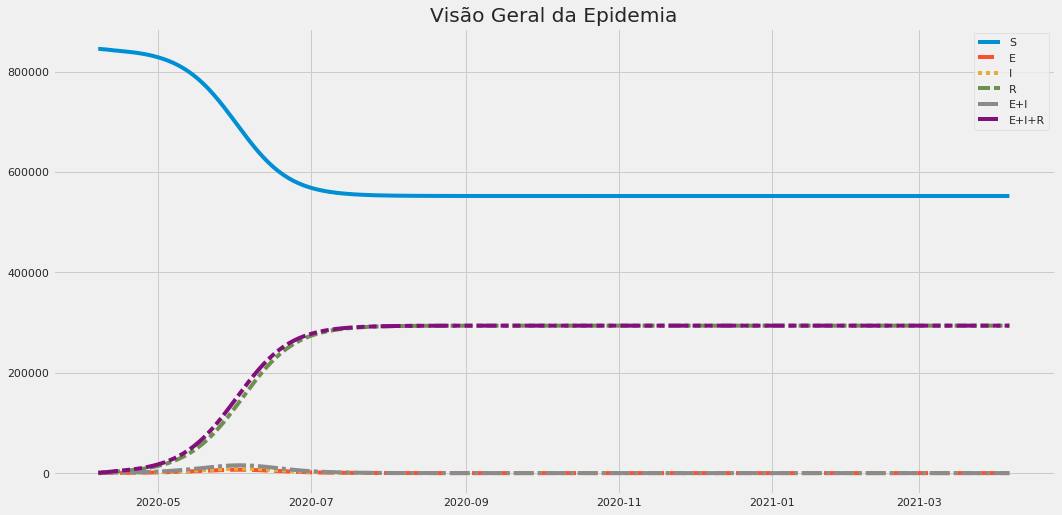

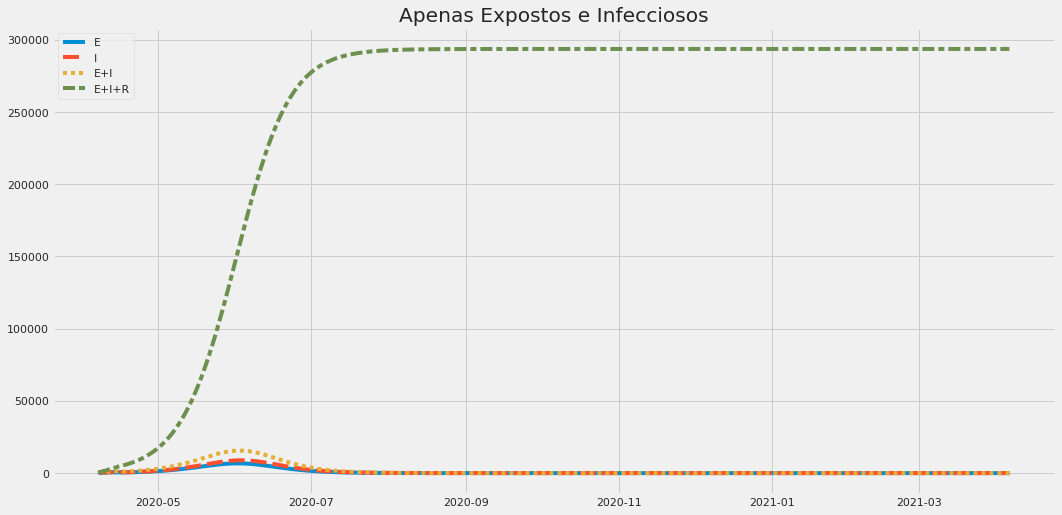

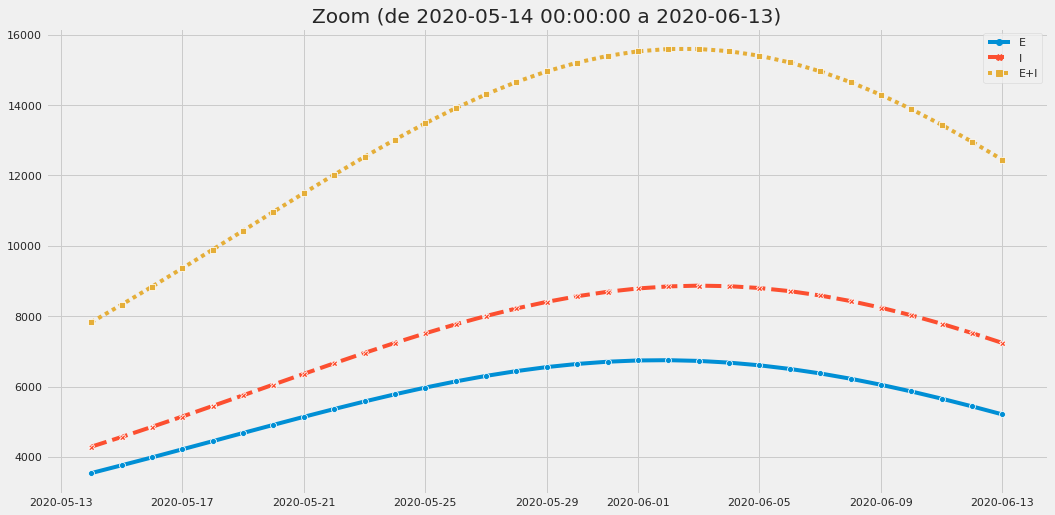

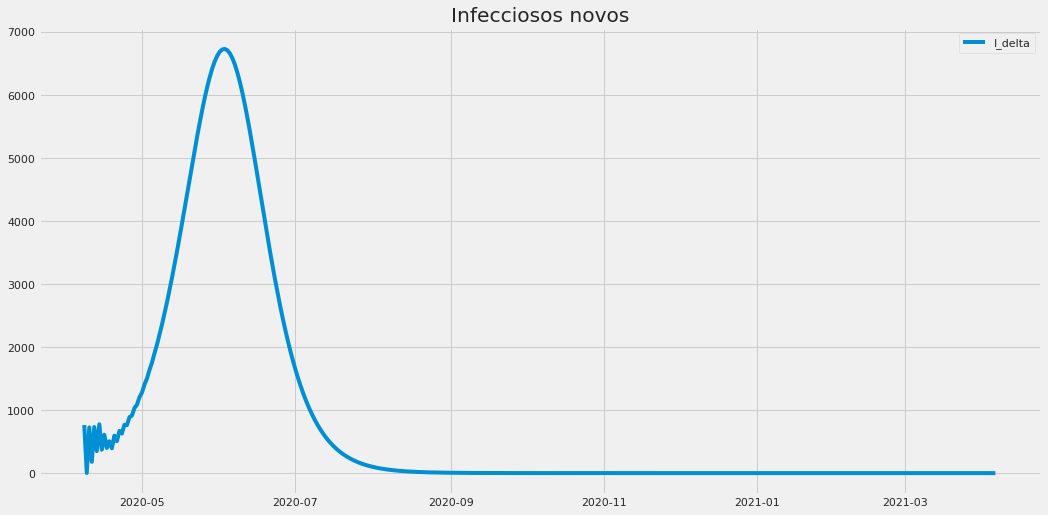

<Figure size 1152x576 with 0 Axes>

In [55]:
df_simulation_mitigation_data = simulate(S=population_size - initially_infected, 
                                          E=initially_infected,
                                          I=0,
                                          R=0, 
                                          alpha=alpha, beta=beta, gamma=gamma, 
                                          epidemic_start_date=epidemic_start_date, 
                                          epidemic_duration_in_days=epidemic_duration_in_days, 
                                          s_func=s, 
                                          e_func=e,
                                          i_func=i, 
                                          r_func=r,
                                          e_delta_func=e_delta,
                                          i_delta_func=i_delta,
                                          r_delta_func=r_delta)

plot_simulation_output(df_simulation_mitigation_data, zoom_length=30, file_name='dynamic')

In [56]:
best['beta_3'] / best['gamma_1']

1.224487034159507

Como isso essa versão com mitigação se compara visualmente com os dados reais observados?

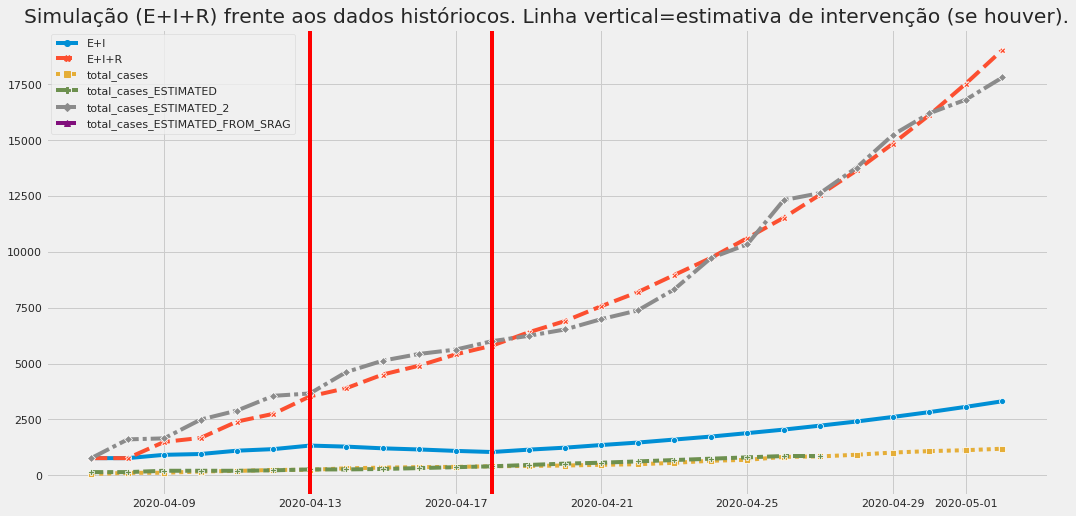

In [57]:
plot_curve_fitting(df_simulation_data=df_simulation_mitigation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   best=best, 
                   file_name='seir_dynamic_fit_zoom')

Finalmente, comparemos os casos com e sem mitigação.

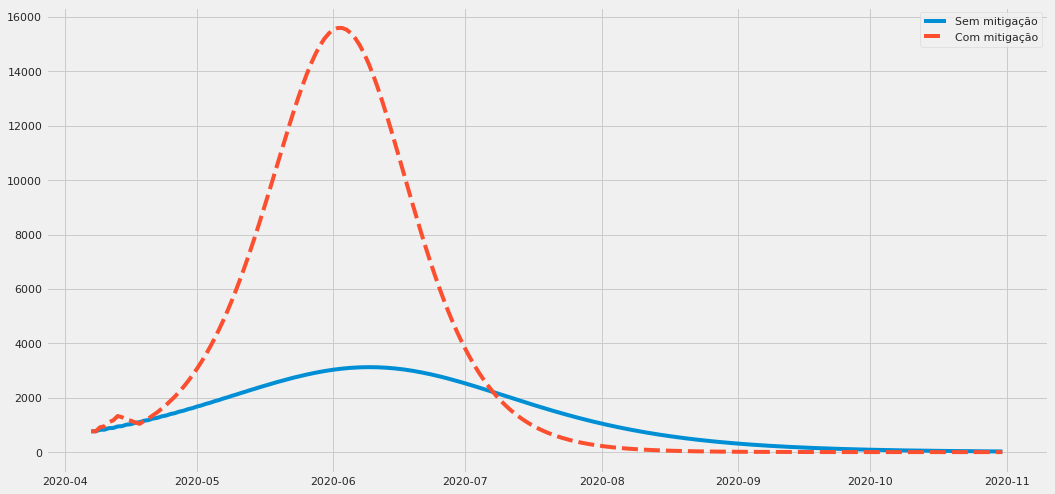

In [58]:
ax = sns.lineplot(data=pd.concat([df_simulation_data['E+I'].rename('Sem mitigação'), 
                                 df_simulation_mitigation_data['E+I'].rename('Com mitigação')], axis=1)['2020-03':'2020-10'])

ax.figure.savefig(results_folder + 'seir_constant_vs_dynamic' + f'_{target_location.lower()}' + results_suffix + '.png', 
                  format='png')

Salvemos os resultados.

In [59]:
df_simulation_mitigation_data.to_csv(results_folder + f'seir_dynamic_model_output.{target_location.lower()}.csv')

## Estudo de Calibragem de Parâmetros Variando-se Pontos de Corte Históricos 

Podemos também considerar o que ocorre com o treino do modelo conforme adquirimos mais dados históricos, simulando o ajuste do modelo ao longo de algumas janelas de tempo.

In [60]:
len(df_data_target)

28

In [61]:
%%time
if run_sensitivity_analysis:
    ss = []
    r0s = []
    for t in range(7, len(df_data_target), 1):
        print(f'###### t={t} ######')
        #space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, t)}

        t_2 = 10 if t >= 15.0 else 0.1
        t_3 = 10 if t >= 20.0 else 0.1

        ## assuming different gammas
        #
        #space = \
        #    {'dynamic':\
        #        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
        #           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
        #         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
        #        0, t)
        #    }

        # assuming gamma_1 == gamma_2 == gamma_3
        space = \
            {'dynamic':\
                ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
                   'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
                   'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
                   {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
                   'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
                 {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
                   'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
                0, t)
            }

        trials = hyperopt.Trials()
        best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

        print("Best parameters found:", best)

        alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                                    (best['alpha_2'], best['duration_2']),
                                    (best['alpha_3'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)
        beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                                    (best['beta_2'], best['duration_2']),
                                    (best['beta_3'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)
       #gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
       #                            (best['gamma_2'], best['duration_2']),
       #                            (best['gamma_3'], best['duration_3'])],
       #                            min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                                    (best['gamma_1'], best['duration_2']),
                                    (best['gamma_1'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)

        r0_1 = best['beta_1'] / best['gamma_1']
        r0_2 = best['beta_2'] / best['gamma_1'] # / best['gamma_2']
        r0_3 = best['beta_3'] / best['gamma_1'] # / best['gamma_3']

        r0s.append((r0_1, r0_2, r0_3))
        print(f'R0_1={r0_1}, R0_2={r0_2}, R0_3={r0_3}')


        df_simulation_partial_data = simulate(S=population_size - initially_infected, 
                                                  E=initially_infected,
                                                  I=0,
                                                  R=0, 
                                                  alpha=alpha, beta=beta, gamma=gamma, 
                                                  epidemic_start_date=epidemic_start_date, 
                                                  epidemic_duration_in_days=epidemic_duration_in_days, 
                                                  s_func=s, 
                                                  e_func=e,
                                                  i_func=i, 
                                                  r_func=r,
                                                  e_delta_func=e_delta,
                                                  i_delta_func=i_delta,
                                                  r_delta_func=r_delta)

        ss.append(df_simulation_partial_data['E+I'].rename(f'E+I, t <= {t}'))
        #ax = sns.lineplot(data=df_simulation_partial_data['E+I']['2020-03':'2020-07'])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


In [62]:
if run_sensitivity_analysis:
    df_r0 = pd.DataFrame(r0s)
    df_r0 = df_r0[df_r0 < 25]#.rolling(3).mean()
    ax = sns.lineplot(data=df_r0, dashes=False)

In [63]:
if run_sensitivity_analysis:
    df = pd.concat(ss, axis=1)['2020-03':'2020-09']

In [64]:
if run_sensitivity_analysis:
    df_filtered = df.iloc[:, 25:]
    palette = sns.color_palette("coolwarm", len(df_filtered.columns))
    ax = sns.lineplot(data=df_filtered, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

In [65]:
if run_sensitivity_analysis:
    palette = sns.color_palette("coolwarm", len(df.columns))
    ax = sns.lineplot(data=df, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

In [66]:
if run_sensitivity_analysis:
    ax.figure.savefig(results_folder + 'seir_multiple_historical_fits_2' + f'_{target_location.lower()}' + results_suffix + '.png', 
                      format='png')

    df.head()

Vemos que há grande sensibilidade do modelo frente a pequenos ajustes nos parâmetros de entrada, embora a maior quantidade de dados favoreça maior estabilidade.